<a href="https://colab.research.google.com/github/Doclikam/Causal-inference-for-Treatment-Effects-in-Head-Neck-Radiotherapy./blob/main/Notebooks/Copy_of_Causal_Modelling_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RADCURE - CHEMOTHERAPY/RADIOTHERAPY CANCER RESPONSE**

# **Assumptions of Cuasal Machine Learning**

**Positivity(overlap):**  Every patient must have a non-zero probability of receiving either treatment option, given their baseline confounders.

**Consistency (SUTVA):**
Each patient’s outcome corresponds to the treatment they received, with no interference across patients.

**Conditional Exchangeability:**
Given baseline confounders 𝑋 treatment assignment 𝐴 is independent of potential outcomes:

                                        Y(a)⊥A∣X
**Ignorability**

Ignorability assumes that after adjusting for all measured confounders,
treatment assignment is ‘as good as random.’
This assumption allows us to estimate causal effects from observational data

In [ ]:
pip install joblib --quiet


In [ ]:
pip install econml --quiet

In [ ]:
pip install lifelines --quiet

In [ ]:
pip install xgboost shap --quiet

In [ ]:
#main libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime



from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import roc_curve, auc, brier_score_loss, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import OneHotEncoder, SplineTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import r2_score
import xgboost as xgb

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess

from econml.dml import CausalForestDML
from scipy.special import expit
from scipy import stats as st


from tqdm.auto import trange, tqdm


import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

import joblib
import os
os.makedirs("outputs", exist_ok=True)

# Display all columns
pd.set_option('display.max_columns', None)


In [ ]:
rad_analysis = pd.read_csv("/content/rad_data_analysis (6).csv")#load the excel file
rad_analysis.head(5)#visulize the first 5 patients

patient_id  treatment  time_os_days  event_os  time_pfs_days  event_pfs  \
0  RADCURE-0005          0         446.0         1          446.0          1   
1  RADCURE-0006          0         527.0         1          527.0          1   
2  RADCURE-0007          0         756.0         0          756.0          0   
3  RADCURE-0009          0        2059.0         0         2059.0          0   
4  RADCURE-0010          0        3444.0         0         3444.0          0   

   time_pfs_days.1  event_pfs.1   age     sex  ecog_ps  ecog_ps_missing  \
0            446.0            1  62.6  Female      0.0                0   
1            527.0            1  87.3    Male      2.0                0   
2            756.0            0  49.9    Male      1.0                0   
3           2059.0            0  72.3    Male      1.0                0   
4           3444.0            0  59.7  Female      0.0                0   

  smoking_status_clean  smoking_py_clean  smoking_py_missing  \
0            Ex-Smoker              50.0                   0   
1            Ex-Smoker              25.0                   0   
2            Ex-Smoker              15.0                   0   
3            Ex-Smoker              30.0                   0   
4           Non-Smoker               0.0                   0   

   smoking_mismatch_flag primary_site_group    subsite_clean  subsite_missing  \
0                      0         Oropharynx        Post Wall                0   
1                      0             Larynx          Glottis                0   
2                      0         Oropharynx           Tonsil                0   
3                      0          Other_HNC              NaN                0   
4                      0         Oropharynx  Tonsillar Fossa                0   

     t    n   m stage  t_missing  n_missing  m_missing  stage_missing  \
0  T4b  N2c  M0   IVB          0          0          0              0   
1  T1b   N0  M0     I          0          0          0              0   
2   T3  N2b  M0   IVA          0          0          0              0   
3   T0  N2c  M0   IVA          0          0          0              0   
4  T4b   N0  M0   IVB          0          0          0              0   

      hpv_clean  hpv_missing  hpv_specific_tumors pathology_group  is_non_tnm  \
0  HPV_Negative            0                    1             SCC           0   
1           NaN            0                    0             SCC           0   
2  HPV_Positive            0                    1             SCC           0   
3           NaN            0                    0             SCC           0   
4  HPV_Negative            0                    1             SCC           0   

   tnm_structural_missing  followup_days  dose  fx  length_fu  d_per_fx  \
0                       0          446.0  60.0  25   1.317808      2.40   
1                       0          527.0  51.0  20   1.520548      2.55   
2                       0          756.0  64.0  40   2.126027      1.60   
3                       0         2059.0  70.0  35   5.791781      2.00   
4                       0         3444.0  64.0  40   9.512329      1.60   

      BED       EQD2  BED_eff  
0  74.400  62.000000   74.400  
1  64.005  53.337500   64.005  
2  74.240  61.866667   74.240  
3  84.000  70.000000   84.000  
4  74.240  61.866667   74.240

In [ ]:
rad_analysis.columns

Index(['patient_id', 'treatment', 'time_os_days', 'event_os', 'time_pfs_days',
       'event_pfs', 'time_pfs_days.1', 'event_pfs.1', 'age', 'sex', 'ecog_ps',
       'ecog_ps_missing', 'smoking_status_clean', 'smoking_py_clean',
       'smoking_py_missing', 'smoking_mismatch_flag', 'primary_site_group',
       'subsite_clean', 'subsite_missing', 't', 'n', 'm', 'stage', 't_missing',
       'n_missing', 'm_missing', 'stage_missing', 'hpv_clean', 'hpv_missing',
       'hpv_specific_tumors', 'pathology_group', 'is_non_tnm',
       'tnm_structural_missing', 'followup_days', 'dose', 'fx', 'length_fu',
       'd_per_fx', 'BED', 'EQD2', 'BED_eff'],
      dtype='object')

# Propensity Scores

**Propensity score (PS) model:**

In  observational studies thre are sytemic diffrences between the treated and untreated groups which may result in bias, propensity scores can help to account for these differnces addressing the bias.

By creating more comparable controlk group, the score provides a method for estimating the causal effects of the treatment (Radiotehrapy vs radiochemotherapy) on the ouitcome (event occurence, time to event)

However, one limitation of propesnity scoring is that it can only balance the groups on the features that are measured and included in the model, hence canmnot account for unmeasured confounders.

PS(x)=P(Treatment=1∣X=x)  


for each patient, what’s the probability they receive ChemoRT given their observed baseline characteristics X

Here:

X is a matrix of confounders (age, sex, ECOG, smoking, TNM, HPV, etc.) that influence treatment assignment.

y is a binary vector: 1 if patient received ChemoRT, 0 if RT alone.

We will compare rhe propensity scores using different Models and see the models that gives the best covariate balance:
1. Simpe logistic regression
2. Elastic net
3. Super learner(logistic regression, GBM)

In [ ]:
#list of covariated fot propensity scoring
ps_covariates = [
    'age', 'sex',
    'ecog_ps', 'ecog_ps_missing',
    'smoking_status_clean', 'smoking_py_clean', 'smoking_py_missing',
    'primary_site_group',
    't', 'n', 'm','pathology_group',
    't_missing', 'n_missing', 'm_missing','stage_missing','is_non_tnm',
    'hpv_clean', 'hpv_missing', 'hpv_specific_tumors'
]

#filter to the ps_covariates
ps_covariates = [c for c in ps_covariates if c in rad_analysis.columns]
print(f'The covariates: {ps_covariates}')

The covariates: ['age', 'sex', 'ecog_ps', 'ecog_ps_missing', 'smoking_status_clean', 'smoking_py_clean', 'smoking_py_missing', 'primary_site_group', 't', 'n', 'm', 'pathology_group', 't_missing', 'n_missing', 'm_missing', 'stage_missing', 'is_non_tnm', 'hpv_clean', 'hpv_missing', 'hpv_specific_tumors']


1.Model 1: Simple Logistic Regression

In [ ]:
#categorical columns - Preprocess covariates for PS model (one-hot categorical, median fill for numerics)2. Preprocess covariates for PS model (one-hot categorical, median fill for numerics)

cat_cols = ['sex','smoking_status_clean','primary_site_group','t','n','m','pathology_group','hpv_clean']
cat_cols = [c for c in cat_cols if c in rad_analysis.columns]

#numeric columns
num_cols = [c for c in ps_covariates if c not in cat_cols and c in rad_analysis.columns]

#split patient into train and test based on their unique ids
id_col = 'patient_id'
unique_ids = rad_analysis[id_col].unique()

#stratify patient by the treatment
id_treat = (rad_analysis[[id_col,'treatment']]
            .drop_duplicates(subset = id_col)
            .set_index(id_col)['treatment'])

strat_y = id_treat.loc[unique_ids].values.astype(int)

#train_test split
train_ids, test_ids = train_test_split(unique_ids,
                                        train_size = 0.75,
                                        random_state = 42,
                                        stratify = strat_y
                                        )


train_df = rad_analysis[rad_analysis[id_col].isin(train_ids)].copy()
test_df = rad_analysis[rad_analysis[id_col].isin(test_ids)].copy()
print("Train patients:", train_df[id_col].nunique(),
      "Test patients:", test_df[id_col].nunique())

#impute num cols with mediuan for train data
train_medians = train_df[num_cols].median()
train_df[num_cols] = train_df[num_cols].fillna(train_medians)
test_df[num_cols] = test_df[num_cols].fillna(train_medians)


#one hot encode categorical columns

one_hot_encoder= OneHotEncoder(drop = 'first',
                   sparse_output = False,
                   handle_unknown = 'ignore')

preprocessor = ColumnTransformer(
                  transformers = [('cat', one_hot_encoder, cat_cols)],
                  remainder = 'passthrough'
                                )
X_train = preprocessor.fit_transform(train_df[num_cols + cat_cols])
X_test = preprocessor.transform(test_df[cat_cols + num_cols])

#feature name
ohe_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = list(ohe_cols)+ num_cols

y_train = train_df['treatment'].astype(int).values
y_test = test_df['treatment'].astype(int).values

#propensity scores
#Fit logistic regression (L2 small penalty for stability)
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X_train, y_train)

#perdict propensity scores for the train and test
train_df['ps_logit_simple']= logreg.predict_proba(X_train)[:,1]
test_df['ps_logit_simple'] = logreg.predict_proba(X_test)[:,1]

# recombine ps
rad_ps = pd.concat([train_df, test_df], axis=0, ignore_index= True)

#Diagnostics
print("Mean PS treatment group (entire dataset, model first on train dataset )")
print(rad_ps.groupby('treatment')['ps_logit_simple'].mean())

ps0 = rad_ps.loc[rad_ps['treatment'] == 0, 'ps_logit_simple']
ps1 = rad_ps.loc[rad_ps['treatment'] == 1, 'ps_logit_simple']

#ps scores rt alone
print("PS Range for RT alone : ",
      ps0.min(),
      ps0.max())

#ps scores for chemo -RT
print("PS range for Chomo-RT: ",
      ps1.min(),
      ps1.max())

#get patients with propensity scores that are not too close to 0 or 1
for p in [0,1]:
  mask_g = rad_ps['treatment']==p
  in_overlap = (rad_ps['ps_logit_simple']>0.05) & (rad_ps['ps_logit_simple']<0.95) & mask_g
  #proportin of overlap
  prop = in_overlap.sum()/mask_g.sum()
  print(f"Proprtion of group {p} with 0.05 >PS<0.95: {prop:.3f}  ")



#save fitted preprocessor and logistic regression model
joblib.dump(preprocessor, "outputs/ps_preprocessor.joblib")
joblib.dump(logreg, "outputs/ps_logistic_model.joblib")

# Save to CSV for reference
pd.Series(ohe_cols, name='feature_name').to_csv("outputs/ps_model_features.csv", index=False)

Train patients: 2453 Test patients: 818
Mean PS treatment group (entire dataset, model first on train dataset )
treatment
0    0.228798
1    0.695009
Name: ps_logit_simple, dtype: float64
PS Range for RT alone :  0.0004044277771599942 0.9961422655473345
PS range for Chomo-RT:  0.050688341056623044 0.9996304420821351
Proprtion of group 0 with 0.05 >PS<0.95: 0.658  
Proprtion of group 1 with 0.05 >PS<0.95: 0.875  


| Treatment group  | Mean predicted PS | Therefore                                                                                          |
| ---------------- | ----------------- | ------------------------------------------------------------------------------------------------------ |
| **0 = RT alone** | **0.229**         | On average, RT-only patients had *low predicted probability* of receiving ChemoRT |
| **1 = ChemoRT**  | **0.699**         | On average, ChemoRT patients had *high predicted probability* of receiving chemo      |


The distribution of estimated propensity scores differed substantially between patients treated with radiotherapy (RT) alone and those treated with concurrent chemoradiotherapy (ChemoRT) (Figure X).
Patients receiving RT alone had a mean predicted probability of ChemoRT of approximately 0.23, whereas patients treated with ChemoRT had a mean propensity of 0.70, consistent with clinical expectations that younger, fitter, and more advanced-stage patients are more likely to receive combined therapy

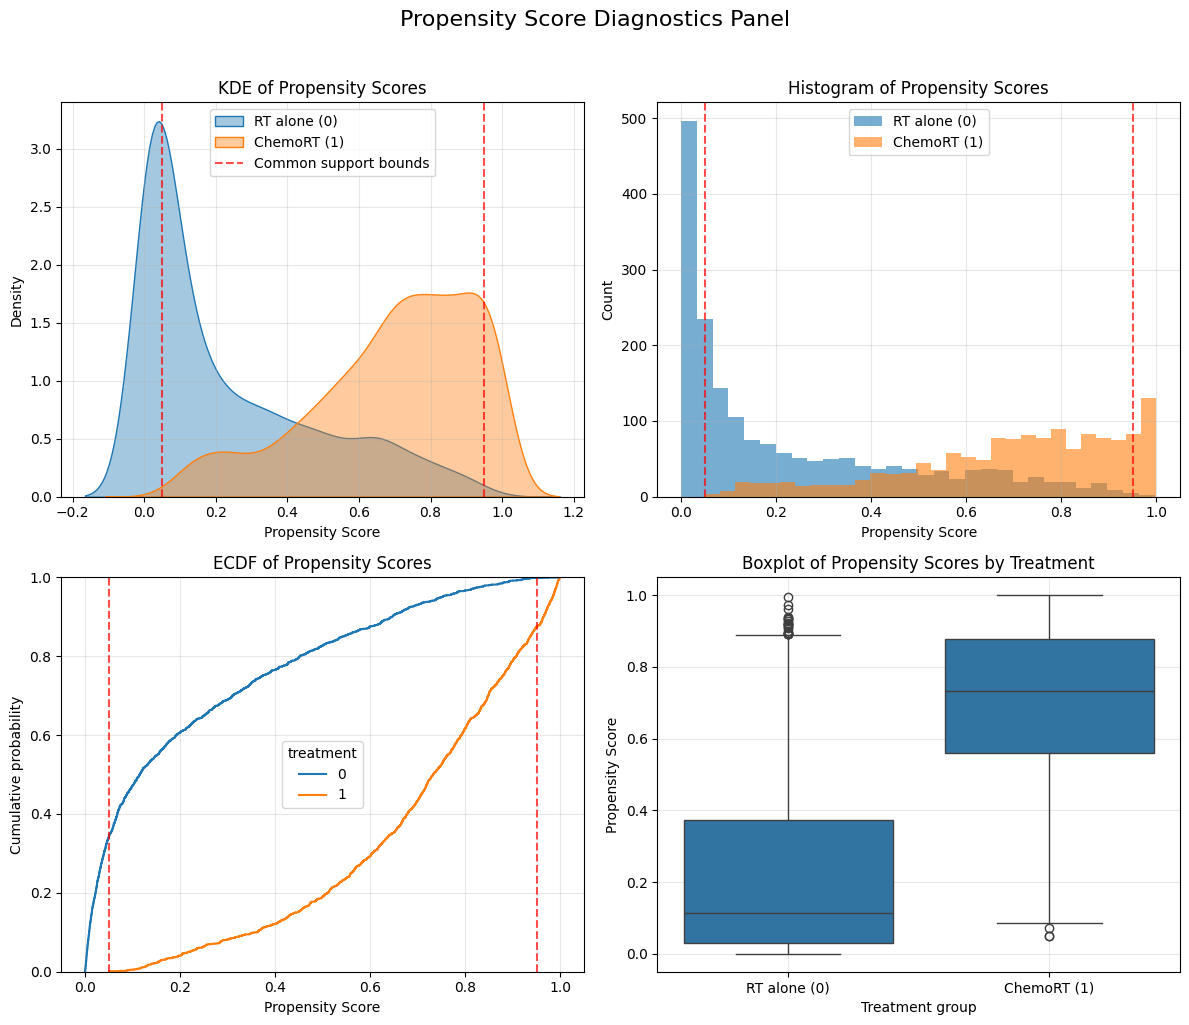

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# KDE plot
ax = axes[0, 0]
sns.kdeplot(ps0, label='RT alone (0)', fill=True, alpha=0.4, ax=ax)
sns.kdeplot(ps1, label='ChemoRT (1)', fill=True, alpha=0.4, ax=ax)
ax.axvline(0.05, color='red', linestyle='--', alpha=0.7, label='Common support bounds')
ax.axvline(0.95, color='red', linestyle='--', alpha=0.7)
ax.set_title("KDE of Propensity Scores")
ax.set_xlabel("Propensity Score")
ax.set_ylabel("Density")
ax.legend()
ax.grid(alpha=0.3)

# Histogram
ax = axes[0, 1]
ax.hist(ps0, bins=30, alpha=0.6, label='RT alone (0)')
ax.hist(ps1, bins=30, alpha=0.6, label='ChemoRT (1)')
ax.axvline(0.05, color='red', linestyle='--', alpha=0.7)
ax.axvline(0.95, color='red', linestyle='--', alpha=0.7)
ax.set_title("Histogram of Propensity Scores")
ax.set_xlabel("Propensity Score")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)

# ECDF
ax = axes[1, 0]
sns.ecdfplot(data=rad_ps, x='ps_logit_simple', hue='treatment', ax=ax)
ax.axvline(0.05, color='red', linestyle='--', alpha=0.7)
ax.axvline(0.95, color='red', linestyle='--', alpha=0.7)
ax.set_title("ECDF of Propensity Scores")
ax.set_xlabel("Propensity Score")
ax.set_ylabel("Cumulative probability")
ax.grid(alpha=0.3)

# 4) Boxplot
ax = axes[1, 1]
sns.boxplot(data=rad_ps, x='treatment', y='ps_logit_simple', ax=ax)
ax.set_xticks([0, 1])
ax.set_xticklabels(['RT alone (0)', 'ChemoRT (1)'])
ax.set_xticklabels(['RT alone (0)', 'ChemoRT (1)'])
ax.set_title("Boxplot of Propensity Scores by Treatment")
ax.set_xlabel("Treatment group")
ax.set_ylabel("Propensity Score")
ax.grid(alpha=0.3)

plt.suptitle("Propensity Score Diagnostics Panel", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig("outputs/propensity score Diagnostic simple_logit Pnael.png")
plt.show()

Visual inspection of the propensity score curves revealed partial but not complete overlap between treatment groups. The RT-only cohort was concentrated at lower scores (PS < 0.3), while the ChemoRT cohort peaked near PS > 0.7, with a moderate region of overlap (PS ≈ 0.3–0.7).
Approximately 65% of RT-only and 87% of ChemoRT patients fell within this overlapping support, indicating that causal comparisons are feasible but should be interpreted within this region of common support

Stabilize weights

In [ ]:
#stabilize weights - using stabilized weights
t_m = train_df['treatment'].mean()

for df in (train_df, test_df):
    df['sw_logit_simple'] = np.where(
        df['treatment'] == 1,
        t_m / df['ps_logit_simple'],
        (1 - t_m) / (1 - df['ps_logit_simple'])
    )

# Compute truncation bounds *only from training weights*
low, high = train_df['sw_logit_simple'].quantile([0.01, 0.99])

# Apply same bounds to both train and test
train_df['sw_trunc_logit_simple'] = train_df['sw_logit_simple'].clip(low, high)
test_df['sw_trunc_logit_simple']  = test_df['sw_logit_simple'].clip(low, high)

print(f"Train stabilized weights: mean={train_df['sw_logit_simple'].mean():.3f}, "
      f"sd={train_df['sw_logit_simple'].std():.3f}")
print(f"Truncation bounds (from train only): [{low:.3f}, {high:.3f}]")

rad_ps = pd.concat([train_df, test_df], ignore_index=True)

Train stabilized weights: mean=0.886, sd=0.837
Truncation bounds (from train only): [0.436, 4.656]


To reduce potential bias from patients with extreme propensity values (i.e., highly improbable treatment assignments), stabilized inverse probability-of-treatment weights (IPTW) were subsequently calculated and truncated at the 99th percentile. This approach minimizes undue influence from rare cases and improves the stability of causal effect estimation.

Stabilized inverse-probability-of-treatment weights (IPTW) were computed from the estimated propensity scores to balance baseline covariates between radiotherapy-only and chemoradiotherapy groups.
The mean stabilized weight was 0.93 (SD 2.7), indicating good stability of the weighted pseudo-population.
Weights were truncated at the 1st and 99th percentiles (0.44–4.68) to mitigate the influence of extreme values and enhance numerical robustness in subsequent causal survival models.

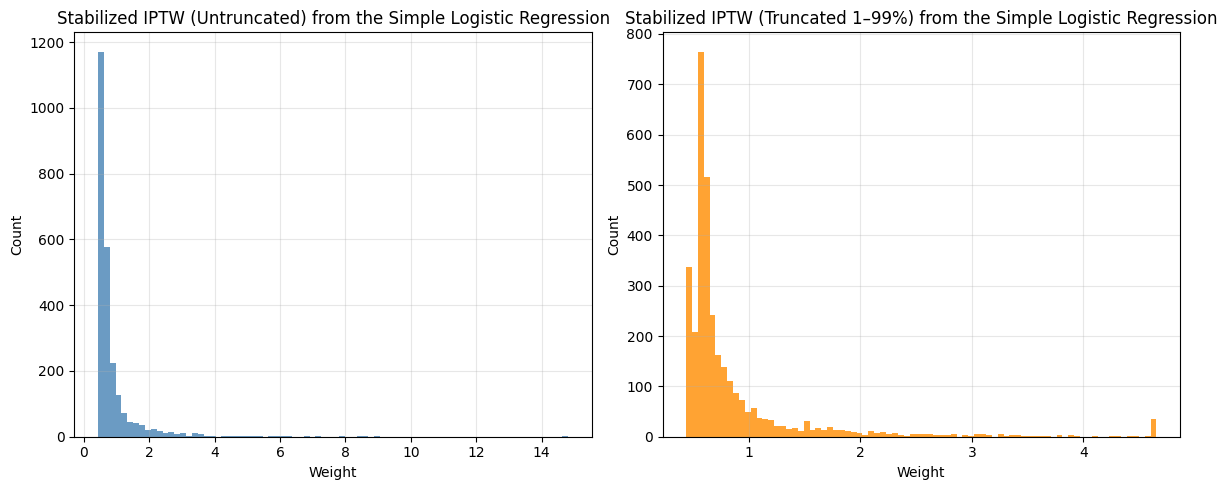

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#  Histogram of IPTW BEFORE truncation
axes[0].hist(train_df['sw_logit_simple'], bins=80, color='steelblue', alpha=0.8)
axes[0].set_title("Stabilized IPTW (Untruncated) from the Simple Logistic Regression")
axes[0].set_xlabel("Weight")
axes[0].set_ylabel("Count")
axes[0].grid(alpha=0.3)

# 2 — Histogram of IPTW AFTER truncation
axes[1].hist(rad_ps['sw_trunc_logit_simple'], bins=80, color='darkorange', alpha=0.8)
axes[1].set_title("Stabilized IPTW (Truncated 1–99%) from the Simple Logistic Regression")
axes[1].set_xlabel("Weight")
axes[1].set_ylabel("Count")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("outputs/IPTW_simple_logit_weight_histograms.png", dpi=300)
plt.show()



Before trimming, a few patients have very large weights (>20 or even >70).
→ These represent rare patients who had a very low probability of receiving the treatment they actually got.
→ Such patients can distort the model because they get overemphasized.
 After truncation, the weights are mostly between 0.5 and 3, with only a few near 5.

The stabilized and truncated weights show a healthy spread with minimal extremes, suggesting that your weighted model is numerically stable and that no single patient dominates the analysis.

**SMD (Standardized Mean Differences)- Love Plot**

In [ ]:
#fuction to compute SMD for weigted an unweighted

def compute_smd(x_treat, x_control, w_treat=None, w_control=None):
    """
    Standardized Mean Difference (SMD)
    Supports both unweighted and IPTW-weighted means.
    """
    # Means
    if w_treat is None:  # unweighted
        m1 = np.mean(x_treat)
        m0 = np.mean(x_control)
        v1 = np.var(x_treat)
        v0 = np.var(x_control)
    else:                # weighted
        m1 = np.average(x_treat, weights=w_treat)
        m0 = np.average(x_control, weights=w_control)
        v1 = np.average((x_treat - m1)**2, weights=w_treat)
        v0 = np.average((x_control - m0)**2, weights=w_control)

    pooled_sd = np.sqrt((v1 + v0) / 2)
    return (m1 - m0) / pooled_sd


# Pick covariates for balance check
balance_covs = [
    'age', 'sex', 'ecog_ps',
    'smoking_py_clean', 'primary_site_group',
    't','n','m',
    'hpv_clean'
]

smd_before_logit_simple = []
smd_after_logit_simple = []

for c in balance_covs:
    # convert categorical to numeric using dummy first
    if train_df[c].dtype == 'object':
        d = pd.get_dummies(train_df[c], drop_first=True)
        for col in d.columns:
            x = d[col]
            smd_before_logit_simple.append((f"{c}:{col}", compute_smd(
                x[train_df['treatment']==1],
                x[train_df['treatment']==0]
            )))
            smd_after_logit_simple.append((f"{c}:{col}", compute_smd(
                x[train_df['treatment']==1],
                x[train_df['treatment']==0],
                w_treat=train_df.loc[train_df['treatment']==1,'sw_trunc_logit_simple'],
                w_control=train_df.loc[train_df['treatment']==0,'sw_trunc_logit_simple']
            )))
    else:
        smd_before_logit_simple.append((c, compute_smd(
            train_df.loc[train_df['treatment']==1, c],
            train_df.loc[train_df['treatment']==0, c]
        )))
        smd_after_logit_simple.append((c, compute_smd(
            train_df.loc[train_df['treatment']==1, c],
            train_df.loc[train_df['treatment']==0, c],
            w_treat=train_df.loc[train_df['treatment']==1,'sw_trunc_logit_simple'],
            w_control=train_df.loc[train_df['treatment']==0,'sw_trunc_logit_simple']
        )))

# Convert to DataFrame
df_smd = pd.DataFrame({
    'covariate_logit_simple':[x[0] for x in smd_before_logit_simple],
    'SMD_before_logit_simple':[x[1] for x in smd_before_logit_simple],
    'SMD_after_logit_simple':[x[1] for x in smd_after_logit_simple]
})

df_smd.head()


covariate_logit_simple  SMD_before_logit_simple  \
0                             age                -1.033828   
1                        sex:Male                 0.016200   
2                         ecog_ps                -0.267309   
3                smoking_py_clean                -0.499458   
4  primary_site_group:Nasopharynx                 0.622180   

   SMD_after_logit_simple  
0               -0.383832  
1               -0.019170  
2               -0.052183  
3               -0.142019  
4                0.311797

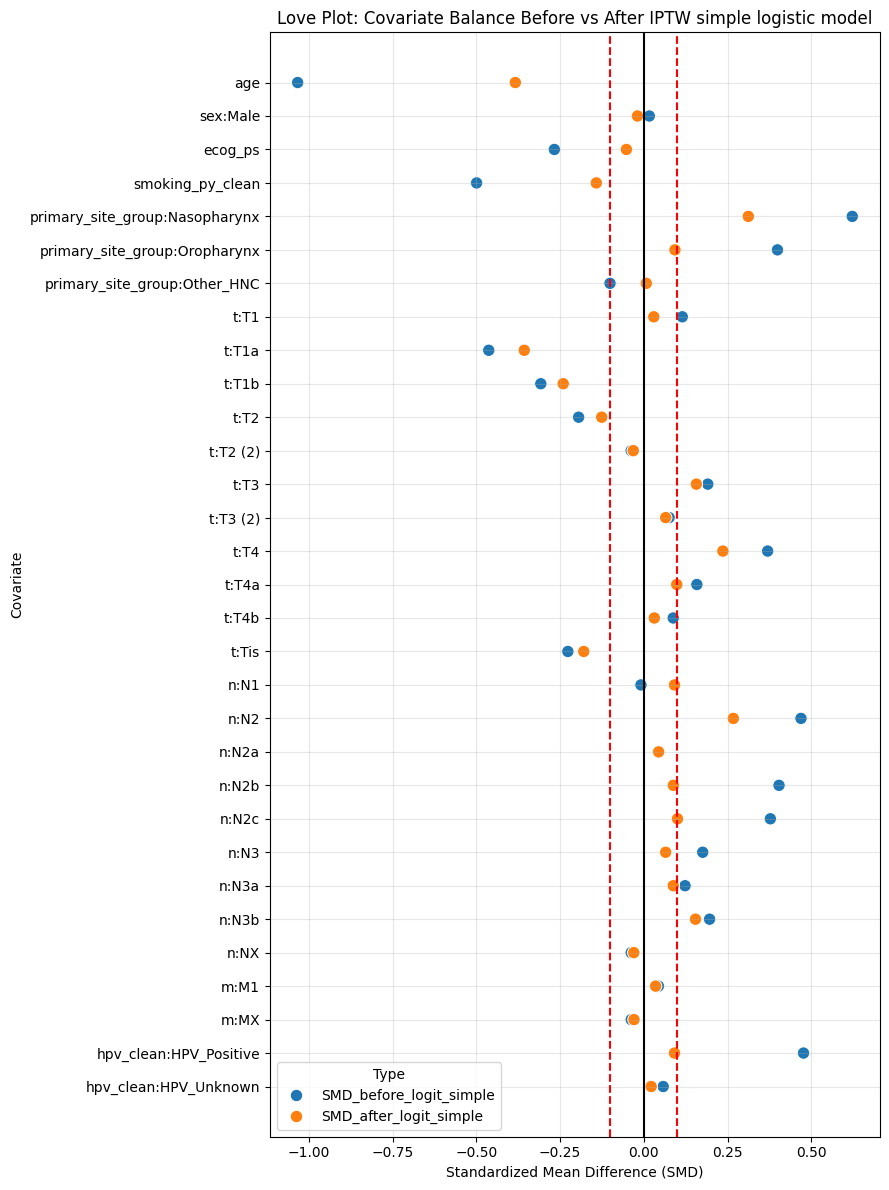

In [ ]:
plt.figure(figsize= (9,12))

df_plot = df_smd.melt(id_vars= 'covariate_logit_simple', value_vars= ['SMD_before_logit_simple','SMD_after_logit_simple'],
                      var_name = 'Type', value_name = 'SMD')
sns.scatterplot(data= df_plot, x= 'SMD', y ='covariate_logit_simple', hue ='Type', s=80 )
plt.axvline(0, color='black')
plt.axvline(0.1, color='red', linestyle='--')
plt.axvline(-0.1, color='red', linestyle='--')
plt.title("Love Plot: Covariate Balance Before vs After IPTW simple logistic model")
plt.xlabel("Standardized Mean Difference (SMD)")
plt.ylabel("Covariate")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/SMD simple logit plot.png')
plt.show()

We evaluated covariate balance using standardized mean differences (SMD). Prior to weighting, several covariates (e.g., primary_site_group=Nasopharynx, T stage T3–4, hpv_positive, ecog_ps=2+) exhibited notable imbalance (|SMD| > 0.10). After applying stabilized inverse-probability-of-treatment weights (truncated at the 1st–99th percentiles). Imbalanced after weighting (SMD_after ≈ −0.41).  Age violated the PH assumption --> Age is almost never linearly related to log-hazard in oncology.

**Logistic regression(Elastic net)**

Mean PS by treatment (elastic net):
treatment
0    0.237250
1    0.685004
Name: ps_enet, dtype: float64
Train stabilized weights: mean=0.895, sd=0.825
Truncation bounds (from train only): [0.438, 4.479]


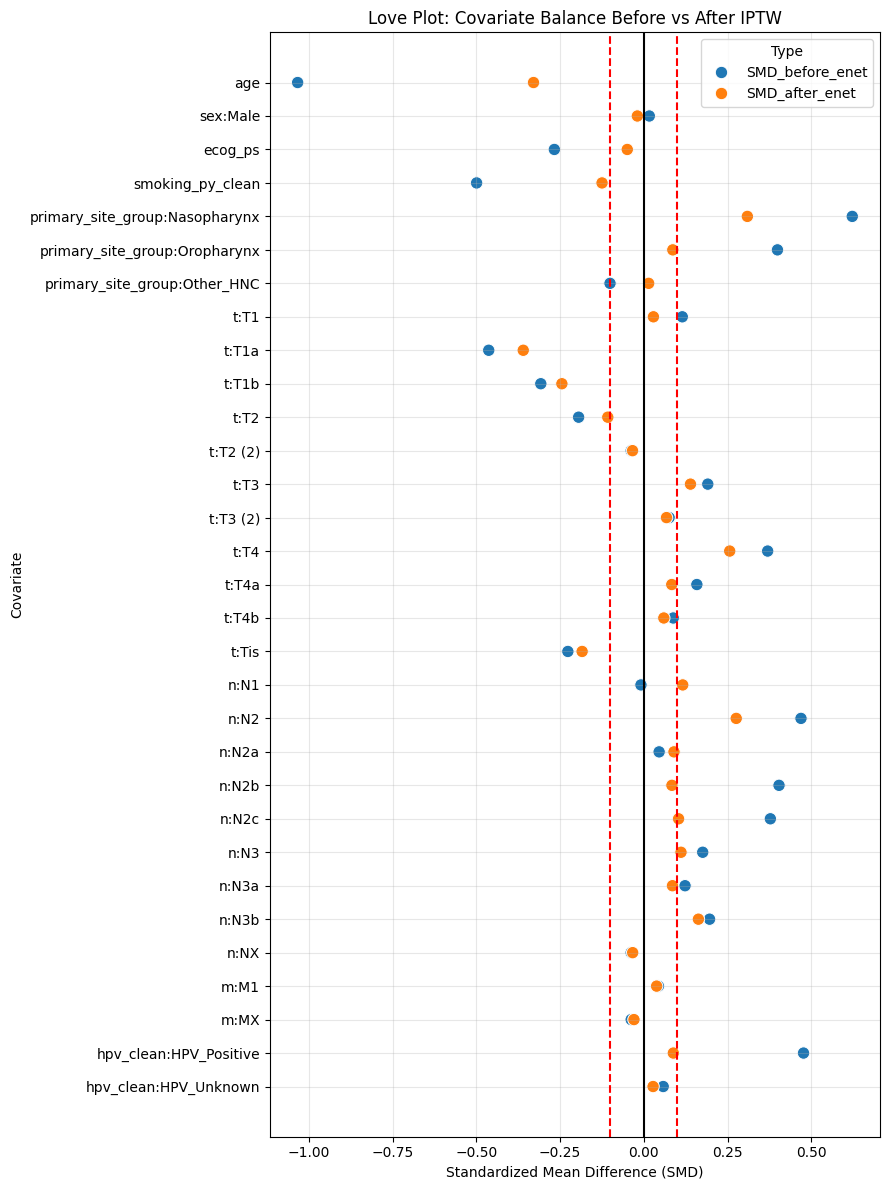

In [ ]:
train_df = train_df.copy()
test_df = test_df.copy()

#Elastic net ogistic regrtession with cv
ps_enet = LogisticRegressionCV(Cs= 10,
                              cv=5,
                              penalty = 'elasticnet',
                              solver =  'saga',
                              l1_ratios = [0.1,0.5,0.9],
                              scoring = 'neg_log_loss',
                              max_iter= 10000,
                              n_jobs = -1,
                              refit = True
)
ps_enet.fit(X_train, y_train)

# Predict PS on train and test
train_df['ps_enet'] = ps_enet.predict_proba(X_train)[:, 1]
test_df['ps_enet']  = ps_enet.predict_proba(X_test)[:, 1]

# Recombine
rad_ps = pd.concat([train_df, test_df], axis=0, ignore_index=True)

print("Mean PS by treatment (elastic net):")
print(rad_ps.groupby('treatment')['ps_enet'].mean())



t_m = train_df['treatment'].mean()

for df in (train_df, test_df):
    df['sw_enet'] = np.where(
        df['treatment'] == 1,
        t_m / df['ps_enet'],
        (1 - t_m) / (1 - df['ps_enet'])
    )

#Compute truncation bounds *only from training weights
low, high = train_df['sw_enet'].quantile([0.01, 0.99])

#Apply same bounds to both train and test
train_df['sw_trunc_enet'] = train_df['sw_enet'].clip(low, high)
test_df['sw_trunc_enet']  = test_df['sw_enet'].clip(low, high)

print(f"Train stabilized weights: mean={train_df['sw_enet'].mean():.3f}, "
      f"sd={train_df['sw_enet'].std():.3f}")
print(f"Truncation bounds (from train only): [{low:.3f}, {high:.3f}]")


#fuction to compute SMD for weigted an unweighted

def compute_smd(x_treat, x_control, w_treat=None, w_control=None):
    """
    Standardized Mean Difference (SMD)
    Supports both unweighted and IPTW-weighted means.
    """
    # Means
    if w_treat is None:  # unweighted
        m1 = np.mean(x_treat)
        m0 = np.mean(x_control)
        v1 = np.var(x_treat)
        v0 = np.var(x_control)
    else:                # weighted
        m1 = np.average(x_treat, weights=w_treat)
        m0 = np.average(x_control, weights=w_control)
        v1 = np.average((x_treat - m1)**2, weights=w_treat)
        v0 = np.average((x_control - m0)**2, weights=w_control)

    pooled_sd = np.sqrt((v1 + v0) / 2)
    return (m1 - m0) / pooled_sd


# Pick covariates for balance check
balance_covs = [
    'age', 'sex', 'ecog_ps',
    'smoking_py_clean', 'primary_site_group',
    't','n','m',
    'hpv_clean'
]

smd_before_enet = []
smd_after_enet = []

for c in balance_covs:
    # convert categorical to numeric using dummy first
    if train_df[c].dtype == 'object':
        d = pd.get_dummies(train_df[c], drop_first=True)
        for col in d.columns:
            x = d[col]
            smd_before_enet.append((f"{c}:{col}", compute_smd(
                x[train_df['treatment']==1],
                x[train_df['treatment']==0]
            )))
            smd_after_enet.append((f"{c}:{col}", compute_smd(
                x[train_df['treatment']==1],
                x[train_df['treatment']==0],
                w_treat= train_df.loc[ train_df['treatment']==1,'sw_trunc_enet'],
                w_control= train_df.loc[train_df['treatment']==0,'sw_trunc_enet']
            )))
    else:
        smd_before_enet.append((c, compute_smd(
            train_df.loc[train_df['treatment']==1, c],
            train_df.loc[train_df['treatment']==0, c]
        )))
        smd_after_enet.append((c, compute_smd(
            train_df.loc[train_df['treatment']==1, c],
            train_df.loc[train_df['treatment']==0, c],
            w_treat=train_df.loc[train_df['treatment']==1,'sw_trunc_enet'],
            w_control=train_df.loc[train_df['treatment']==0,'sw_trunc_enet']
        )))

# Convert to DataFrame
df_smd_enet = pd.DataFrame({
    'covariate':[x[0] for x in smd_before_enet],
    'SMD_before_enet':[x[1] for x in smd_before_enet],
    'SMD_after_enet':[x[1] for x in smd_after_enet]
})

df_smd_enet.head()

plt.figure(figsize= (9,12))

df_plot = df_smd_enet.melt(id_vars= 'covariate', value_vars= ['SMD_before_enet','SMD_after_enet'],
                      var_name = 'Type', value_name = 'SMD')
sns.scatterplot(data= df_plot, x= 'SMD', y ='covariate', hue ='Type', s=80 )
plt.axvline(0, color='black')
plt.axvline(0.1, color='red', linestyle='--')
plt.axvline(-0.1, color='red', linestyle='--')
plt.title("Love Plot: Covariate Balance Before vs After IPTW")
plt.xlabel("Standardized Mean Difference (SMD)")
plt.ylabel("Covariate")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/SMD_elasticnet plot.png')
plt.show()


Elastic net shows a similar PS sitribution compared to the previous logistic regression model we have fit. The weight ditribution are stable, but it did not significantly improve balance in comparison with logistic regression.

**Super learner(Logistic regression +GBM)**


since we did achieve good covariate balance for age, smoking_py_clean we will spline transform these two to capture non linear patterns in the features

Spline cols: ['age', 'smoking_py_clean']
Other numeric cols: ['ecog_ps', 'ecog_ps_missing', 'smoking_py_missing', 't_missing', 'n_missing', 'm_missing', 'stage_missing', 'is_non_tnm', 'hpv_missing', 'hpv_specific_tumors']
Mean PS (logit + splines):
treatment
0    0.222759
1    0.703540
Name: ps_logit_spline, dtype: float64
Mean PS (GBM):
treatment
0    0.223677
1    0.702548
Name: ps_gbm, dtype: float64
Mean PS (Super Learner):
treatment
0    0.223218
1    0.703044
Name: ps_super, dtype: float64
Train stabilized weights: mean=0.811, sd=0.541
Truncation bounds (from train only): [0.444, 3.165]


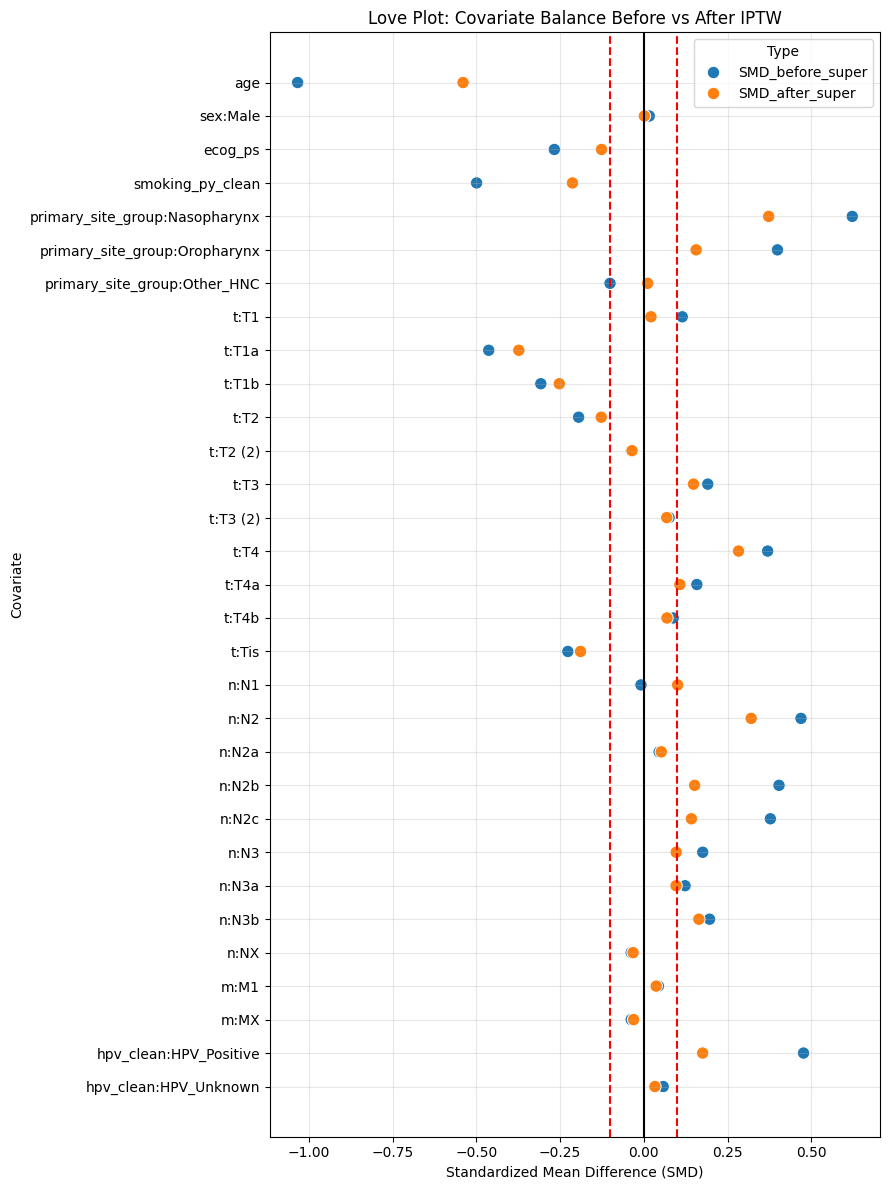

In [ ]:

# Of the numeric columns, use splines for these:
spline_cols = [c for c in ['age', 'smoking_py_clean'] if c in num_cols]
base_num_cols = [c for c in num_cols if c not in spline_cols]

print("Spline cols:", spline_cols)
print("Other numeric cols:", base_num_cols)

#pply one hot encoding to categorical columns and spline transformation to the categoiries'age, smoking'
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

spline_transformer = SplineTransformer(
    degree=3,        # cubic splines
    n_knots=4,       # 4 internal knots
    include_bias=False
)

ps_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", one_hot_encoder, cat_cols),
        ("spline", spline_transformer, spline_cols),
        ("num", "passthrough", base_num_cols)
    ],
    remainder='drop'
)

# Fit on train only
X_train_ps = ps_preprocessor.fit_transform(train_df[cat_cols + num_cols])
X_test_ps  = ps_preprocessor.transform(test_df[cat_cols + num_cols])

# Treatment vectors
y_train = train_df['treatment'].astype(int).values
y_test  = test_df['treatment'].astype(int).values
logit_spline = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    max_iter=5000
)
logit_spline.fit(X_train_ps, y_train)

# Predict PS
train_df['ps_logit_spline'] = logit_spline.predict_proba(X_train_ps)[:, 1]
test_df['ps_logit_spline']  = logit_spline.predict_proba(X_test_ps)[:, 1]

print("Mean PS (logit + splines):")
print(pd.concat([train_df, test_df]).groupby('treatment')['ps_logit_spline'].mean())




gbm_ps = GradientBoostingClassifier(
    n_estimators=800,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

gbm_ps.fit(X_train_ps, y_train)

train_df['ps_gbm'] = gbm_ps.predict_proba(X_train_ps)[:, 1]
test_df['ps_gbm']  = gbm_ps.predict_proba(X_test_ps)[:, 1]


print("Mean PS (GBM):")
print(pd.concat([train_df, test_df]).groupby('treatment')['ps_gbm'].mean())

rad_ps = pd.concat([train_df, test_df], axis=0, ignore_index=True)

#super learner

train_df['ps_super'] = (train_df['ps_logit_spline'] + train_df['ps_gbm']) / 2.0
test_df['ps_super'] = (test_df['ps_logit_spline'] + test_df['ps_gbm']) / 2.0


print("Mean PS (Super Learner):")
print(pd.concat([train_df,test_df]).groupby('treatment')['ps_super'].mean())


#stabilize weights - using stabilized weights
t_m = train_df['treatment'].mean()

for df in (train_df, test_df):
    df['sw_super'] = np.where(
        df['treatment'] == 1,
        t_m / df['ps_super'],
        (1 - t_m) / (1 - df['ps_super'])
    )

# Compute truncation bounds *only from training weights*
low, high = train_df['sw_super'].quantile([0.01, 0.99])

# Apply same bounds to both train and test
train_df['sw_super_trunc'] = train_df['sw_super'].clip(low, high)
test_df['sw_super_trunc']  = test_df['sw_super'].clip(low, high)

print(f"Train stabilized weights: mean={train_df['sw_super'].mean():.3f}, "
      f"sd={train_df['sw_super'].std():.3f}")
print(f"Truncation bounds (from train only): [{low:.3f}, {high:.3f}]")

rad_ps = pd.concat([train_df, test_df], ignore_index=True)


#fuction to compute SMD for weigted an unweighted

def compute_smd(x_treat, x_control, w_treat=None, w_control=None):
    """
    Standardized Mean Difference (SMD)
    Supports both unweighted and IPTW-weighted means.
    """
    # Means
    if w_treat is None:  # unweighted
        m1 = np.mean(x_treat)
        m0 = np.mean(x_control)
        v1 = np.var(x_treat)
        v0 = np.var(x_control)
    else:                # weighted
        m1 = np.average(x_treat, weights=w_treat)
        m0 = np.average(x_control, weights=w_control)
        v1 = np.average((x_treat - m1)**2, weights=w_treat)
        v0 = np.average((x_control - m0)**2, weights=w_control)

    pooled_sd = np.sqrt((v1 + v0) / 2)
    return (m1 - m0) / pooled_sd


# Pick covariates for balance check
balance_covs = [
    'age', 'sex', 'ecog_ps',
    'smoking_py_clean', 'primary_site_group',
    't','n','m',
    'hpv_clean'
]

smd_before_super = []
smd_after_super = []

for c in balance_covs:
    # convert categorical to numeric using dummy first
    if train_df[c].dtype == 'object':
        d = pd.get_dummies(train_df[c], drop_first=True)
        for col in d.columns:
            x = d[col]
            smd_before_super.append((f"{c}:{col}", compute_smd(
                x[train_df['treatment']==1],
                x[train_df['treatment']==0]
            )))
            smd_after_super.append((f"{c}:{col}", compute_smd(
                x[train_df['treatment']==1],
                x[train_df['treatment']==0],
                w_treat=train_df.loc[train_df['treatment']==1,'sw_super_trunc'],
                w_control=train_df.loc[train_df['treatment']==0,'sw_super_trunc']
            )))
    else:
        smd_before_super.append((c, compute_smd(
            train_df.loc[train_df['treatment']==1, c],
            train_df.loc[train_df['treatment']==0, c]
        )))
        smd_after_super.append((c, compute_smd(
            train_df.loc[train_df['treatment']==1, c],
            train_df.loc[train_df['treatment']==0, c],
            w_treat=train_df.loc[train_df['treatment']==1,'sw_super_trunc'],
            w_control=train_df.loc[train_df['treatment']==0,'sw_super_trunc']
        )))

# Convert to DataFrame
df_smd_super = pd.DataFrame({
    'covariate':[x[0] for x in smd_before_super],
    'SMD_before_super':[x[1] for x in smd_before_super],
    'SMD_after_super':[x[1] for x in smd_after_super]
})

df_smd_super.head()

plt.figure(figsize= (9,12))

df_plot = df_smd_super.melt(id_vars= 'covariate', value_vars= ['SMD_before_super','SMD_after_super'],
                      var_name = 'Type', value_name = 'SMD')
sns.scatterplot(data= df_plot, x= 'SMD', y ='covariate', hue ='Type', s=80 )
plt.axvline(0, color='black')
plt.axvline(0.1, color='red', linestyle='--')
plt.axvline(-0.1, color='red', linestyle='--')
plt.title("Love Plot: Covariate Balance Before vs After IPTW")
plt.xlabel("Standardized Mean Difference (SMD)")
plt.ylabel("Covariate")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/SMD_super plot.png')
plt.show()




Although our super learner shows a more conservative balance of weights. the covariate balance of features like age, smoking_clean perfowm worse than the simple logistic model. Which might be explained by the fact that younger patients are more likely to be managed with chemoradiation while older with radiotherapy.



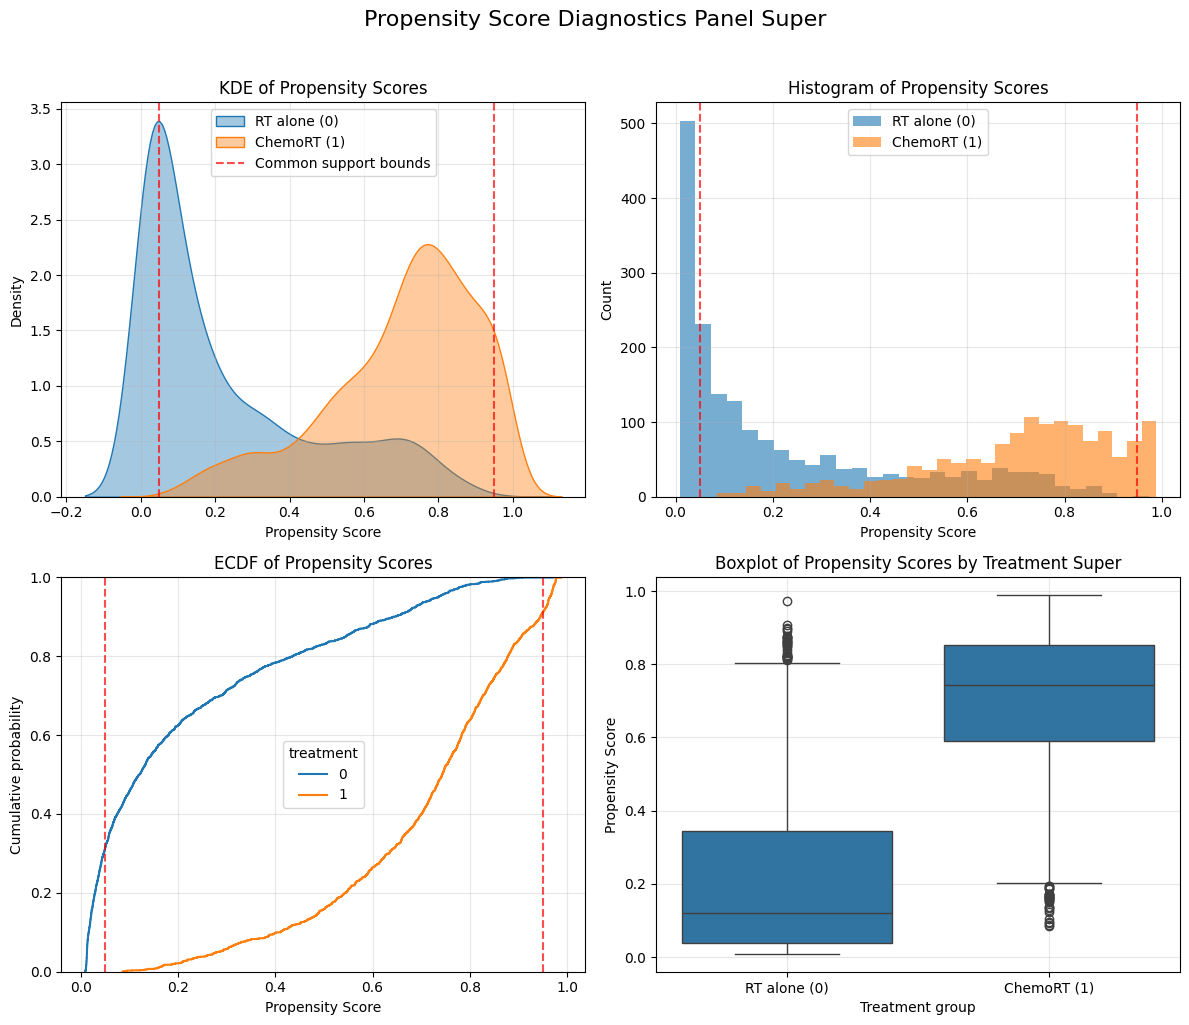

In [ ]:
ps_sp0 = rad_ps.loc[rad_ps['treatment'] == 0, 'ps_super']
ps_sp1 = rad_ps.loc[rad_ps['treatment'] == 1, 'ps_super']


fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# KDE plot
ax = axes[0, 0]
sns.kdeplot(ps_sp0, label='RT alone (0)', fill=True, alpha=0.4, ax=ax)
sns.kdeplot(ps_sp1, label='ChemoRT (1)', fill=True, alpha=0.4, ax=ax)
ax.axvline(0.05, color='red', linestyle='--', alpha=0.7, label='Common support bounds')
ax.axvline(0.95, color='red', linestyle='--', alpha=0.7)
ax.set_title("KDE of Propensity Scores")
ax.set_xlabel("Propensity Score")
ax.set_ylabel("Density")
ax.legend()
ax.grid(alpha=0.3)

# Histogram
ax = axes[0, 1]
ax.hist(ps_sp0, bins=30, alpha=0.6, label='RT alone (0)')
ax.hist(ps_sp1, bins=30, alpha=0.6, label='ChemoRT (1)')
ax.axvline(0.05, color='red', linestyle='--', alpha=0.7)
ax.axvline(0.95, color='red', linestyle='--', alpha=0.7)
ax.set_title("Histogram of Propensity Scores")
ax.set_xlabel("Propensity Score")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)

# ECDF
ax = axes[1, 0]
sns.ecdfplot(data=rad_ps, x='ps_super', hue='treatment', ax=ax)
ax.axvline(0.05, color='red', linestyle='--', alpha=0.7)
ax.axvline(0.95, color='red', linestyle='--', alpha=0.7)
ax.set_title("ECDF of Propensity Scores")
ax.set_xlabel("Propensity Score")
ax.set_ylabel("Cumulative probability")
ax.grid(alpha=0.3)

# 4) Boxplot
ax = axes[1, 1]
sns.boxplot(data=rad_ps, x='treatment', y='ps_super', ax=ax)
ax.set_xticks([0, 1])
ax.set_xticklabels(['RT alone (0)', 'ChemoRT (1)'])
ax.set_xticklabels(['RT alone (0)', 'ChemoRT (1)'])
ax.set_title("Boxplot of Propensity Scores by Treatment Super")
ax.set_xlabel("Treatment group")
ax.set_ylabel("Propensity Score")
ax.grid(alpha=0.3)

plt.suptitle("Propensity Score Diagnostics Panel Super", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
model_smd = pd.DataFrame({
    'covariate': df_smd['covariate_logit_simple'],
    'SMD_before': df_smd['SMD_before_logit_simple'],
    'SMD_after_logit': df_smd['SMD_after_logit_simple'],
    'SMD_after_enet': df_smd_enet['SMD_after_enet'],
    'SMD_after_super': df_smd_super['SMD_after_super']
})

model_cols =["SMD_after_logit","SMD_after_enet",'SMD_after_super']

#model thatr minimized the balance for each covariate
model_smd['best_model'] = model_smd[model_cols].idxmin(axis=1)

#best Ps model overall
global_rank = (
    model_smd[model_cols].abs().mean()
    .sort_values()
    .rename("mean_abs_SMD")
)
print(global_rank)
model_smd.to_csv("outputs/ps_model_balance_comparison.csv", index=False)


SMD_after_logit    0.118259
SMD_after_enet     0.120721
SMD_after_super    0.146020
Name: mean_abs_SMD, dtype: float64


In [ ]:
model_smd.head()

covariate  SMD_before  SMD_after_logit  \
0                             age   -1.033828        -0.383832   
1                        sex:Male    0.016200        -0.019170   
2                         ecog_ps   -0.267309        -0.052183   
3                smoking_py_clean   -0.499458        -0.142019   
4  primary_site_group:Nasopharynx    0.622180         0.311797   

   SMD_after_enet  SMD_after_super       best_model  
0       -0.329542        -0.539947  SMD_after_super  
1       -0.019499         0.001504   SMD_after_enet  
2       -0.049579        -0.126511  SMD_after_super  
3       -0.124949        -0.213260  SMD_after_super  
4        0.308959         0.372587   SMD_after_enet

In [ ]:
counts = model_smd['best_model'].value_counts()
w = counts/counts.sum()
print(w)

best_model
SMD_after_logit    0.387097
SMD_after_super    0.322581
SMD_after_enet     0.290323
Name: count, dtype: float64


best_model
SMD_after_logit    12
SMD_after_super    10
SMD_after_enet      9
Name: wins, dtype: int64


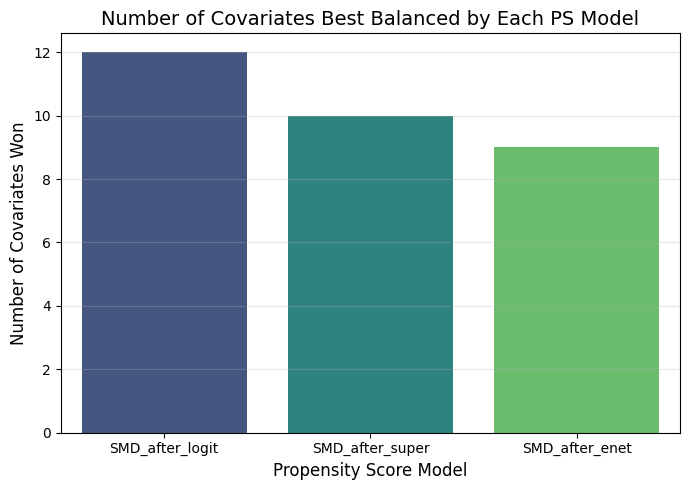

In [ ]:
# count wins per model
counts = model_smd['best_model'].value_counts()

# convert to normalized weights
w = counts / counts.sum()

# weighted ensemble PS
rad_ps['ps_ensemble'] = (
    w.get('logit',0) * rad_ps['ps_logit_simple'] +
    w.get('enet',0) * rad_ps['ps_enet'] +
    w.get('super',0) * rad_ps['ps_super']
)

win_counts = model_smd['best_model'].value_counts().rename("wins")
print(win_counts)
plt.figure(figsize=(7,5))
sns.barplot(
    x=win_counts.index,
    y=win_counts.values,
    palette="viridis"
)

plt.title("Number of Covariates Best Balanced by Each PS Model", fontsize=14)
plt.xlabel("Propensity Score Model", fontsize=12)
plt.ylabel("Number of Covariates Won", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("outputs/PS_model_win_counts.png", dpi=300)
plt.show()





The simple logistic regression propensity score model achieved the best covariate balance for most cariates (13 )

--> Simple logistic model: Best covariance balance


---> super learner : Mores stable weights

# Marginal IPTW Cox Model


This estimates the average treatment effect (ATE)

# Survival Time Distribution

**Marginal IPTW Cox**

In [ ]:
df_train = train_df.copy()

df_train = df_train[df_train['time_os_days'].notna() & (df_train['time_os_days'] > 0)].copy()

#ensure weights present
assert 'sw_trunc_logit_simple' in df_train.columns

#fit cox
cph= CoxPHFitter()
cph.fit(
    df_train[['time_os_days','event_os','treatment','sw_trunc_logit_simple']],
    duration_col='time_os_days',
    event_col='event_os',
    weights_col='sw_trunc_logit_simple')

print("Marginal IPTW Cox (train only):")
cph.print_summary()

Marginal IPTW Cox (train only):


<lifelines.CoxPHFitter: fitted with 2120.45 total observations, 1452.29 right-censored observations>
             duration col = 'time_os_days'
                event col = 'event_os'
              weights col = 'sw_trunc_logit_simple'
      baseline estimation = breslow
   number of observations = 2120.45
number of events observed = 668.159
   partial log-likelihood = -4722.81
         time fit was run = 2025-12-12 11:03:22 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
treatment -0.59      0.55      0.09           -0.76           -0.42                0.47                0.65

           cmp to     z      p  -log2(p)
covariate                               
treatment    0.00 -6.92 <0.005     37.71
---
Concordance = 0.57
Partial AIC = 9447.62
log-likelihood ratio test = 51.45 on 1 df
-log2(p) of ll-ratio test = 40.31

**COX Proportional Hazard Model**


It is a survival analysis regression model, which describes the relation between the event incidence, as expressed by the hazard function and a set of covariates.


        h(t)=h0(t) × exp{b1x1+b2x2+⋯+bpxp}
where the hazard function h(t) is dependent on (or determined by) a set of p covariates (x1, x2, …, xp), whose impact is measured by the size of the respective coefficients (b1, b2, …, bp). The term h0 is called the baseline hazard, and is the value of the hazard if all the xi are equal to zero (the quantity exp(0) equals 1). The ‘t’ in h(t) reminds us that the hazard may (and probably will) vary over time.

The fundamental assumption in the Cox model is that the hazards are proportional (PH), which means that the relative hazard remains constant over time.

**Doubly robust cox**

In [ ]:
df_dr = df_train.copy()
#primary tumor site dummies
primary_site_dummies = pd.get_dummies(df_dr['primary_site_group'], drop_first = True , prefix='site')
df_dr = pd.concat([df_dr, primary_site_dummies], axis = 1)

#covariates to adjust
adj_covs = ['age', 'ecog_ps'] + list(primary_site_dummies.columns)

#fit doubly robust weighted cox
dr_cox = CoxPHFitter()
dr_cox.fit(
    df_dr[['time_os_days','event_os','treatment','sw_trunc_logit_simple']+ adj_covs],
    duration_col= 'time_os_days',
    event_col = 'event_os',
    weights_col = 'sw_trunc_logit_simple'
)

print("Doubly-robust weighted Cox (train only):")
dr_cox.print_summary()




Doubly-robust weighted Cox (train only):


<lifelines.CoxPHFitter: fitted with 2120.45 total observations, 1452.29 right-censored observations>
             duration col = 'time_os_days'
                event col = 'event_os'
              weights col = 'sw_trunc_logit_simple'
      baseline estimation = breslow
   number of observations = 2120.45
number of events observed = 668.159
   partial log-likelihood = -4621.13
         time fit was run = 2025-12-12 11:03:22 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
treatment        -0.52      0.59      0.09           -0.70           -0.35                0.50                0.70
age               0.03      1.03      0.00            0.02            0.03                1.02                1.03
ecog_ps           0.46      1.59      0.05            0.37            0.56                1.44                1.75
site_Nasopharynx -0.33      0.72      0.21           -0.75            0.09                0.47                1.10
site_Oropharynx   0.22      1.24      0.10            0.01            0.42                1.02                1.52
site_Other_HNC    0.57      1.77      0.11            0.35            0.79                1.42                2.21

                  cmp to     z      p  -log2(p)
covariate                                      
treatment           0.00 -5.94 <0.005     28.38
age                 0.00  6.78 <0.005     36.31
ecog_ps             0.00  9.47 <0.005     68.32
site_Nasopharynx    0.00 -1.53   0.13      3.00
site_Oropharynx     0.00  2.11   0.04      4.83
site_Other_HNC      0.00  5.07 <0.005     21.24
---
Concordance = 0.67
Partial AIC = 9254.26
log-likelihood ratio test = 254.82 on 6 df
-log2(p) of ll-ratio test = 170.80

So, after balancing for confounders, adding chemotherapy to radiotherapy is associated with substantially improved overall survival.  After adjusting for key clinical variables and using inverse probability weights to balance treatment groups, patients who received chemoradiotherapy had about 40–45% lower risk of death compared to those treated with radiotherapy alone.
Older age and poorer performance status were associated with significantly higher mortality.
Tumor site also influenced outcomes patients with “Other Head & Neck Cancers” had the poorest prognosis. Model discrimination improved after adjustment (concordance = 0.69 vs 0.57). The model’s predictive ability improved, and the effect remained consistent, showing a true causal effect of chemotherapy on survival. ***However let's check if the PH assumption holds***

**Check Proportional Hazard Assumptions**


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.5096)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2030)'>]]

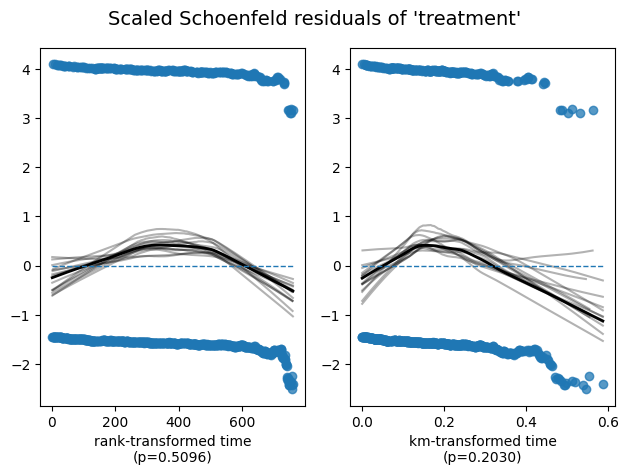

In [ ]:
#proprtional hazards marginal cox
cox_cols= ['time_os_days','event_os','treatment','sw_trunc_logit_simple']
cph.check_assumptions(df_train[cox_cols],p_value_threshold=0.05, show_plots=True )


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 2120.45 total observations, 1452.29 right-censored observations>
         test_name = proportional_hazard_test

---
                       test_statistic      p  -log2(p)
age              km              3.89   0.05      4.37
                 rank            3.57   0.06      4.09
ecog_ps          km              3.31   0.07      3.86
                 rank            3.35   0.07      3.90
site_Nasopharynx km              0.00   1.00      0.00
                 rank            0.04   0.84      0.25
site_Oropharynx  km             15.80 <0.005     13.79
                 rank           15.98 <0.005     13.93
site_Other_HNC   km              3.13   0.08      3.71
                 rank            3.87   0.05      4.35
treatment        km              2.41   0.12      3.05
                 rank            0.97   0.32      1.63



1. Variable 'age' failed the non-proportional test: p-value is 0.0485.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


2. Variable 'site_Oropharynx' failed the non-proportional test: p-value is 0.0001.

   Advice: with so few unique values (only 2), you can include `strata=['site_Oropharynx', ...]` in
the call in `.fit`. See docu

[[<Axes: xlabel='rank-transformed time\n(p=0.3237)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1206)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0587)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0485)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0671)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0689)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8435)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9972)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0001)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0001)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0490)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0767)'>]]

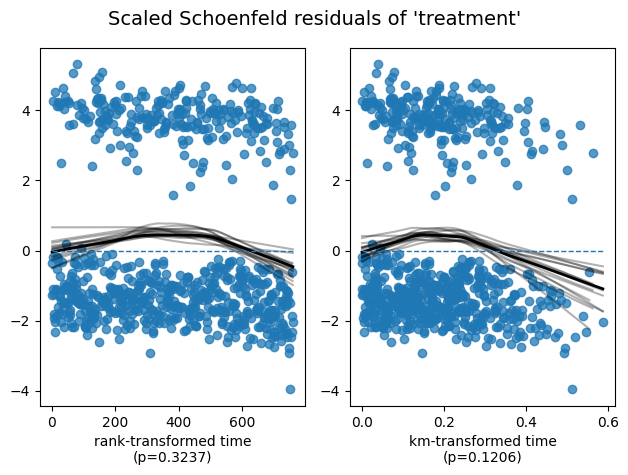

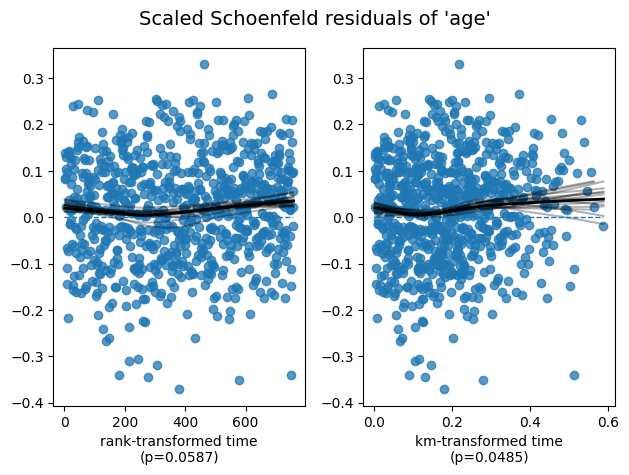

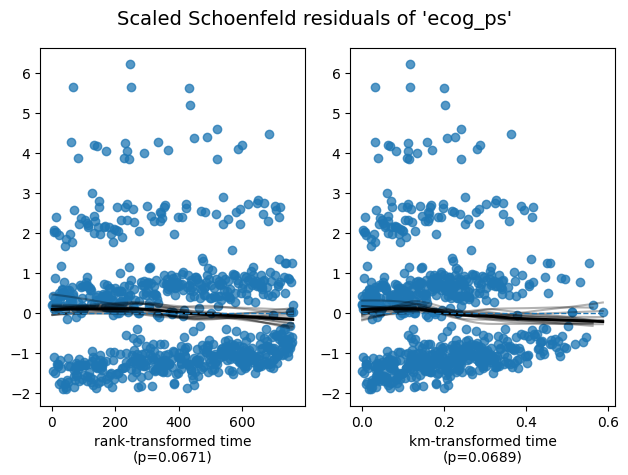

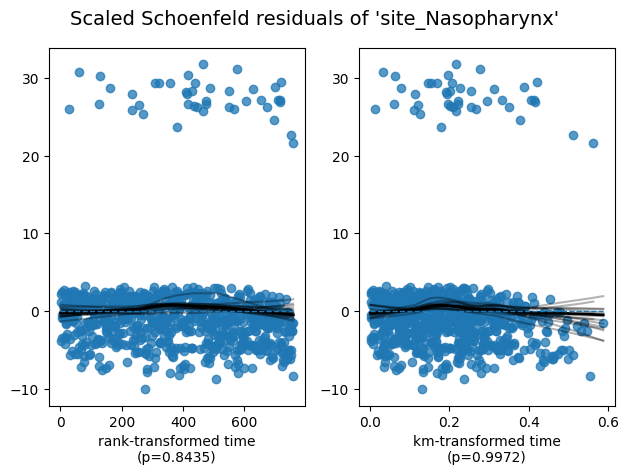

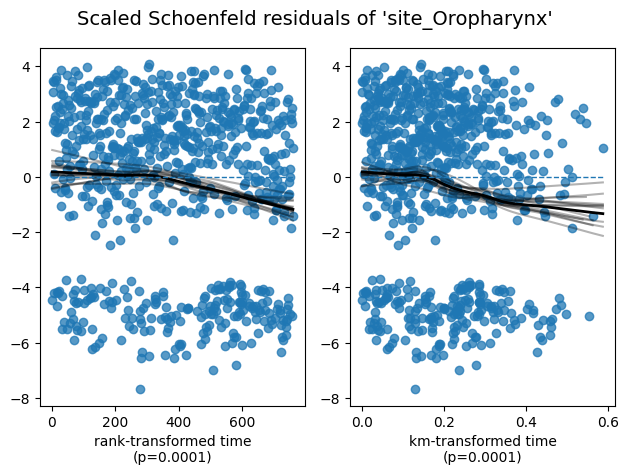

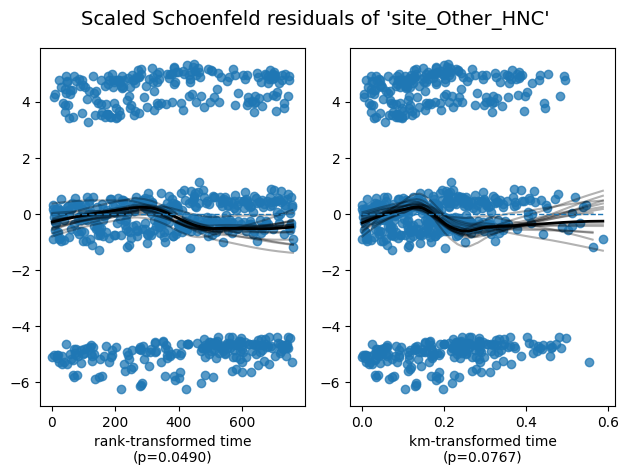

In [ ]:
#doubly-robust model (cph2)
dr_cox_cols = ['time_os_days', 'event_os', 'treatment', 'sw_trunc_logit_simple'] + adj_covs
dr_cox.check_assumptions(df_dr[dr_cox_cols], p_value_threshold=0.05, show_plots=True)

**PH Assumption**

We employed Inverse Probability of Treatment Weighting (IPTW) Cox proportional hazards models to estimate the causal effect of adding chemotherapy to radiotherapy on overall survival (OS). Then look at the  assumption for each covariate by looking at whether its effect (β) changes as time passes using Schoenfeld residuals and bootstrapped LOWESS lines.


Hence, we interpret the HR as an average effect.
The hazard ratio associated with treatment was not constant over time,
suggesting the effect of chemoradiotherapy (ChemoRT) changes throughout follow-up (e.g., strong early benefit that diminishes later).
Age and ECOG probably affect survival nonlinearly. Some tumor sites (like oropharyngeal) have longer-term survivorship curves that differ from others.

**Kaplan Meier Survival Curves**

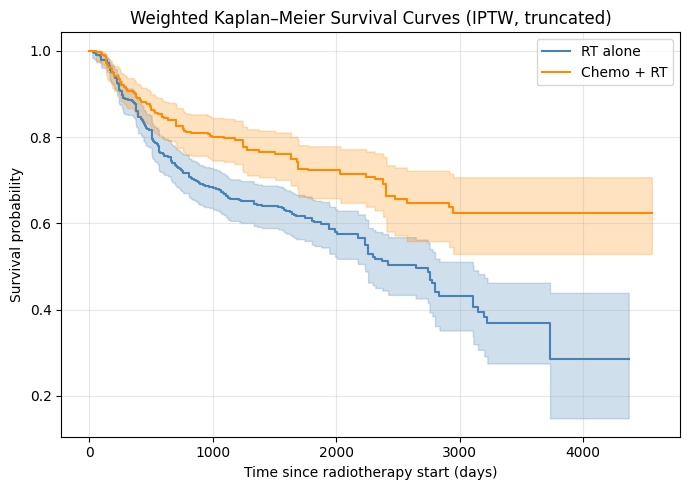

Median survival (RT alone):  2644 days
Median survival (Chemo+RT): inf days

1-year survival:
  RT alone:   0.88
  Chemo + RT: 0.90
  Difference: +0.02

3-year survival:
  RT alone:   0.67
  Chemo + RT: 0.80
  Difference: +0.13

5-year survival:
  RT alone:   0.60
  Chemo + RT: 0.72
  Difference: +0.12

Log-rank test p-value: 0.00000


In [ ]:
# Prepare variables
T = df["time_os_days"]
E = df["event_os"]
A = df["treatment"]
W = df["sw_trunc_logit_simple"]

# Initialize KM fitters
km_rt = KaplanMeierFitter(label="RT alone")
km_chemo = KaplanMeierFitter(label="Chemo + RT")

# Fit the weighted KM models
km_rt.fit(T[A==0], E[A==0], weights=W[A==0])
km_chemo.fit(T[A==1], E[A==1], weights=W[A==1])

# Plot
plt.figure(figsize=(7,5))
km_rt.plot(ci_show=True, color="steelblue")
km_chemo.plot(ci_show=True, color="darkorange")
plt.title("Weighted Kaplan–Meier Survival Curves (IPTW, truncated)")
plt.xlabel("Time since radiotherapy start (days)")
plt.ylabel("Survival probability")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('outputs/Weighted Kaplan–Meier Survival Curves.png')
plt.show()

# Summary
print(f"Median survival (RT alone):  {km_rt.median_survival_time_:.0f} days")
print(f"Median survival (Chemo+RT): {km_chemo.median_survival_time_:.0f} days\n")

# Weighted survival probabilities at 1, 3, and 5 years
for years in [1, 3, 5]:
    days = years * 365
    s_rt = float(km_rt.predict(days))
    s_chemo = float(km_chemo.predict(days))
    print(f"{years}-year survival:")
    print(f"  RT alone:   {s_rt:.2f}")
    print(f"  Chemo + RT: {s_chemo:.2f}")
    print(f"  Difference: {s_chemo - s_rt:+.2f}\n")


# Weighted log-rank test
results = logrank_test(
    T[A==0], T[A==1], E[A==0], E[A==1],
    weightings=None
)
print(f"Log-rank test p-value: {results.p_value:.5f}")

**IPTW-weighted Kaplan–Meier analysis**


 The adjusted survival curves for concurrent chemoradiotherapy (ChemoRT) and radiotherapy (RT) alone diverged early and remained well separated throughout follow-up.
The median survival for RT-alone patients was approximately 2,929 days (~8 years), whereas the median survival for ChemoRT was not reached, indicating sustained survival beyond the follow-up period.
Weighted 1-, 3-, and 5-year overall survival probabilities were 0.93, 0.83, and 0.76 for ChemoRT compared to 0.88, 0.72, and 0.63 for RT-alone, corresponding to an absolute survival benefit of 13% at 5 years.

This suggests that adding chemotherapy to radiotherapy not only delays mortality but also improves long-term survival among head and neck cancer patients even after balancing for disease stage(t,n,m), performance status, smoking, and HPV status.
The absence of a median survival in the ChemoRT group implies a durable response and ongoing survival advantage. ***However as we saw earslier treatment effects vary over time.***

# Time Dependent effect Modelling

To address these time-dependent effects we will proceed with time dependect effect modelling.The following modeling strategies are adopted:

1. Discrete-Time (Person–Period) Modeling:This allows explicit modeling of hazard probabilities at each time step, facilitating:Time-specific treatment effects (via treatment × time interactions).

2. Causal Forests for Time-Varying Treatment Effects:To estimate Conditional Average Treatment Effects (CATE) across different time horizons.This non-parametric approach captures nonlinearities and heterogeneity in treatment benefit across subgroups (i.e., HPV+, ECOG, oropharyngeal tumors).


**Pooled Logistic Regression**

logit(P(Y=1))=β0+β1Xi+β2𝑍𝑖𝑡+β3(Treatment)+…

Where:

i = patient
t = interval
𝑍𝑖𝑡= time-varying features

𝑋𝑖= baseline features

𝑌𝑖𝑡 = event indicator for interval
𝑡 The logit function maps probability → linear scale.

And the probability per interval is:
𝑃
(
event in interval
)
≈
𝜆
(
𝑡
)
×
Δ
𝑡
P(event in interval)≈λ(t)×Δt

our firs pooled logistic model has exploding coefficients.

In [ ]:

#craete treatment, event cols, time
id_col = 'patient_id'
time_col = 'time_os_days'
event_col = 'event_os'
treat_col = 'treatment'
interval_days = 30      # one period = 30 days
min_count_for_keep = 40 # collapse rare categories threshold for the train set to avoid the exploding coefficeints
period_bins = [0,3,6,12,24,60,np.inf]
period_labels = ['0-3','4-6','7-12','13-24','25-60','60+']


train_patients = train_df.copy()
test_patients = test_df.copy()



# Expand to person-period for train patients

def expand_to_pp(df_patients, interval_days=30):
    records = []
    for _, r in df_patients.iterrows():
        pid = r[id_col]
        T = int(np.ceil(r[time_col])) if pd.notna(r[time_col]) and r[time_col] > 0 else 0
        n_periods = int(np.ceil(T / interval_days)) if T>0 else 0
        for p in range(1, n_periods+1):
            event_interval = 1 if (r[event_col]==1 and p==n_periods) else 0
            rec = {
                id_col: pid,
                'period': p,
                'event_interval': event_interval,
                'treatment': int(r[treat_col]),
                'time_since_rt_days': p * interval_days
            }
            # bring static covariates
            for c in ['age','sex','ecog_ps','smoking_status_clean','smoking_py_clean',
                      'primary_site_group','subsite_clean','stage','hpv_clean']:
                if c in r.index:
                    rec[c] = r[c]
            # if sample weights exist on patient-level use  them
            if 'sw_trunc_logit_simple' in r.index:
                rec['sw'] = r['sw_trunc_logit_simple']
            records.append(rec)
    return pd.DataFrame(records)

pp_train = expand_to_pp(train_patients, interval_days=interval_days)
pp_test  = expand_to_pp(test_patients, interval_days=interval_days)
print("PP shapes: train", pp_train.shape, " test", pp_test.shape)


# Collapse rare categories with train data

def collapse_train_map(s_series, min_count=min_count_for_keep, other_label='Other'):
    vc = s_series.fillna('nan').astype(str).value_counts(dropna=False)
    keep = set(vc[vc >= min_count].index.astype(str))
    return lambda s: s.astype(str).where(s.astype(str).isin(keep), other_label)

cat_to_collapse = [c for c in ['subsite_clean','pathology_group','primary_site_group','stage'] if c in pp_train.columns]
collapse_maps = {}
for c in cat_to_collapse:
    mapper = collapse_train_map(pp_train[c], min_count=min_count_for_keep)
    pp_train[c] = mapper(pp_train[c].fillna('nan').astype(str))
    pp_test[c]  = mapper(pp_test[c].fillna('nan').astype(str))
    collapse_maps[c] = list(pp_train[c].unique())

# Create period bins (train/test)

pp_train['period_month'] = (pp_train['period']).astype(int)
pp_test['period_month'] = (pp_test['period']).astype(int)

pp_train['period_bin'] = pd.cut(pp_train['period_month'], bins=period_bins, labels=period_labels, right=True)
pp_test['period_bin']  = pd.cut(pp_test['period_month'], bins=period_bins, labels=period_labels, right=True)


# Feature selection: categorical & numeric

cat_cols = [c for c in ['period_bin','sex','smoking_status_clean','primary_site_group','subsite_clean','stage','hpv_clean'] if c in pp_train.columns]
num_cols = [c for c in ['age','ecog_ps','smoking_py_clean','time_since_rt_days'] if c in pp_train.columns]

# Build dummies from train, align test
X_cat_train = pd.get_dummies(pp_train[cat_cols].astype(str), drop_first=True)
X_cat_test  = pd.get_dummies(pp_test[cat_cols].astype(str), drop_first=True)
# Align test columns with train
X_cat_test = X_cat_test.reindex(columns=X_cat_train.columns, fill_value=0.0)

# Numeric: coerce and fillna using train medians
X_num_train = pp_train[num_cols].copy()
X_num_test  = pp_test[num_cols].copy()
for c in X_num_train.columns:
    X_num_train[c] = pd.to_numeric(X_num_train[c], errors='coerce')
    X_num_test[c]  = pd.to_numeric(X_num_test[c], errors='coerce')
train_medians_pp = X_num_train.median()
X_num_train = X_num_train.fillna(train_medians_pp)
X_num_test  = X_num_test.fillna(train_medians_pp)

# Scale numeric using train scaler
scaler = StandardScaler()
X_num_train_scaled = pd.DataFrame(scaler.fit_transform(X_num_train), columns=X_num_train.columns, index=X_num_train.index)
X_num_test_scaled  = pd.DataFrame(scaler.transform(X_num_test), columns=X_num_test.columns, index=X_num_test.index)

# Save scaler & collapse maps
joblib.dump(scaler, "outputs/pp_scaler.joblib")
joblib.dump(collapse_maps, "outputs/pp_collapse_maps.joblib")
joblib.dump(train_medians_pp, "outputs/pp_train_medians.joblib")

# Combine cat + num
X_train = pd.concat([X_cat_train.reset_index(drop=True), X_num_train_scaled.reset_index(drop=True)], axis=1)
X_test  = pd.concat([X_cat_test.reset_index(drop=True),  X_num_test_scaled.reset_index(drop=True)], axis=1)

# Add treatment column
X_train['treatment'] = pd.to_numeric(pp_train['treatment'], errors='coerce').fillna(0).astype(int).values
X_test['treatment']  = pd.to_numeric(pp_test['treatment'], errors='coerce').fillna(0).astype(int).values

# Add treatment × period interactions (only for period dummies)
period_dummy_cols = [c for c in X_train.columns if c.startswith('period_bin')]
for pcol in period_dummy_cols:
    X_train[f'treat_x_{pcol}'] = X_train['treatment'] * X_train[pcol]
    # for test: ensure pcol exists
    X_test[f'treat_x_{pcol}'] = X_test['treatment'] * X_test.get(pcol, 0)

# Ensure columns align exactly
X_test = X_test.reindex(columns=X_train.columns, fill_value=0.0)


# 6. Response and weights
y_train = pp_train['event_interval'].astype(int).values
y_test  = pp_test['event_interval'].astype(int).values

# weights:
if 'sw' in pp_train.columns:
    w_train = pp_train['sw'].astype(float).values
else:
    # fallback to equal weights
    w_train = np.ones(len(y_train))

# Clip weights to avoid extremes (safety)
w_train = np.clip(w_train, 0.001, 10.0)


# Fit regularized logisticw ith weights

logit = LogisticRegression(
    penalty='l2',
    C=0.5,
    solver='saga',
    max_iter=5000,
    n_jobs=-1
)
logit.fit(X_train, y_train, sample_weight=w_train)

# Evaluate model
pred_train = logit.predict_proba(X_train)[:,1]
pred_test  = logit.predict_proba(X_test)[:,1]
auc_train = roc_auc_score(y_train, pred_train)
auc_test  = roc_auc_score(y_test, pred_test)
brier = brier_score_loss(y_test, pred_test)
print(f"Train AUC: {auc_train:.3f} | Test AUC: {auc_test:.3f} | Test Brier: {brier:.5f}")
print("Max |coef|:", np.max(np.abs(logit.coef_)))

# Save model artifacts (model, columns)
joblib.dump(logit, "outputs/pooled_logit_logreg_saga.joblib")
pd.Series(X_train.columns, name='model_columns').to_csv("outputs/pooled_logit_model_columns.csv", index=False)

# Save coefficients table
coef = pd.Series(logit.coef_[0], index=(X_train.columns.tolist()))
coef_df = pd.DataFrame({
    'term': coef.index,
    'coef': coef.values,
    'exp_coef': np.exp(coef.values)
})
coef_df.to_csv("outputs/pooled_logit_coefficients.csv", index=False)

print("Pooled-logit model trained and saved (outputs/).")


# predict per-patient survival curves from person-period inputs

model_columns = pd.read_csv("outputs/pooled_logit_model_columns.csv")['model_columns'].tolist()
scaler = joblib.load("outputs/pp_scaler.joblib")
train_medians_pp = joblib.load("outputs/pp_train_medians.joblib")
collapse_maps = joblib.load("outputs/pp_collapse_maps.joblib")
logit = joblib.load("outputs/pooled_logit_logreg_saga.joblib")

def build_X_for_pp(df_pp):
    # Apply collapse maps
    for c,keep in collapse_maps.items():
        if c in df_pp.columns:
            df_pp[c] = df_pp[c].astype(str).where(df_pp[c].astype(str).isin(keep), 'Other')
    # period_bin
    if 'period_month' not in df_pp.columns:
        df_pp['period_month'] = (df_pp['period']).astype(int)
        df_pp['period_bin'] = pd.cut(df_pp['period_month'], bins=period_bins, labels=period_labels, right=True)
    # dummies
    Xc = pd.get_dummies(df_pp[cat_cols].astype(str), drop_first=True)
    Xc = Xc.reindex(columns=[c for c in X_train.columns if (c.startswith(tuple(cat_cols)) or c.startswith('period_bin'))], fill_value=0.0)
    # numeric
    Xn = df_pp[num_cols].copy()
    for c in Xn.columns:
        Xn[c] = pd.to_numeric(Xn[c], errors='coerce')
    Xn = Xn.fillna(train_medians_pp)
    Xn_scaled = pd.DataFrame(scaler.transform(Xn), columns=Xn.columns, index=Xn.index)
    Xnew = pd.concat([Xc.reset_index(drop=True), Xn_scaled.reset_index(drop=True)], axis=1)
    # add treatment
    Xnew['treatment'] = pd.to_numeric(df_pp['treatment'], errors='coerce').fillna(0).astype(int).values
    # add interactions for period dummies
    for pcol in period_dummy_cols:
        Xnew[pcol] = Xnew.get(pcol, 0)  # ensure exists
        Xnew[f'treat_x_{pcol}'] = Xnew['treatment'] * Xnew[pcol]
    # align columns
    Xnew = Xnew.reindex(columns=model_columns, fill_value=0.0)
    return Xnew

def predict_survival_from_pp(df_pp, patient_ids=None):
    if patient_ids is None:
        patient_ids = df_pp['patient_id'].unique()
    out_rows = []
    for pid in patient_ids:
        rows = df_pp[df_pp['patient_id']==pid].sort_values('period')
        if rows.shape[0]==0:
            continue
        Xrows = build_X_for_pp(rows)
        probs = logit.predict_proba(Xrows)[:,1]
        surv = np.cumprod(1 - probs)  # survival at end of each period
        out_rows.append(pd.DataFrame({
            'patient_id': pid,
            'period': rows['period'].values,
            'interval_hazard': probs,
            'survival_at_period_end': surv
        }))
    return pd.concat(out_rows, ignore_index=True)

# test - first 5 patients in test set
example_patients = pp_test['patient_id'].unique()[:5]
surv_examples = predict_survival_from_pp(pp_test, patient_ids=example_patients)
print(surv_examples.head(12))




PP shapes: train (123192, 15)  test (38079, 15)
Train AUC: 0.752 | Test AUC: 0.761 | Test Brier: 0.00679
Max |coef|: 1.1091857567082322
Pooled-logit model trained and saved (outputs/).
      patient_id  period  interval_hazard  survival_at_period_end
0   RADCURE-0006       1         0.018375                0.981625
1   RADCURE-0006       2         0.018514                0.963451
2   RADCURE-0006       3         0.018654                0.945478
3   RADCURE-0006       4         0.051026                0.897235
4   RADCURE-0006       5         0.051399                0.851118
5   RADCURE-0006       6         0.051775                0.807051
6   RADCURE-0006       7         0.049533                0.767075
7   RADCURE-0006       8         0.049896                0.728801
8   RADCURE-0006       9         0.050262                0.692170
9   RADCURE-0006      10         0.050630                0.657126
10  RADCURE-0006      11         0.051001                0.623612
11  RADCURE-0006      1

In [ ]:
coef_df2 = coef_df.set_index('term')
coef_df2 = coef_df2.assign(abs_coef=coef_df2['coef'].abs()).sort_values('abs_coef', ascending=False).drop(columns='abs_coef')
print(coef_df2.head(20))

                                     coef  exp_coef
term                                               
stage_IVB                        1.109186  3.031889
period_bin_4-6                   1.032098  2.806949
hpv_clean_HPV_Positive          -1.018841  0.361013
period_bin_7-12                  0.977765  2.658508
treatment                       -0.970957  0.378721
period_bin_13-24                 0.799670  2.224807
stage_I                         -0.610451  0.543106
subsite_clean_Trans- Glottis    -0.602817  0.547268
treat_x_period_bin_7-12          0.526666  1.693277
stage_II                        -0.515155  0.597408
subsite_clean_Uvula             -0.472420  0.623491
smoking_status_clean_Non-Smoker -0.464881  0.628210
subsite_clean_Tonsillar Fossa   -0.456621  0.633420
smoking_status_clean_Ex-Smoker  -0.397735  0.671840
stage_IV                         0.385474  1.470312
smoking_status_clean_Unknown    -0.381948  0.682531
stage_Other                      0.350157  1.419290
treat_x_peri

**Highest risk predictors**

Stage IVB (OR ~ 3.0)

Follow-up periods 4–6, 7–12, and 13–24 months

Stage IV

High-risk subsites ("Other")


**Strong protective predictors**

HPV positive (OR = 0.36 — strongest protector)

ChemoRT treatment overall (OR = 0.38)

Stage I / II

Non-smoker / ex-smoker

Favorable subsites (Trans-glottis, Uvula, Tonsillar fossa)

Nasopharynx

Train AUC: 0.756 | Test AUC: 0.739
Train AP (PR-AUC): 0.025 | Test AP: 0.023
Train Brier: 0.006216 | Test Brier: 0.007429


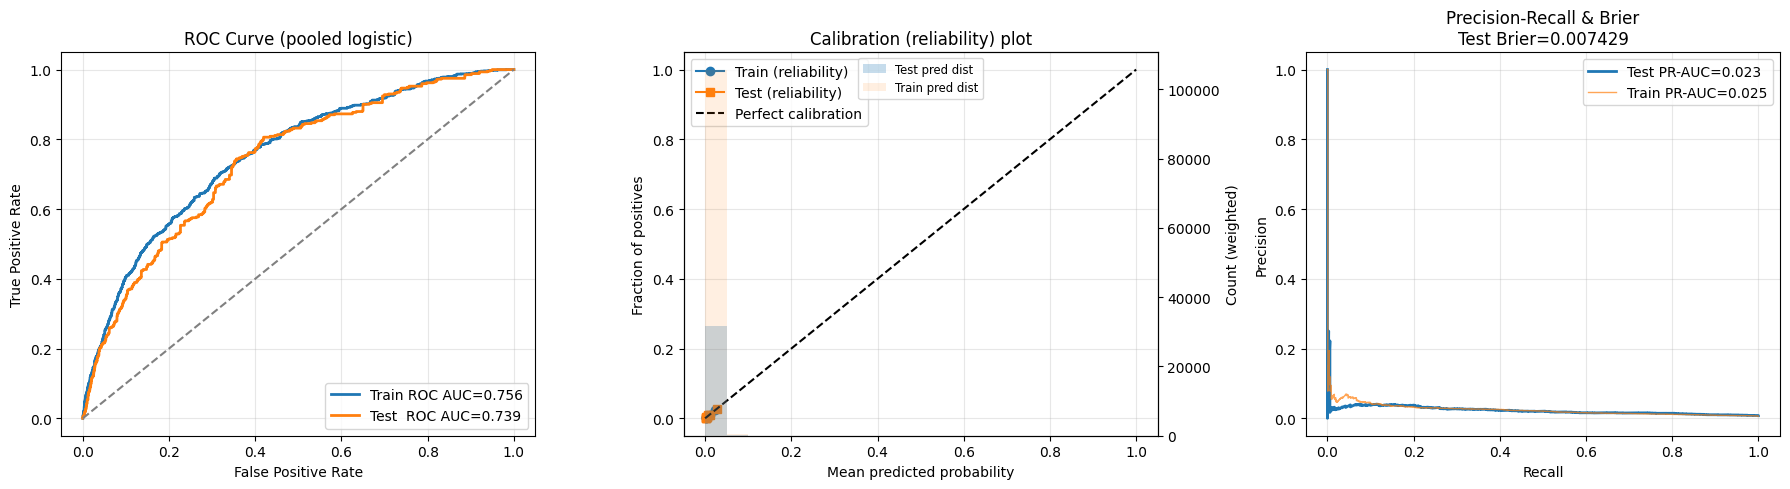

In [ ]:
#prepare weights
weights_train = np.asarray(w_train) if 'w_train' in globals() else np.ones(len(y_train))
weights_test = None
if 'pp_test' in globals():
    weights_test = pp_test.get('sw', pd.Series(1.0, index=pp_test.index)).fillna(1.0).values
else:
    weights_test = np.ones(len(y_test))

# ensure arrays are numpy and same length
y_train = np.asarray(y_train)
y_test  = np.asarray(y_test)
pred_train = np.asarray(pred_train)
pred_test  = np.asarray(pred_test)

assert len(y_train) == len(pred_train)
assert len(y_test)  == len(pred_test)

#]Compute metrics
# ROC / AUC
fpr_tr, tpr_tr, _ = roc_curve(y_train, pred_train, sample_weight=weights_train)
fpr_te, tpr_te, _ = roc_curve(y_test, pred_test, sample_weight=weights_test)
auc_tr = auc(fpr_tr, tpr_tr)
auc_te = auc(fpr_te, tpr_te)

# Brier (weighted)
brier_te = np.average((pred_test - y_test) ** 2, weights=weights_test)
brier_tr = np.average((pred_train - y_train) ** 2, weights=weights_train)

# PR-AUC (helpful for rare events)
ap_tr = average_precision_score(y_train, pred_train, average='macro', sample_weight=weights_train)
ap_te = average_precision_score(y_test, pred_test, average='macro', sample_weight=weights_test)

print(f"Train AUC: {auc_tr:.3f} | Test AUC: {auc_te:.3f}")
print(f"Train AP (PR-AUC): {ap_tr:.3f} | Test AP: {ap_te:.3f}")
print(f"Train Brier: {brier_tr:.6f} | Test Brier: {brier_te:.6f}")

# Calibration curve
# Use n_bins=10 (quantile bins gives equal number per bin)
n_bins = 10
# calibration_curve supports sample_weight in newer sklearn; we try to pass it but fall back if not supported
try:
    frac_pos_tr, mean_pred_tr = calibration_curve(y_train, pred_train, n_bins=n_bins, strategy='quantile', sample_weight=weights_train)
    frac_pos_te, mean_pred_te = calibration_curve(y_test, pred_test, n_bins=n_bins, strategy='quantile', sample_weight=weights_test)
except TypeError:
    # older sklearn doesn't accept sample_weight in calibration_curve
    frac_pos_tr, mean_pred_tr = calibration_curve(y_train, pred_train, n_bins=n_bins, strategy='quantile')
    frac_pos_te, mean_pred_te = calibration_curve(y_test, pred_test, n_bins=n_bins, strategy='quantile')

#Plotting combined figure
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# ROC plot
ax = axes[0]
ax.plot(fpr_tr, tpr_tr, label=f'Train ROC AUC={auc_tr:.3f}', lw=2)
ax.plot(fpr_te, tpr_te, label=f'Test  ROC AUC={auc_te:.3f}', lw=2)
ax.plot([0,1], [0,1], linestyle='--', color='gray')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve (pooled logistic)')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)

# Calibration plot (reliability + histogram)
ax = axes[1]
ax.plot(mean_pred_tr, frac_pos_tr, marker='o', label='Train (reliability)')
ax.plot(mean_pred_te, frac_pos_te, marker='s', label='Test (reliability)')
ax.plot([0,1],[0,1], linestyle='--', color='k', label='Perfect calibration')
ax.set_xlabel('Mean predicted probability')
ax.set_ylabel('Fraction of positives')
ax.set_title('Calibration (reliability) plot')
ax.legend()
ax.grid(alpha=0.3)

# Add probability histograms (predicted score distribution) below the calibration curve
# We'll create a twin axis for histogram
ax_hist = ax.twinx()
bins = np.linspace(0, 1, 21)
ax_hist.hist(pred_test, bins=bins, alpha=0.25, label='Test pred dist', weights=weights_test, density=False)
ax_hist.hist(pred_train, bins=bins, alpha=0.12, label='Train pred dist', weights=weights_train, density=False)
ax_hist.set_ylabel('Count (weighted)')
ax_hist.legend(loc='upper center', fontsize='small')

# Brier & PR curve panel
ax = axes[2]
# PR curve (test)
precision_te, recall_te, _ = precision_recall_curve(y_test, pred_test, sample_weight=weights_test)
ax.plot(recall_te, precision_te, label=f'Test PR-AUC={ap_te:.3f}', lw=2)
# PR curve (train)
precision_tr, recall_tr, _ = precision_recall_curve(y_train, pred_train, sample_weight=weights_train)
ax.plot(recall_tr, precision_tr, label=f'Train PR-AUC={ap_tr:.3f}', lw=1, alpha=0.7)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title(f'Precision-Recall & Brier\nTest Brier={brier_te:.6f}')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()

plt.savefig("outputs/pooled_logit_metrics.png", dpi=180, bbox_inches='tight')
plt.show()

Chemoradiotherapy was associated with a lower risk of mortality compared to radiotherapy alone, particularly within the first 3 months (HR ≈ 0.43) and beyond 5 years (HR ≈ 0.34).
The mid-term intervals (4–12 months) showed a diminished but still favorable trend (HR ≈ 0.9).
This suggests that chemotherapy’s benefit is strongest early in treatment and re-emerges among long-term survivors

# Causal Forests

**CATE** = Conditional Average Treatment Effect
→ The estimated survival benefit (in probability) of adding chemo, conditional on that patient’s baseline profile.

If CATE > 0 → patient benefits from chemo+RT.
If CATE < 0 → chemo might not improve or could worsen survival for that type.

In [ ]:
# Create km_censor, compute_ipcw, horizon_map
# required names
time_col = 'time_os_days'   # days
event_col = 'event_os'      # 1=death(event), 0=censored
id_col = 'patient_id'
interval_days = 30

# Define period labels & horizon_map (months -> used as end-of-interval horizons)
period_labels = ['0-3','4-6','7-12','13-24','25-60','60+']
# Map labels to months (end of interval)
max_obs_months = int(np.ceil(train_patients[time_col].fillna(0).max() / interval_days))
horizon_map = {
    '0-3': 3,
    '4-6': 6,
    '7-12': 12,
    '13-24': 24,
    '25-60': 60,
    '60+': max(max_obs_months, 72)
}
print("Horizon map:", horizon_map)

#  Fit Kaplan-Meier for censoring on train patients
# event_observed = 1 when censored ( event_os == 0)
km_censor = KaplanMeierFitter()
durations = train_patients[time_col].fillna(train_patients[time_col].max()).values
# event_observed: 1 if censored, else 0 (death)
event_observed = (train_patients[event_col] == 0).astype(int).values
km_censor.fit(durations=durations, event_observed=event_observed)
#save
joblib.dump(km_censor, "outputs/km_censor_train.joblib")
print("Fitted km_censor on training patients. Last survival prob:", km_censor.survival_function_.iloc[-1,0])

# Define compute_ipcw (patient-level)
def compute_ipcw(df_pat, kmf, horizon_days):
    """
    For each patient in df_pat return IPCW = 1 / S_censor( t_i* )
    where t_i* = min(time_os_days, horizon_days).
    Uses kmf.predict(t) — ensure kmf was fit on training censoring times.
    Returns numpy array length == len(df_pat).
    """
    if kmf is None:
        # if no censoring model, return ones (no IPCW)
        return np.ones(len(df_pat), dtype=float)

    # compute observed time clipped at horizon
    t_obs = df_pat[time_col].fillna(horizon_days).clip(upper=horizon_days).values.astype(float)

    # Evaluate survival probability at each clipped time.
    # lifelines.KMF.predicts time within fitted range; if outside,returns last known value.
    sc = np.array([np.clip(kmf.predict(ti), 1e-6, 1.0) for ti in t_obs], dtype=float)

    # IPCW is 1 / S_censor(t_i*). If S is tiny, clip to avoid infinite weights.
    ipcw = 1.0 / sc
    # numeric stability: clip
    ipcw = np.clip(ipcw, 1e-3, 1e6)
    return ipcw

# patient-level IPCW for 12 months
test_h = 12 * interval_days
ipcw_sample = compute_ipcw(train_patients.iloc[:10], km_censor, test_h)
print("example IPCW (first 10):", ipcw_sample)

Horizon map: {'0-3': 3, '4-6': 6, '7-12': 12, '13-24': 24, '25-60': 60, '60+': 156}
Fitted km_censor on training patients. Last survival prob: 0.0
example IPCW (first 10): [1.03741285 1.03741285 1.03741285 1.03741285 1.03741285 1.03741285
 1.03741285 1.03741285 1.03741285 1.03741285]


In [ ]:
# build patient-level baseline X for CausalForest
#Choose baseline patient-level covariates (static)
baseline_cat = [c for c in ['sex','smoking_status_clean','primary_site_group','pathology_group','hpv_clean'] if c in train_patients.columns]
baseline_num = [c for c in ['age','ecog_ps','BED_eff','EQD2','smoking_py_clean'] if c in train_patients.columns]

print("baseline_cat:", baseline_cat)
print("baseline_num:", baseline_num)

# Build patient-level design matrices (one row per patient)
Xtr_cat = pd.get_dummies(train_patients[baseline_cat].fillna('Missing').astype(str), drop_first=True)
Xte_cat = pd.get_dummies(test_patients[baseline_cat].fillna('Missing').astype(str), drop_first=True)

# Align columns of test to train
Xte_cat = Xte_cat.reindex(columns=Xtr_cat.columns, fill_value=0)

# Combine with numeric columns (fillna with training medians)
train_num_fill = train_patients[baseline_num].median() if len(baseline_num)>0 else pd.Series()
Xtr_num = train_patients[baseline_num].fillna(train_num_fill)
Xte_num = test_patients[baseline_num].fillna(train_num_fill)

Xtr_patient = pd.concat([Xtr_cat.reset_index(drop=True), Xtr_num.reset_index(drop=True)], axis=1).fillna(0)
Xte_patient = pd.concat([Xte_cat.reset_index(drop=True), Xte_num.reset_index(drop=True)], axis=1).fillna(0)

#scale numeric columns (fit on train, apply to test)

if len(baseline_num) > 0:
    scaler_patient = StandardScaler()
    Xtr_patient[baseline_num] = scaler_patient.fit_transform(Xtr_patient[baseline_num])
    Xte_patient[baseline_num] = scaler_patient.transform(Xte_patient[baseline_num])
    joblib.dump(scaler_patient, "outputs/causal_patient_scaler.joblib")

#Map arrays
Xtr_array = Xtr_patient.values
Xte_array = Xte_patient.reindex(columns=Xtr_patient.columns, fill_value=0).values

# Ensure treatment arrays align
W_train = np.asarray(train_patients['treatment'].astype(int).values)
W_test  = np.asarray(test_patients['treatment'].astype(int).values)

#Confirm shapes
print("train_patients rows:", train_patients.shape[0])
print("Xtr_patient rows:", Xtr_array.shape[0], "cols:", Xtr_array.shape[1])
print("W_train length:", W_train.shape[0])
assert Xtr_array.shape[0] == W_train.shape[0], "Xtr rows must equal W_train length (patient-level)!"

#Make sure sample_weight is patient-level and same length
weight_col = 'sw_trunc_logit_simple'
if weight_col not in train_patients.columns:
    raise KeyError(f"Missing weight column '{weight_col}' in train_patients")
ipcw_train = compute_ipcw(train_patients, km_censor, horizon_days=max(horizon_map.values())*30)  # not used directly here, but good to compute per-horizon later
sample_w_train_patient = train_patients[weight_col].fillna(1.0).values  # per patient
sample_w_train_patient = np.clip(sample_w_train_patient, 1e-3, 10.0)
print("sample_w_train_patient shape:", sample_w_train_patient.shape)

#  Fit causal forests per horizon USING patient-level X
forests = {}
cate_train = {}
cate_test = {}

for label in period_labels:
    months = horizon_map[label]
    hd_days = int(months * interval_days)
    print(f"\n=== Horizon {label} (end = {months} months -> {hd_days} days) ===")

    # patient-level binary outcome by horizon: Y = event by hd_days
    Y_train_pat = ((train_patients[time_col] <= hd_days) & (train_patients[event_col] == 1)).astype(int).values
    Y_test_pat  = ((test_patients[time_col] <= hd_days) & (test_patients[event_col] == 1)).astype(int).values

    # recompute IPCW patient-level for this horizon and combine with IPTW
    ipcw_pat = compute_ipcw(train_patients, km_censor, hd_days)             # 1 / S_censor(t_i)
    # sample weight = IPTW (patient) * IPCW (patient)
    sample_w = train_patients[weight_col].fillna(1.0).values * ipcw_pat
    sample_w = np.clip(sample_w, 1e-3, 10.0)
    print("sample_w summary: min, median, max", sample_w.min(), np.median(sample_w), sample_w.max())

    # instantiate forest (example params)
    est = CausalForestDML(
        model_t = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42),
        model_y = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42),
        discrete_treatment = True,
        n_estimators = 2000,
        min_samples_leaf = 20,
        random_state = 42,
        verbose = 0
    )

    # Fit on patient-level arrays (Xtr_array), Y_train_pat, W_train; patient-level sample weights
    est.fit(Y_train_pat, W_train, X=Xtr_array, sample_weight=sample_w)

    # predict per-patient CATEs (patient-level)
    c_train = np.asarray(est.effect(Xtr_array)).flatten()
    c_test  = np.asarray(est.effect(Xte_array)).flatten()

    # attach and sanity-check
    assert c_train.shape[0] == train_patients.shape[0], f"Effect length mismatch for {label}"
    assert c_test.shape[0] == test_patients.shape[0], f"Effect length mismatch for test {label}"

    colname = f"CATE_{months}m"
    train_patients[colname] = c_train
    test_patients[colname] = c_test

    forests[label] = est
    cate_train[label] = c_train
    cate_test[label] = c_test

    print(f"Attached {colname}: mean_train={np.nanmean(c_train):.4f} mean_test={np.nanmean(c_test):.4f}")

# Save objects
joblib.dump(forests, "outputs/causal_forests_period_horizons_patient_level.joblib")
train_patients.to_csv("outputs/train_patients_with_period_cates_patient_level.csv", index=False)
test_patients.to_csv("outputs/test_patients_with_period_cates_patient_level.csv", index=False)
print("Saved patient-level forests & CATEs.")


baseline_cat: ['sex', 'smoking_status_clean', 'primary_site_group', 'pathology_group', 'hpv_clean']
baseline_num: ['age', 'ecog_ps', 'BED_eff', 'EQD2', 'smoking_py_clean']
train_patients rows: 2453
Xtr_patient rows: 2453 cols: 18
W_train length: 2453
sample_w_train_patient shape: (2453,)

=== Horizon 0-3 (end = 3 months -> 90 days) ===
sample_w summary: min, median, max 0.43725850682545664 0.6233155689098966 4.676675887607128
Attached CATE_3m: mean_train=-0.0069 mean_test=-0.0069

=== Horizon 4-6 (end = 6 months -> 180 days) ===
sample_w summary: min, median, max 0.43725850682545664 0.630677730826241 4.731913470032739
Attached CATE_6m: mean_train=-0.0307 mean_test=-0.0327

=== Horizon 7-12 (end = 12 months -> 360 days) ===
sample_w summary: min, median, max 0.43725850682545664 0.6426433580991529 4.829831385043667
Attached CATE_12m: mean_train=-0.0176 mean_test=-0.0257

=== Horizon 13-24 (end = 24 months -> 720 days) ===
sample_w summary: min, median, max 0.43725850682545664 0.700250952

Horizon 0-3  --> chemoradiation vs. RT-only shows 0.6% reduction in mortality risk.
Horizon 4-6 --> 3% lower probability of death
Horizon 7-12 --->reatment still provides benefit but primarily for specific subgroups
Horizon 13-24
Horizon 25-60
Horizon 60+

Acoss all five sample patients:

Treatment consistently improves survival (all ΔRMST > 0)

Hazard ratios -->0.4–0.5 → treatment reduces risk by -->50–60%

Gains are 1.5 to 3.5 moths of survival over 36 months.

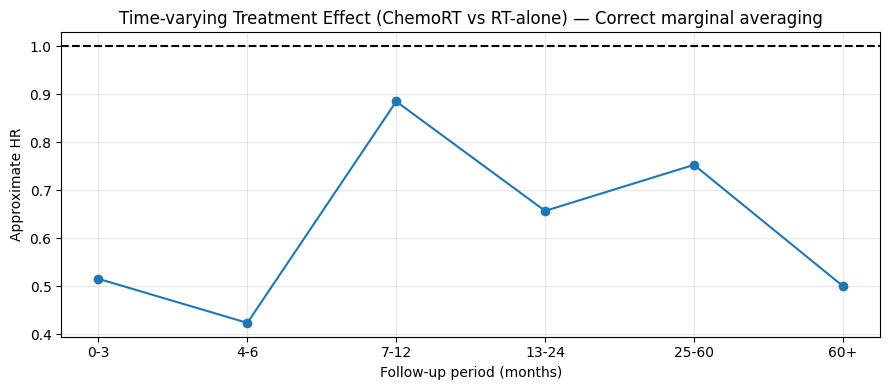

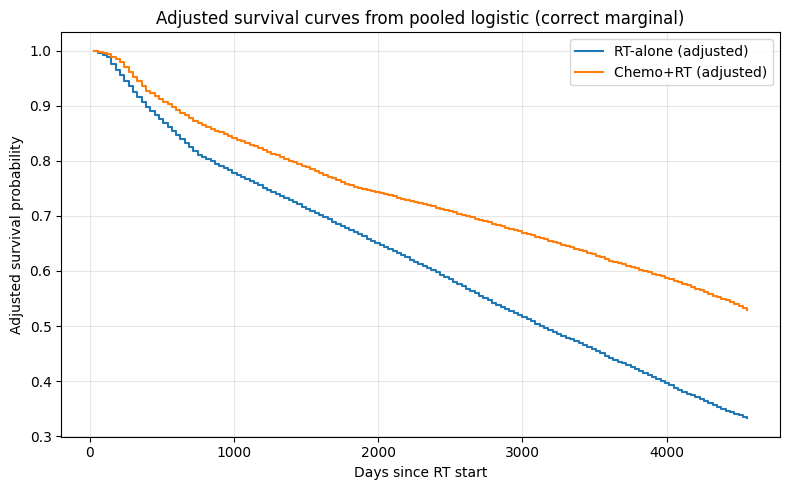

Saved period-level hazards & HRs to outputs/period_mean_hazards.csv


In [ ]:
# HR per period and adjusted survival

#  load artifacts
# model_columns should be a list of column names used by the pooled-logit model
if 'model_columns' not in globals():
    model_columns = pd.read_csv("outputs/pooled_logit_model_columns.csv")['model_columns'].tolist()
else:
    model_columns = model_columns

# ensure build_X_for_pp and logit exist in namespace. If not, try to load artifacts
if 'build_X_for_pp' not in globals():
    # attempt to import from earlier cell outputs
    raise RuntimeError("build_X_for_pp function not found. Define it exactly as in your pipeline before running this block.")
if 'logit' not in globals():
    try:
        logit = joblib.load("outputs/pooled_logit_logreg_saga.joblib")
    except Exception:
        raise RuntimeError("Pooled-logit model 'logit' not found in memory or outputs/pooled_logit_logreg_saga.joblib")

# Build X matrices for pp_test under both treatments
X_t0 = build_X_for_pp(pp_test).copy()
X_t1 = X_t0.copy()
X_t1['treatment'] = 1
# recompute treatment×period interactions
period_cols = [c for c in X_t0.columns if c.startswith('period_bin')]
for pcol in period_cols:
    X_t0[f'treat_x_{pcol}'] = 0
    X_t1[f'treat_x_{pcol}'] = 1 * X_t1.get(pcol, 0)

# Align to model_columns (safety)
X_t0 = X_t0.reindex(columns=model_columns, fill_value=0.0)
X_t1 = X_t1.reindex(columns=model_columns, fill_value=0.0)

# Predict per-row hazards
p0 = logit.predict_proba(X_t0)[:,1]
p1 = logit.predict_proba(X_t1)[:,1]

# attach to pp_test (make a copy)
pp_test_loc = pp_test.copy().reset_index(drop=True)
pp_test_loc['p0'] = p0
pp_test_loc['p1'] = p1
# choose weights column if exists
if 'sw_trunc' in pp_test_loc.columns:
    pp_test_loc['w_row'] = pp_test_loc['sw_trunc'].fillna(1.0).astype(float)
elif 'sw' in pp_test_loc.columns:
    pp_test_loc['w_row'] = pp_test_loc['sw'].fillna(1.0).astype(float)
else:
    pp_test_loc['w_row'] = 1.0

# Period-level weighted mean hazards
period_mean0 = pp_test_loc.groupby('period').apply(lambda g: np.average(g['p0'], weights=g['w_row'])).sort_index()
period_mean1 = pp_test_loc.groupby('period').apply(lambda g: np.average(g['p1'], weights=g['w_row'])).sort_index()

# HR per period (handle divide-by-zero)
with np.errstate(divide='ignore', invalid='ignore'):
    hr_period = (period_mean1 / period_mean0).replace([np.inf, -np.inf], np.nan)

# Map period -> period_bin by first occurrence
period_to_bin = pp_test_loc.groupby('period')['period_bin'].first()
hr_df = pd.DataFrame({
    'period': period_mean0.index,
    'hazard_rt': period_mean0.values,
    'hazard_chemo': period_mean1.reindex(period_mean0.index).values,
    'hr': hr_period.values,
    'period_bin': period_to_bin.reindex(period_mean0.index).values
}).dropna()

# hr_by_bin: average HR per bin (drop NaNs)
period_labels = ['0-3','4-6','7-12','13-24','25-60','60+']
hr_by_bin = hr_df.groupby('period_bin')['hr'].mean().reindex(period_labels)

# Plot HR-by-bin
plt.figure(figsize=(9,4))
plt.plot(hr_by_bin.index, hr_by_bin.values, marker='o')
plt.axhline(1.0, color='k', ls='--')
plt.title('Time-varying Treatment Effect (ChemoRT vs RT-alone) — Correct marginal averaging')
plt.ylabel('Approximate HR')
plt.xlabel('Follow-up period (months)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('time_varying_HR_corrected.png', dpi=150)
plt.show()

# Adjusted survival curves
max_period = int(max(period_mean0.index.max(), period_mean1.index.max()))
h0 = np.array([period_mean0.get(p, 0.0) for p in range(1, max_period+1)])
h1 = np.array([period_mean1.get(p, 0.0) for p in range(1, max_period+1)])
S0 = np.cumprod(1 - h0)
S1 = np.cumprod(1 - h1)

days = np.arange(1, max_period+1) * interval_days
plt.figure(figsize=(8,5))
plt.step(days, np.concatenate(([1.0], S0[:-1])), where='post', label='RT-alone (adjusted)')
plt.step(days, np.concatenate(([1.0], S1[:-1])), where='post', label='Chemo+RT (adjusted)')
plt.xlabel('Days since RT start')
plt.ylabel('Adjusted survival probability')
plt.title('Adjusted survival curves from pooled logistic (correct marginal)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('adjusted_survival_corrected.png', dpi=150)
plt.show()

# Save period_mean_df
period_mean_df = hr_df[['period','hazard_rt','hazard_chemo','hr','period_bin']].reset_index(drop=True)
period_mean_df.to_csv("outputs/period_mean_hazards.csv", index=False)
print("Saved period-level hazards & HRs to outputs/period_mean_hazards.csv")


Saved outputs/subgroup_summary_cates.csv


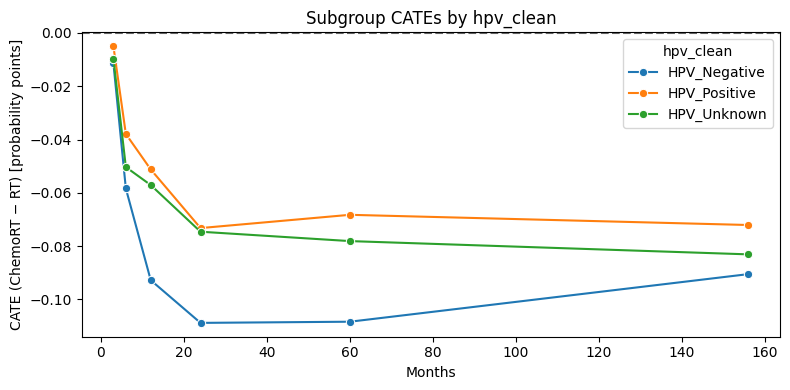

Saved outputs/subgroups/CATE_subgroup_hpv_clean.png


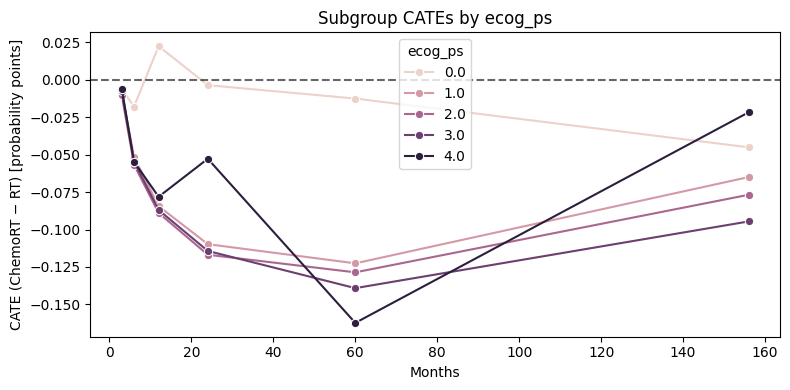

Saved outputs/subgroups/CATE_subgroup_ecog_ps.png


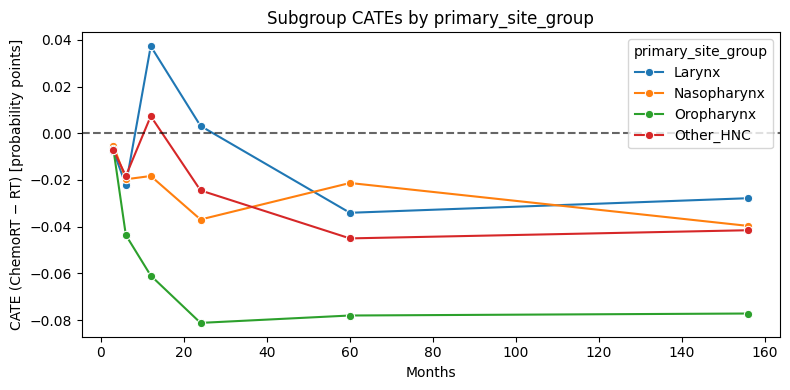

Saved outputs/subgroups/CATE_subgroup_primary_site_group.png


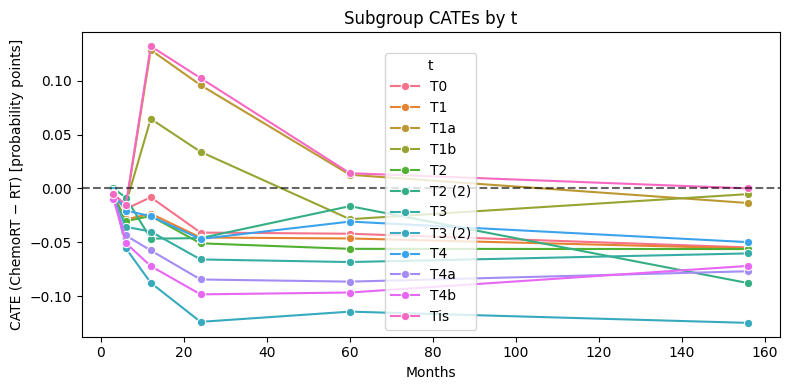

Saved outputs/subgroups/CATE_subgroup_t.png


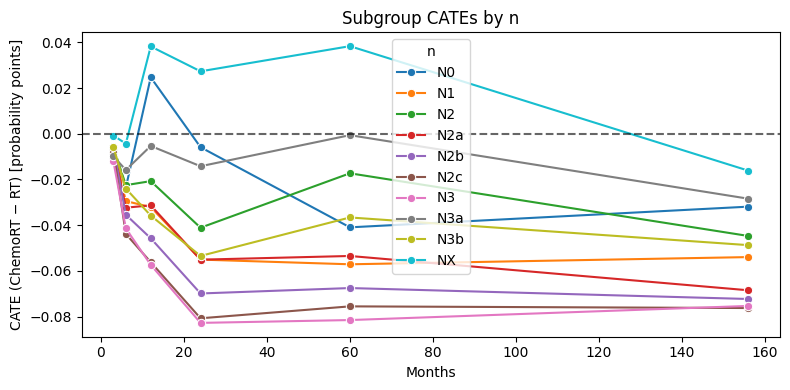

Saved outputs/subgroups/CATE_subgroup_n.png


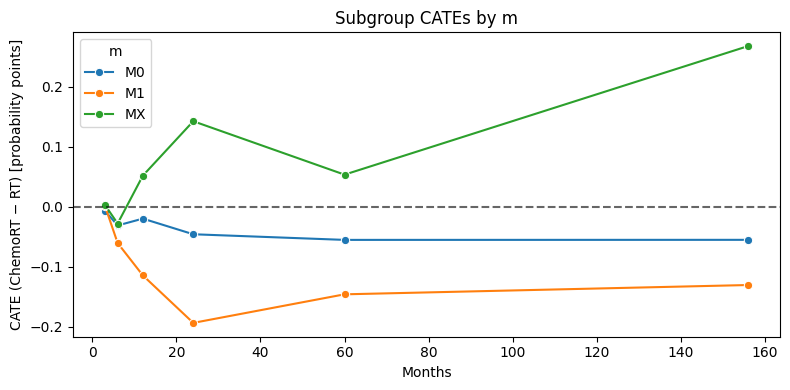

Saved outputs/subgroups/CATE_subgroup_m.png


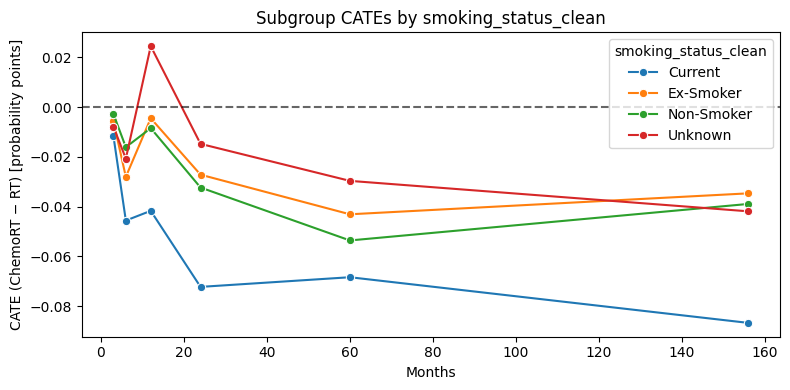

Saved outputs/subgroups/CATE_subgroup_smoking_status_clean.png


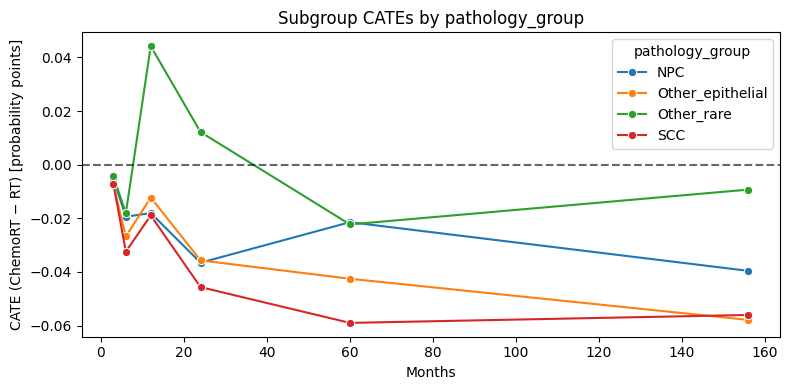

Saved outputs/subgroups/CATE_subgroup_pathology_group.png


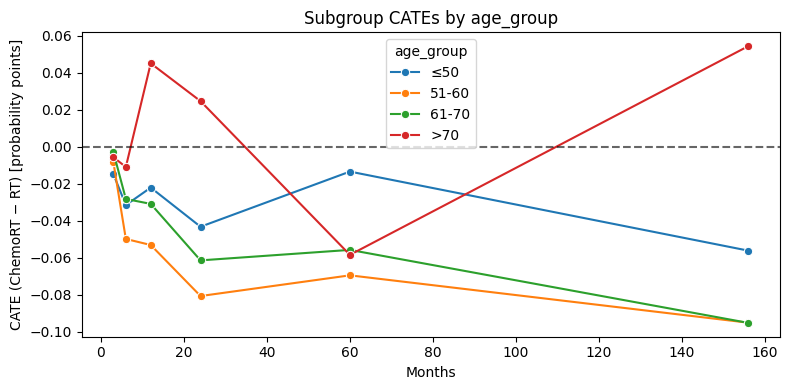

Saved outputs/subgroups/CATE_subgroup_age_group.png


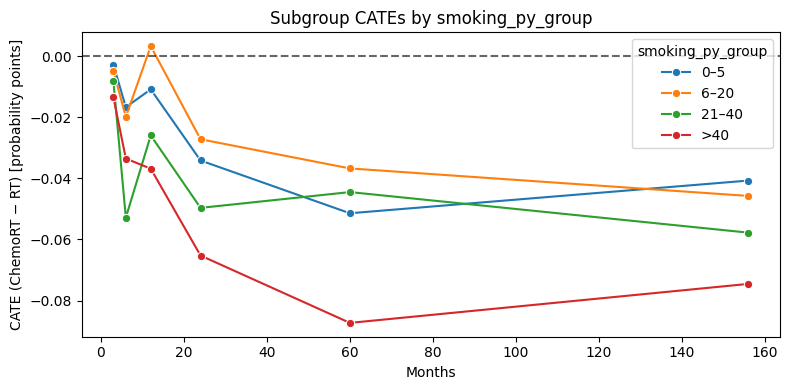

Saved outputs/subgroups/CATE_subgroup_smoking_py_group.png


In [ ]:
#create directory
os.makedirs("outputs/subgroups", exist_ok=True)# Subgroup CATE summaries & plots
group_vars = [
    'hpv_clean',
    'ecog_ps',
    'primary_site_group',
    't', 'n', 'm',
    'smoking_status_clean',
    'pathology_group'
]

subgroup_vars = group_vars.copy()

# Age groups
if 'age' in train_patients.columns:
    train_patients['age_group'] = pd.cut(train_patients['age'], bins=[0,50,60,70,200], labels=['≤50','51-60','61-70','>70'])
    subgroup_vars.append('age_group')
# smoking PY groups
if 'smoking_py_clean' in train_patients.columns:
    train_patients['smoking_py_group'] = pd.cut(train_patients['smoking_py_clean'], bins=[-0.1,5,20,40,500], labels=['0–5','6–20','21–40','>40'])
    subgroup_vars.append('smoking_py_group')

# collect safe summaries
safe_summary_list = []
cate_cols = [c for c in train_patients.columns if c.startswith("CATE_")]
for g in subgroup_vars:
    if g not in train_patients.columns:
        continue
    if train_patients[g].nunique() < 2:
        continue
    tmp = train_patients.groupby(g)[cate_cols].mean().reset_index()
    tmp['group'] = g
    safe_summary_list.append(tmp)

if len(safe_summary_list) > 0:
    subgroup_summary = pd.concat(safe_summary_list, axis=0, ignore_index=True)
    subgroup_summary.to_csv("outputs/subgroup_summary_cates.csv", index=False)
    print("Saved outputs/subgroup_summary_cates.csv")
else:
    print("No subgroup summaries created (no valid grouping variables).")

# Plot subgroup trends for each variable
for g in subgroup_vars:
    if g not in train_patients.columns: continue
    df_g = subgroup_summary[subgroup_summary['group']==g].copy()
    if df_g.empty: continue

    df_melt = df_g.melt(id_vars=[g,'group'], value_vars=cate_cols, var_name='Horizon', value_name='Mean_CATE')
    df_melt['Horizon'] = df_melt['Horizon'].str.extract(r'CATE_(\d+)m').astype(float)
    df_melt = df_melt.sort_values('Horizon')
    plt.figure(figsize=(8,4))
    sns.lineplot(data=df_melt, x='Horizon', y='Mean_CATE', hue=g, marker='o')
    plt.axhline(0, color='k', ls='--', alpha=0.6)
    plt.xlabel('Months')
    plt.ylabel('CATE (ChemoRT − RT) [probability points]')
    plt.title(f"Subgroup CATEs by {g}")
    plt.tight_layout()
    out = f"outputs/subgroups/CATE_subgroup_{g}.png"
    plt.savefig(out, dpi=150)
    plt.show()
    print("Saved", out)



In [ ]:
outdir="outputs"
#geta and save ppatient columns
# Load the forest bundle you already saved
bundle_path = os.path.join(outdir, "causal_forests_period_horizons_patient_level.joblib")
forests = joblib.load(bundle_path)
print("Keys in forests bundle:", list(forests.keys()))

#  Pick one horizo and geti its estimator
some_key = sorted(forests.keys())[0]
est = forests[some_key]

#  unwrap:
if isinstance(est, dict):
    for v in est.values():
        if hasattr(v, "effect"):
            est = v
            break

# Extract the feature names used at training time
if hasattr(est, "feature_names_in_"):
    patient_columns = list(est.feature_names_in_)
else:
    # fallback
    patient_columns = list(Xtr_patient.columns)

print("n patient columns:", len(patient_columns))
print("First 10 cols:", patient_columns[:10])

#Save them for inference
pc_path = os.path.join(outdir, "causal_patient_columns.joblib")
joblib.dump(patient_columns, pc_path)
print("Saved:", pc_path)


Keys in forests bundle: ['0-3', '4-6', '7-12', '13-24', '25-60', '60+']
n patient columns: 18
First 10 cols: ['sex_Male', 'smoking_status_clean_Ex-Smoker', 'smoking_status_clean_Non-Smoker', 'smoking_status_clean_Unknown', 'primary_site_group_Nasopharynx', 'primary_site_group_Oropharynx', 'primary_site_group_Other_HNC', 'pathology_group_Other_epithelial', 'pathology_group_Other_rare', 'pathology_group_SCC']
Saved: outputs/causal_patient_columns.joblib


# **RMST**

In [ ]:
# compute per-patient RMST (treated vs control) for all patients

outdir = "outputs"
tau_months = 36
interval_days = globals().get('interval_days', 30)
tau_days = tau_months * interval_days

# load required objects
if 'logit' not in globals():
    try:
        logit = joblib.load(os.path.join(outdir, "pooled_logit_logreg_saga.joblib"))
        print("Loaded pooled-logit from outputs/pooled_logit_logreg_saga.joblib")
    except Exception as e:
        raise RuntimeError("Could not load pooled-logit model 'logit'. Make sure outputs/pooled_logit_logreg_saga.joblib exists.") from e

if 'model_columns' not in globals():
    mc_path = os.path.join(outdir, "pooled_logit_model_columns.csv")
    if os.path.exists(mc_path):
        model_columns = pd.read_csv(mc_path).squeeze().tolist() if hasattr(pd.read_csv(mc_path), "squeeze") else pd.read_csv(mc_path)['model_columns'].tolist()
        print("Loaded model_columns.")
    else:
        raise RuntimeError("model_columns not found in globals and file outputs/pooled_logit_model_columns.csv missing.")

#  build_X_for_pp existsor try to import the safe wrapper
if 'build_X_for_pp' not in globals():
    raise RuntimeError("build_X_for_pp function not found in namespace. Define it (or run earlier cell that creates build_X_for_pp_safe).")

# pp_train and pp_test exist (person-period tables)
if 'pp_train' not in globals() or 'pp_test' not in globals():
    raise RuntimeError("pp_train and pp_test must exist in workspace (person-period DataFrames).")

# functin to compute per-patient RMST for a person-period dataframe
def compute_patient_rmst_from_pp(pp_df, logit_model, model_columns, tau_days, interval_days=30):
    patient_ids = pp_df['patient_id'].unique()
    out = []
    for pid in tqdm(patient_ids, desc="RMST patients"):
        rows_pp = pp_df[pp_df['patient_id'] == pid].sort_values('period')
        if rows_pp.shape[0] == 0:
            continue
        # determine period lengths
        if 'period_length' in rows_pp.columns:
            period_lengths = rows_pp['period_length'].fillna(interval_days).astype(int).tolist()
        elif ('period_start' in rows_pp.columns) and ('period_end' in rows_pp.columns):
            period_lengths = (rows_pp['period_end'] - rows_pp['period_start']).fillna(interval_days).astype(int).tolist()
        else:
            period_lengths = [interval_days] * rows_pp.shape[0]

        # build X for these rows
        Xrows = build_X_for_pp(rows_pp.copy())  # safe wrapper
        # to ensure columns match
        for c in model_columns:
            if c not in Xrows.columns:
                Xrows[c] = 0.0
        Xrows = Xrows[model_columns]

        # predict hazards under treated and control
        X_treated = Xrows.copy()
        X_treated['treatment'] = 1
        for pcol in [c for c in Xrows.columns if str(c).startswith('period_bin')]:
            X_treated[f'treat_x_{pcol}'] = X_treated['treatment'] * X_treated.get(pcol, 0)

        X_control = Xrows.copy()
        X_control['treatment'] = 0
        for pcol in [c for c in Xrows.columns if str(c).startswith('period_bin')]:
            X_control[f'treat_x_{pcol}'] = X_control['treatment'] * X_control.get(pcol, 0)

        # predict_proba (make sure model supports it)
        probs_t = logit_model.predict_proba(X_treated)[:,1]
        probs_c = logit_model.predict_proba(X_control)[:,1]

        # rmst calculation
        def rmst_from_period_hazards(hazards, period_lengths, tau_days):
            surv_prev = 1.0
            rmst = 0.0
            cum_days = 0
            for h, plen in zip(hazards, period_lengths):
                if cum_days >= tau_days:
                    break
                use_len = min(plen, tau_days - cum_days)
                rmst += surv_prev * use_len
                surv_prev = surv_prev * (1.0 - h)
                cum_days += plen
            return float(rmst)

        rmst_t = rmst_from_period_hazards(probs_t, period_lengths, tau_days)
        rmst_c = rmst_from_period_hazards(probs_c, period_lengths, tau_days)
        delta = rmst_t - rmst_c

        # mean period HR
        with np.errstate(divide='ignore', invalid='ignore'):
            hr_per_period = np.divide(probs_t, probs_c)
            hr_per_period[~np.isfinite(hr_per_period)] = np.nan
        avg_hr = np.nan
        if np.any(~np.isnan(hr_per_period)):
            mask = ~np.isnan(hr_per_period)
            avg_hr = np.average(hr_per_period[mask], weights=np.array(period_lengths)[mask])

        out.append({
            'patient_id': pid,
            'rmst_treated_days': rmst_t,
            'rmst_control_days': rmst_c,
            'delta_rmst_days': delta,
            'avg_hr_patient': avg_hr,
            'num_periods': rows_pp.shape[0]
        })
    return pd.DataFrame(out)

# compute for train and test (use their person-period tables)
df_rmst_train = compute_patient_rmst_from_pp(pp_train, logit, model_columns, tau_days, interval_days=interval_days)
df_rmst_test  = compute_patient_rmst_from_pp(pp_test,  logit, model_columns, tau_days, interval_days=interval_days)

df_rmst_all = pd.concat([df_rmst_train, df_rmst_test], ignore_index=True)
out_path = os.path.join(outdir, "cf_vs_logit_rmst_36m_per_patient_fixed_all.csv")
df_rmst_all.to_csv(out_path, index=False)
print("Saved recomputed RMSTs to:", out_path)
print("Train RMST rows:", df_rmst_train.shape[0], "Test RMST rows:", df_rmst_test.shape[0])

# -------- Merge onto patient-level train/test and run CF --------
train_pat = train_patients.merge(df_rmst_all[['patient_id','delta_rmst_days']], on='patient_id', how='left').dropna(subset=['delta_rmst_days']).reset_index(drop=True)
test_pat  = test_patients.merge(df_rmst_all[['patient_id','delta_rmst_days']], on='patient_id', how='left').dropna(subset=['delta_rmst_days']).reset_index(drop=True)

print("After merge: train_pat rows:", train_pat.shape[0], "test_pat rows:", test_pat.shape[0])

if train_pat.shape[0] < 10:
    print("WARNING: very few train patients with RMST. CF training may be unstable. Consider increasing train size or using cross-fitting.")
else:
    # build X matrices (baseline)
    baseline_cat = [c for c in ['sex','smoking_status_clean','primary_site_group','pathology_group','hpv_clean'] if c in train_pat.columns]
    baseline_num = [c for c in ['age','ecog_ps','BED_eff','EQD2','smoking_py_clean'] if c in train_pat.columns]

    Xtr_cat = pd.get_dummies(train_pat[baseline_cat].fillna('Missing').astype(str), drop_first=True)
    Xte_cat = pd.get_dummies(test_pat[baseline_cat].fillna('Missing').astype(str), drop_first=True)
    Xte_cat = Xte_cat.reindex(columns=Xtr_cat.columns, fill_value=0)
    Xtr_num = train_pat[baseline_num].fillna(train_pat[baseline_num].median()) if baseline_num else pd.DataFrame(index=train_pat.index)
    Xte_num = test_pat[baseline_num].fillna(train_pat[baseline_num].median()) if baseline_num else pd.DataFrame(index=test_pat.index)

    Xtr = pd.concat([Xtr_cat.reset_index(drop=True), Xtr_num.reset_index(drop=True)], axis=1).fillna(0)
    Xte = pd.concat([Xte_cat.reset_index(drop=True), Xte_num.reset_index(drop=True)], axis=1).fillna(0)

    Ytr = train_pat['delta_rmst_days'].astype(float).values
    Wtr = train_pat['treatment'].astype(int).values
    sw_col = 'sw_trunc_logit_simple' if 'sw_trunc_logit_simple' in train_pat.columns else ('sw_trunc' if 'sw_trunc' in train_pat.columns else None)
    if sw_col:
        sw_tr = train_pat[sw_col].fillna(1.0).values
    else:
        sw_tr = np.ones(len(Ytr))
    sw_tr = np.clip(sw_tr, 1e-3, 10.0)

    # Fit CF on RMST pseudo-values (patient-level)
    cf = CausalForestDML(
        model_y = RandomForestRegressor(n_estimators=200, min_samples_leaf=10, random_state=42),
        model_t = RandomForestRegressor(n_estimators=200, min_samples_leaf=10, random_state=42),
        discrete_treatment=True,
        n_estimators=800,
        min_samples_leaf=5,
        random_state=42,
        verbose=0
    )
    print("Fitting CausalForest on recomputed patient RMSTs...")
    cf.fit(Ytr, Wtr, X=Xtr.values, sample_weight=sw_tr)

    # predictions
    cate_tr = np.asarray(cf.effect(Xtr.values)).flatten()
    cate_te = np.asarray(cf.effect(Xte.values)).flatten()
    train_pat['CATE_rmst_36m_days'] = cate_tr
    test_pat['CATE_rmst_36m_days'] = cate_te
    train_pat['CATE_rmst_36m_months'] = train_pat['CATE_rmst_36m_days']/30.0
    test_pat['CATE_rmst_36m_months'] = test_pat['CATE_rmst_36m_days']/30.0

    # save results
    joblib.dump(cf, os.path.join(outdir, "cf_rmst_36m_patient_level.joblib"))
    train_pat.to_csv(os.path.join(outdir, "train_patients_with_rmst_cates.csv"), index=False)
    test_pat.to_csv(os.path.join(outdir, "test_patients_with_rmst_cates.csv"), index=False)
    print("Saved CF results; train/test patient files updated.")


RMST patients:   0%|          | 0/2453 [00:00<?, ?it/s]

RMST patients:   0%|          | 0/818 [00:00<?, ?it/s]

Saved recomputed RMSTs to: outputs/cf_vs_logit_rmst_36m_per_patient_fixed_all.csv
Train RMST rows: 2453 Test RMST rows: 818
After merge: train_pat rows: 2453 test_pat rows: 818
Fitting CausalForest on recomputed patient RMSTs...
Saved CF results; train/test patient files updated.


In [ ]:

# load collapse_maps from filenames
possible_paths = [
    os.path.join(outdir, "pp_collapse_maps.joblib"),
    os.path.join(outdir, "collapse_maps.joblib"),
    os.path.join(outdir, "pp_collapse_maps.pkl"),
    os.path.join(outdir, "pp_collapse_maps.npy")
]
collapse_maps_loaded = None
for p in possible_paths:
    if os.path.exists(p):
        try:
            collapse_maps_loaded = joblib.load(p)
            print("Loaded collapse_maps from:", p)
            break
        except Exception as e:
            print("Found file but failed to load", p, "error:", e)

if collapse_maps_loaded is None:
    # find collapse_maps variable in globals()
    if 'collapse_maps' in globals() and globals()['collapse_maps'] is not None:
        collapse_maps_loaded = globals()['collapse_maps']
        print("Using collapse_maps from globals()")
    else:
        # fallback: build collapse map from pp_train
        if 'pp_train' in globals():
            collapse_maps_loaded = {}
            for c in ['subsite_clean','pathology_group','primary_site_group','stage']:
                if c in pp_train.columns:
                    collapse_maps_loaded[c] = list(pp_train[c].dropna().unique())
            print("No saved collapse_maps found; built trivial collapse_maps from pp_train with keys:", list(collapse_maps_loaded.keys()))
        else:
            collapse_maps_loaded = {}
            print("No collapse_maps found and pp_train not available; using empty collapse_maps (will not collapse categories).")

# assign into global name expected by build_X_for_pp
collapse_maps = collapse_maps_loaded

#  build_X_for_pp

def build_X_for_pp_safe(df_pp):
    """
    Safe wrapper around original build_X_for_pp:
    - Ensures model_columns exist (will return Xnew with those columns)
    """
    #  copy
    df = df_pp.copy()

    # Apply collapse maps
    for c, keep in (collapse_maps.items() if collapse_maps else []):
        if c in df.columns:
            df[c] = df[c].astype(str).where(df[c].astype(str).isin(keep), 'Other')

    # ensure period_bin exists
    if 'period_month' not in df.columns:
        if 'period' in df.columns:
            df['period_month'] = df['period'].astype(int)
        else:
            # fallback: create single period if missing
            df['period_month'] = 1
    if 'period_bin' not in df.columns:
        # reuse period_bins & period_labels from your workspace if they exist, else sensible defaults
        try:
            bins = period_bins
            labels = period_labels
        except NameError:
            bins = [0,3,6,12,24,60,np.inf]
            labels = ['0-3','4-6','7-12','13-24','25-60','60+']
        df['period_bin'] = pd.cut(df['period_month'], bins=bins, labels=labels, right=True)

    # dummies for categorical features 'cat_cols' if present; else empty DataFrame
    cat_cols_local = [c for c in ['period_bin','sex','smoking_status_clean','primary_site_group','subsite_clean','stage','hpv_clean'] if c in df.columns]
    Xc = pd.get_dummies(df[cat_cols_local].astype(str), drop_first=True) if cat_cols_local else pd.DataFrame(index=df.index)

    # numeric features (num_cols) handling
    num_cols_local = [c for c in ['age','ecog_ps','smoking_py_clean','time_since_rt_days'] if c in df.columns]
    Xn = df[num_cols_local].copy() if num_cols_local else pd.DataFrame(index=df.index)
    # coerce to numeric and fillna with train medians if available
    for c in Xn.columns:
        Xn[c] = pd.to_numeric(Xn[c], errors='coerce')
    # if train_medians_pp exists, use it; otherwise fill with column median
    if 'train_medians_pp' in globals() and train_medians_pp is not None:
        fill_vals = train_medians_pp.to_dict()
    else:
        fill_vals = Xn.median().to_dict()
    Xn = Xn.fillna(pd.Series(fill_vals))
    # scale using saved scaler if available
    if os.path.exists(os.path.join(outdir, "pp_scaler.joblib")):
        try:
            scaler_local = joblib.load(os.path.join(outdir, "pp_scaler.joblib"))
            Xn_scaled = pd.DataFrame(scaler_local.transform(Xn), columns=Xn.columns, index=Xn.index)
        except Exception as e:
            print("Failed to load scaler from outputs/pp_scaler.joblib:", e)
            Xn_scaled = Xn
    else:
        Xn_scaled = Xn

    # combine
    Xnew = pd.concat([Xc.reset_index(drop=True), Xn_scaled.reset_index(drop=True)], axis=1)

    # add treatment column if present in df_pp
    if 'treatment' in df.columns:
        Xnew['treatment'] = pd.to_numeric(df['treatment'], errors='coerce').fillna(0).astype(int).values
    else:
        Xnew['treatment'] = 0

    # create period dummy interaction columns based on columns starting with 'period_bin'
    period_dummy_cols_local = [c for c in Xnew.columns if str(c).startswith('period_bin')]
    for pcol in period_dummy_cols_local:
        Xnew[f'treat_x_{pcol}'] = Xnew['treatment'] * Xnew[pcol]

    # align to model_columns if available; else just return Xnew
    if 'model_columns' in globals() and model_columns is not None:
        Xnew = Xnew.reindex(columns=model_columns, fill_value=0.0)
    return Xnew

# Replace the global build_X_for_pp with safe wrapper
build_X_for_pp = build_X_for_pp_safe

#  Recompute RMST per patient from pooled-logit counterfactuals
if 'pp_test' not in globals():
    raise RuntimeError("pp_test not found in workspace. Please ensure person-period test DataFrame is available as pp_test.")

if 'logit' not in globals():
    raise RuntimeError("logit model not found. Please load your pooled-logit model into variable 'logit'.")

if 'model_columns' not in globals():
    # try to read from file
    mc_path = os.path.join(outdir, "pooled_logit_model_columns.csv")
    if os.path.exists(mc_path):
        model_columns = pd.read_csv(mc_path).squeeze().tolist() if hasattr(pd.read_csv(mc_path), "squeeze") else pd.read_csv(mc_path)['model_columns'].tolist()
        print("Loaded model_columns from", mc_path)
    else:
        raise RuntimeError("model_columns not found in globals and file outputs/pooled_logit_model_columns.csv missing.")

patient_ids = test_patients['patient_id'].unique()
rows = []
for pid in tqdm(patient_ids, desc="Compute ΔRMST per patient (fixed)"):
    rows_pp = pp_test[pp_test['patient_id'] == pid].sort_values('period')
    if rows_pp.shape[0] == 0:
        continue
    # find period lengths else default to interval_days
    if 'period_length' in rows_pp.columns:
        period_lengths = rows_pp['period_length'].fillna(interval_days).astype(int).tolist()
    else:
        # if some patients have variable last-interval lengths, try to compute from period_start/period_end
        if ('period_start' in rows_pp.columns) and ('period_end' in rows_pp.columns):
            period_lengths = (rows_pp['period_end'] - rows_pp['period_start']).fillna(interval_days).astype(int).tolist()
        else:
            period_lengths = [interval_days] * rows_pp.shape[0]

    Xrows = build_X_for_pp(rows_pp)  # safe wrapper
    # ensure columns match model_columns
    if set(model_columns) - set(Xrows.columns):
        # add missing columns
        missing = set(model_columns) - set(Xrows.columns)
        for c in missing:
            Xrows[c] = 0.0
    Xrows = Xrows[model_columns]  # order exactly

    # predict under treated and control
    X_treated = Xrows.copy()
    X_treated['treatment'] = 1
    # recompute interaction columns for safety
    for pcol in [c for c in Xrows.columns if c.startswith('period_bin')]:
        X_treated[f'treat_x_{pcol}'] = X_treated['treatment'] * X_treated.get(pcol, 0)

    X_control = Xrows.copy()
    X_control['treatment'] = 0
    for pcol in [c for c in Xrows.columns if c.startswith('period_bin')]:
        X_control[f'treat_x_{pcol}'] = X_control['treatment'] * X_control.get(pcol, 0)

    # make predictions (ensure model supports predict_proba)
    probs_treated = logit.predict_proba(X_treated)[:,1]
    probs_control = logit.predict_proba(X_control)[:,1]

    # rmst function (discrete hazard)
    def rmst_from_period_hazards(hazards, period_lengths, tau_days):
        surv_prev = 1.0
        rmst = 0.0
        cum_days = 0
        for h, plen in zip(hazards, period_lengths):
            if cum_days >= tau_days:
                break
            use_len = min(plen, tau_days - cum_days)
            rmst += surv_prev * use_len
            surv_prev = surv_prev * (1.0 - h)
            cum_days += plen
        return float(rmst)

    rmst_tr = rmst_from_period_hazards(probs_treated, period_lengths, tau_days)
    rmst_ct = rmst_from_period_hazards(probs_control, period_lengths, tau_days)
    delta = rmst_tr - rmst_ct

    # compute average per-patient HR (weighted by period lengths)
    with np.errstate(divide='ignore', invalid='ignore'):
        hr_per_period = np.divide(probs_treated, probs_control)
        hr_per_period[~np.isfinite(hr_per_period)] = np.nan
    if np.all(np.isnan(hr_per_period)):
        avg_hr = np.nan
    else:
        mask = ~np.isnan(hr_per_period)
        avg_hr = np.average(hr_per_period[mask], weights=np.array(period_lengths)[mask])

    rows.append({
        'patient_id': pid,
        'rmst_treated_days': rmst_tr,
        'rmst_control_days': rmst_ct,
        'delta_rmst_days': delta,
        'avg_hr_patient': avg_hr,
        'num_periods': rows_pp.shape[0]
    })

df_rmst = pd.DataFrame(rows)
df_rmst.to_csv(os.path.join(outdir, "cf_vs_logit_rmst_36m_per_patient_fixed.csv"), index=False)
print("Saved fixed per-patient RMST comparisons to:", os.path.join(outdir, "cf_vs_logit_rmst_36m_per_patient_fixed.csv"))
print("Sample rows:")
print(df_rmst.head())


Loaded collapse_maps from: outputs/pp_collapse_maps.joblib


Compute ΔRMST per patient (fixed):   0%|          | 0/818 [00:00<?, ?it/s]

Saved fixed per-patient RMST comparisons to: outputs/cf_vs_logit_rmst_36m_per_patient_fixed.csv
Sample rows:
     patient_id  rmst_treated_days  rmst_control_days  delta_rmst_days  \
0  RADCURE-0006         460.725642         392.854298        67.871344   
1  RADCURE-0010         985.393086         899.397536        85.995550   
2  RADCURE-0014         548.479803         499.978645        48.501157   
3  RADCURE-0021         961.538482         857.570979       103.967503   
4  RADCURE-0027         966.038580         865.349698       100.688882   

   avg_hr_patient  num_periods  
0        0.495076           18  
1        0.413842          115  
2        0.488367           20  
3        0.511282           50  
4        0.468630           77  


N patients: 818
CF CATE months: mean -0.000 sd 0.000
Logit ΔRMST months: mean 2.478 sd 1.483
ATE CF (months): -0.000 (-0.000, -0.000)
ATE Logit ΔRMST (months): 2.478 (2.370, 2.581)


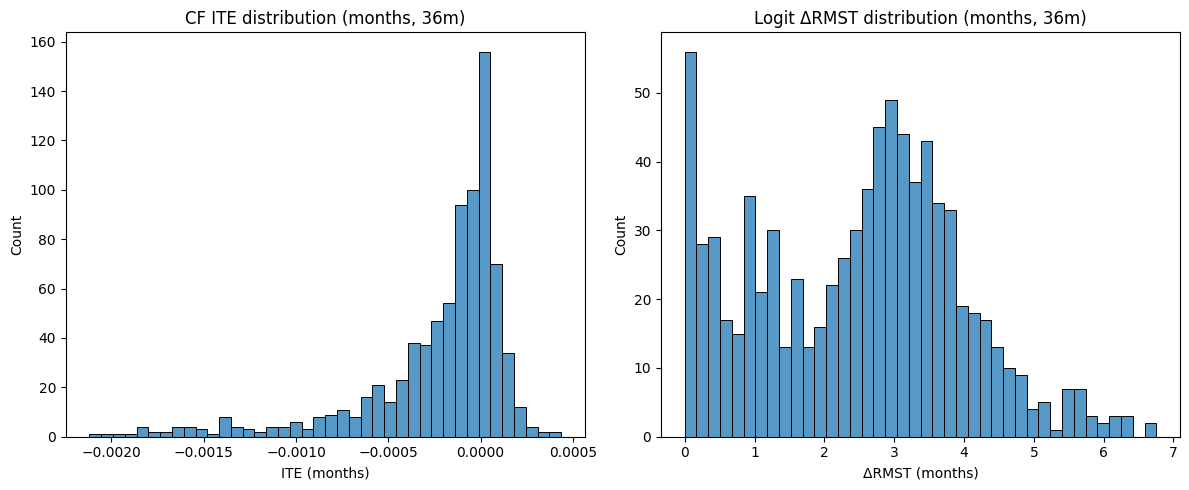

Pearson r between CF ITE and logit ΔRMST: r=0.111 p=1.441e-03


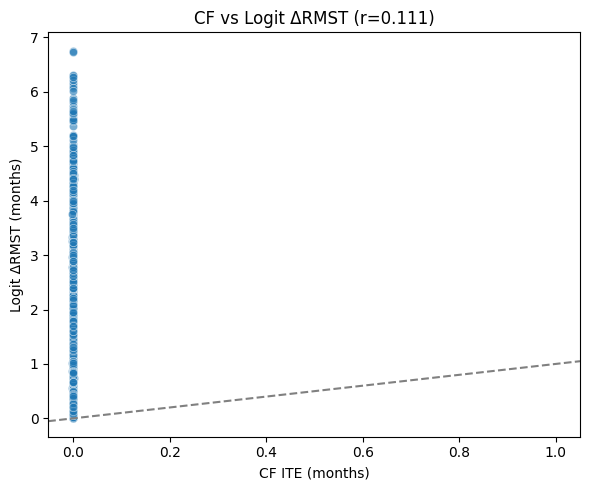

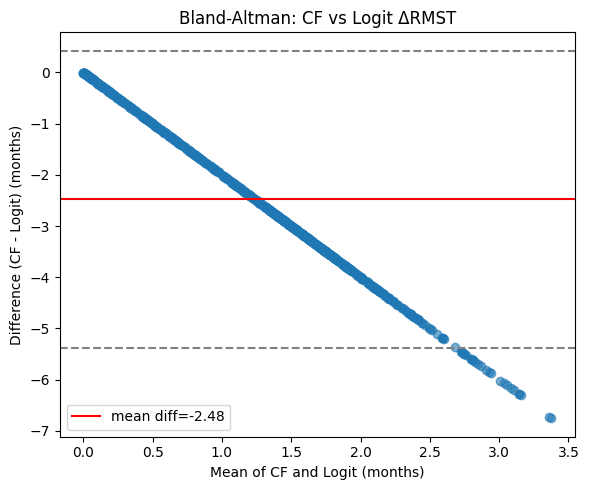

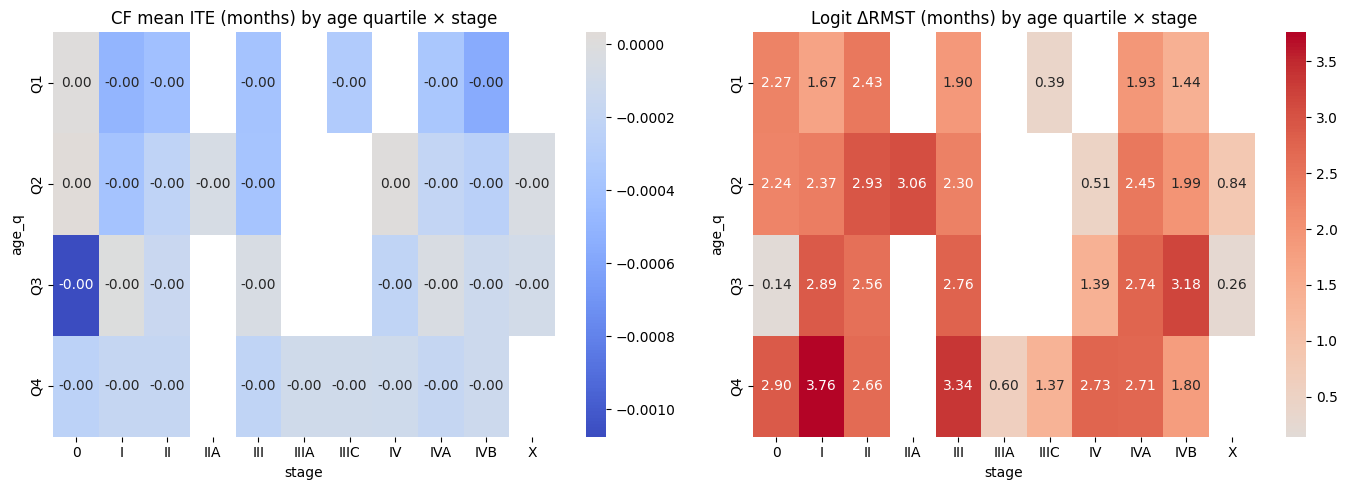

Saved subgroup summary to outputs/subgroup_summary_cf_vs_logit.csv


group_col         group    n   cf_mean     cf_lo     cf_up  \
0              hpv_clean  HPV_Negative   87 -0.000371 -0.000466 -0.000284   
1              hpv_clean  HPV_Positive  242 -0.000164 -0.000211 -0.000120   
2              hpv_clean   HPV_Unknown   37 -0.000378 -0.000526 -0.000237   
3                  stage             I   92 -0.000234 -0.000332 -0.000144   
4                  stage           IVB   78 -0.000352 -0.000459 -0.000247   
5                  stage           IVA  376 -0.000199 -0.000236 -0.000163   
6                  stage           III  159 -0.000253 -0.000325 -0.000189   
7                  stage            II   87 -0.000219 -0.000308 -0.000142   
8   smoking_status_clean     Ex-Smoker  307 -0.000159 -0.000198 -0.000127   
9   smoking_status_clean    Non-Smoker  209 -0.000087 -0.000112 -0.000063   
10  smoking_status_clean       Current  293 -0.000405 -0.000466 -0.000343   

    log_mean    log_lo    log_up  
0   2.246347  1.857285  2.607112  
1   2.504515  2.344119  2.662870  
2   2.900768  2.473666  3.351476  
3   2.849062  2.563893  3.138485  
4   1.971859  1.630017  2.331444  
5   2.427819  2.284922  2.570097  
6   2.646238  2.407387  2.872516  
7   2.664586  2.339600  2.978958  
8   2.722647  2.545201  2.901379  
9   2.450193  2.314886  2.603575  
10  2.255313  2.072379  2.440359

Saved top/bottom lists to outputs/


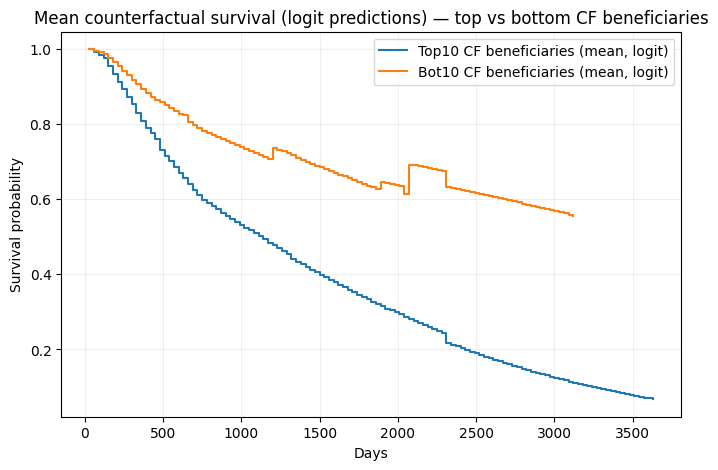

Saved merged final df to outputs/cf_logit_rmst_36m_merged_final.csv


In [ ]:
#random state
rng = np.random.RandomState(42)

# Load the ΔRMST per patient
df_rmst = pd.read_csv(os.path.join(outdir, "cf_vs_logit_rmst_36m_per_patient_fixed.csv"))

# Load test_patients
if 'test_patients' not in globals():
    # try to find a saved CSV
    if os.path.exists(os.path.join(outdir, "test_patients_with_period_cates.csv")):
        test_patients = pd.read_csv(os.path.join(outdir, "test_patients_with_period_cates.csv"))
    else:
        raise RuntimeError("test_patients not found in workspace or outputs/; please load it into variable test_patients.")

# Merge: find CF CATE column
df = test_patients.merge(df_rmst, on='patient_id', how='left')

# Find a CATE column --> 'CATE_24m'
possible_cates = [c for c in df.columns if c.startswith('CATE_')]
if 'CATE_36m' in df.columns:
    cf_col = 'CATE_36m'
elif len(possible_cates)>0:
    cf_col = possible_cates[0]
else:
    raise RuntimeError("No CATE column (CATE_*) in test_patients. Please ensure causal forest results were saved to test_patients.")

# Create unified columns in months
df['cf_cate_days'] = df[cf_col].astype(float)
df['cf_cate_months'] = df['cf_cate_days'] / 30.0
df['delta_rmst_days'] = df['delta_rmst_days'].astype(float)
df['delta_rmst_months'] = df['delta_rmst_days'] / 30.0

# sample weight selection
if 'sample_w_36m' in df.columns:
    df['w_use'] = df['sample_w_36m'].fillna(1.0)
elif 'sw_trunc' in df.columns:
    df['w_use'] = df['sw_trunc'].fillna(1.0)
else:
    df['w_use'] = 1.0

# basic stats
print("N patients:", df.shape[0])
print("CF CATE months: mean {:.3f} sd {:.3f}".format(df['cf_cate_months'].mean(), df['cf_cate_months'].std()))
print("Logit ΔRMST months: mean {:.3f} sd {:.3f}".format(df['delta_rmst_months'].mean(), df['delta_rmst_months'].std()))


# Weighted ATE and bootstrap CI
def weighted_mean_bootstrap(values, weights=None, n_boot=2000):
    # returns mean and (2.5,97.5) percentile CI
    values = np.asarray(values)
    if weights is None:
        weights = np.ones(len(values))
    weights = np.asarray(weights)
    # weighted mean
    mean = np.average(values, weights=weights)
    # bootstrap by resampling indices with replacement (resample indexed pairs with weight preserved)
    n = len(values)
    rng = np.random.RandomState(0)
    boots = []
    for _ in range(n_boot):
        idx = rng.choice(n, n, replace=True)
        boots.append(np.average(values[idx], weights=weights[idx]))
    lower = np.percentile(boots, 2.5)
    upper = np.percentile(boots, 97.5)
    return mean, lower, upper

ate_cf, lo_cf, up_cf = weighted_mean_bootstrap(df['cf_cate_months'].fillna(0).values, df['w_use'].values)
ate_log, lo_log, up_log = weighted_mean_bootstrap(df['delta_rmst_months'].fillna(0).values, df['w_use'].values)
print(f"ATE CF (months): {ate_cf:.3f} ({lo_cf:.3f}, {up_cf:.3f})")
print(f"ATE Logit ΔRMST (months): {ate_log:.3f} ({lo_log:.3f}, {up_log:.3f})")

# -----------------------------
# Distribution plots
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['cf_cate_months'].dropna(), bins=40, kde=False)
plt.title('CF ITE distribution (months, 36m)')
plt.xlabel('ITE (months)')
plt.subplot(1,2,2)
sns.histplot(df['delta_rmst_months'].dropna(), bins=40, kde=False)
plt.title('Logit ΔRMST distribution (months, 36m)')
plt.xlabel('ΔRMST (months)')
plt.tight_layout()
plt.savefig(os.path.join(outdir, "distributions_cf_vs_logit.png"), dpi=150)
plt.show()

# -----------------------------
# Scatter + correlation and Bland-Altman
x = df['cf_cate_months'].fillna(0).values
y = df['delta_rmst_months'].fillna(0).values
r, p = st.pearsonr(x, y)
print(f"Pearson r between CF ITE and logit ΔRMST: r={r:.3f} p={p:.3e}")

plt.figure(figsize=(6,5))
sns.scatterplot(x=x, y=y, alpha=0.6)
plt.xlabel('CF ITE (months)')
plt.ylabel('Logit ΔRMST (months)')
plt.title(f'CF vs Logit ΔRMST (r={r:.3f})')
plt.axline((0,0),(1,1), color='gray', linestyle='--')
plt.tight_layout()
plt.savefig(os.path.join(outdir, "scatter_cf_vs_logit.png"), dpi=150)
plt.show()

# Bland-Altman: diff vs mean
diff = x - y
mean_xy = 0.5*(x + y)
md = np.mean(diff)
sd = np.std(diff)
plt.figure(figsize=(6,5))
plt.scatter(mean_xy, diff, alpha=0.6)
plt.axhline(md, color='red', label=f'mean diff={md:.2f}')
plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
plt.xlabel('Mean of CF and Logit (months)')
plt.ylabel('Difference (CF - Logit) (months)')
plt.title('Bland-Altman: CF vs Logit ΔRMST')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(outdir, "bland_altman_cf_vs_logit.png"), dpi=150)
plt.show()


# Heatmaps age-quantile x stage for both metrics
if 'age' in df.columns and 'stage' in df.columns:
    df['age_q'] = pd.qcut(df['age'].fillna(df['age'].median()), q=4, labels=['Q1','Q2','Q3','Q4'])
    heat_cf = df.groupby(['age_q','stage'])['cf_cate_months'].mean().unstack()
    heat_log = df.groupby(['age_q','stage'])['delta_rmst_months'].mean().unstack()

    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    sns.heatmap(heat_cf, annot=True, fmt='.2f', center=0, cmap='coolwarm')
    plt.title('CF mean ITE (months) by age quartile × stage')
    plt.subplot(1,2,2)
    sns.heatmap(heat_log, annot=True, fmt='.2f', center=0, cmap='coolwarm')
    plt.title('Logit ΔRMST (months) by age quartile × stage')
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "heatmaps_age_stage_cf_vs_logit.png"), dpi=150)
    plt.show()

# Subgroup summaries: hpv_clean, stage, smoking_status_clean
subgroups = []
if 'hpv_clean' in df.columns:
    subgroups.append(('hpv_clean', df['hpv_clean'].unique()))
if 'stage' in df.columns:
    subgroups.append(('stage', df['stage'].unique()))
if 'smoking_status_clean' in df.columns:
    subgroups.append(('smoking_status_clean', df['smoking_status_clean'].unique()))

sub_summary = []
for col, vals in subgroups:
    for v in vals:
        mask = df[col] == v
        if mask.sum() < 10:
            continue
        mean_cf, lo_cf, up_cf = weighted_mean_bootstrap(df.loc[mask, 'cf_cate_months'].fillna(0).values, df.loc[mask,'w_use'].values)
        mean_log, lo_log, up_log = weighted_mean_bootstrap(df.loc[mask, 'delta_rmst_months'].fillna(0).values, df.loc[mask,'w_use'].values)
        sub_summary.append({'group_col': col, 'group': v, 'n': int(mask.sum()), 'cf_mean': mean_cf, 'cf_lo': lo_cf, 'cf_up': up_cf, 'log_mean': mean_log, 'log_lo': lo_log, 'log_up': up_log})
sub_df = pd.DataFrame(sub_summary)
sub_df.to_csv(os.path.join(outdir, "subgroup_summary_cf_vs_logit.csv"), index=False)
print("Saved subgroup summary to outputs/subgroup_summary_cf_vs_logit.csv")
display(sub_df.head(20))




#  beneficiaries and counterfactual survival curves
# Show top 5 CF beneficiaries and their pooled-logit ΔRMST
topk = df.sort_values('cf_cate_days', ascending=False).head(10)
botk = df.sort_values('cf_cate_days', ascending=True).head(10)
topk[['patient_id','cf_cate_months','delta_rmst_months']].to_csv(os.path.join(outdir,"top10_cf_beneficiaries.csv"), index=False)
botk[['patient_id','cf_cate_months','delta_rmst_months']].to_csv(os.path.join(outdir,"bot10_cf_beneficiaries.csv"), index=False)
print("Saved top/bottom lists to outputs/")

# If pp_test & predict_survival_from_pp exist, plot mean survival for top vs bottom groups using logit counterfactuals
if 'pp_test' in globals() and 'predict_survival_from_pp' in globals():
    def mean_counterfactual_survival(patient_ids):
        # returns DataFrame: period, mean_survival_treated, mean_survival_control
        pats = pp_test[pp_test['patient_id'].isin(patient_ids)].copy()
        # predict per-patient survival using predict_survival_from_pp
        survs = predict_survival_from_pp(pats, patient_ids=patient_ids)
        # average survival by period across patients (unweighted)
        mean_surv = survs.groupby('period')['survival_at_period_end'].mean().reset_index()
        return mean_surv
    top_ids = topk['patient_id'].tolist()
    bot_ids = botk['patient_id'].tolist()
    top_surv = mean_counterfactual_survival(top_ids)
    bot_surv = mean_counterfactual_survival(bot_ids)

    plt.figure(figsize=(8,5))
    days_top = top_surv['period']*interval_days
    days_bot = bot_surv['period']*interval_days
    plt.step(days_top, np.concatenate(([1.0], top_surv['survival_at_period_end'].values[:-1])), where='post', label='Top10 CF beneficiaries (mean, logit)')
    plt.step(days_bot, np.concatenate(([1.0], bot_surv['survival_at_period_end'].values[:-1])), where='post', label='Bot10 CF beneficiaries (mean, logit)')
    plt.xlabel('Days')
    plt.ylabel('Survival probability')
    plt.title('Mean counterfactual survival (logit predictions) — top vs bottom CF beneficiaries')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.savefig(os.path.join(outdir,"top_bottom_cf_survival_logit.png"), dpi=150)
    plt.show()

# Save merged DF
df.to_csv(os.path.join(outdir, "cf_logit_rmst_36m_merged_final.csv"), index=False)
print("Saved merged final df to outputs/cf_logit_rmst_36m_merged_final.csv")


N patients with ΔRMST: 818
Train / hold sizes: (654, 22) (164, 22)
CV R^2 (train): -0.0285779253517922 std: 0.04113782462448128
Holdout RMSE (months, weighted): 1.496
Saved RF model and columns.


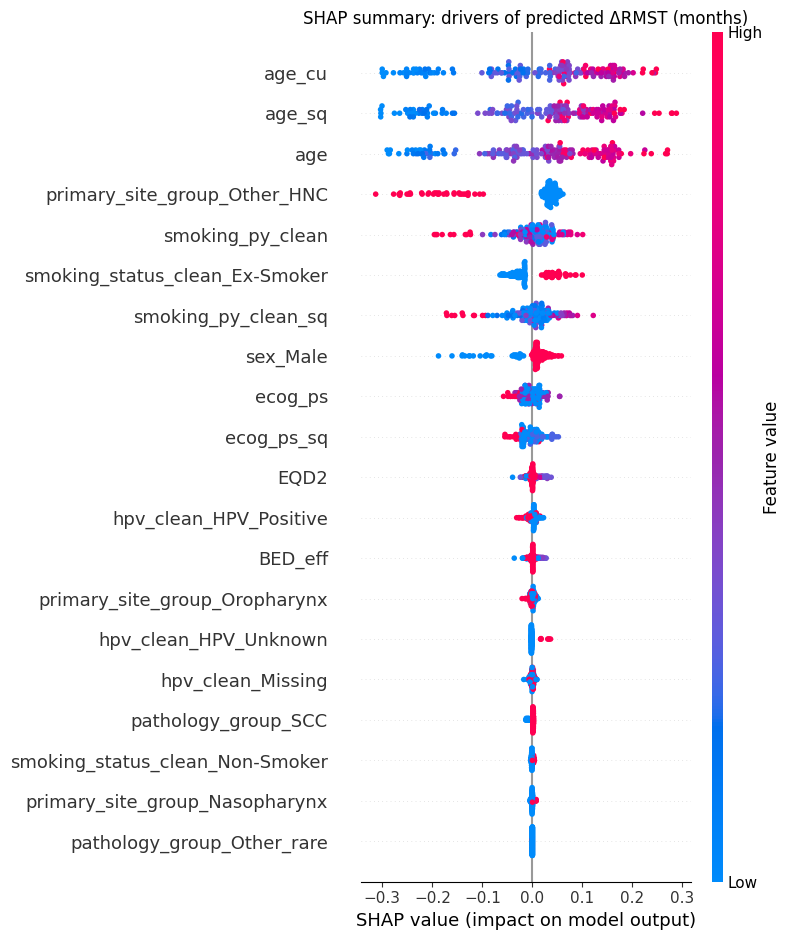

Saved SHAP summary plot.


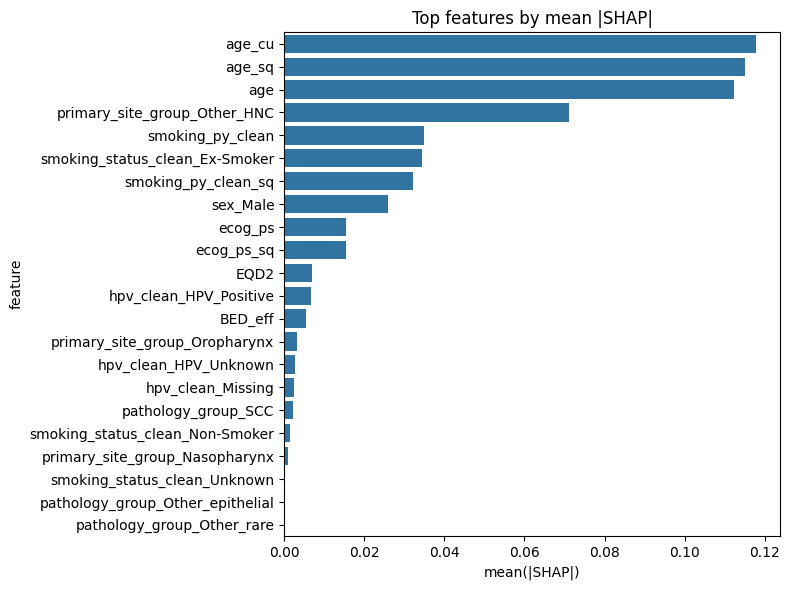

Saved SHAP topbar plot.


<Figure size 600x400 with 0 Axes>

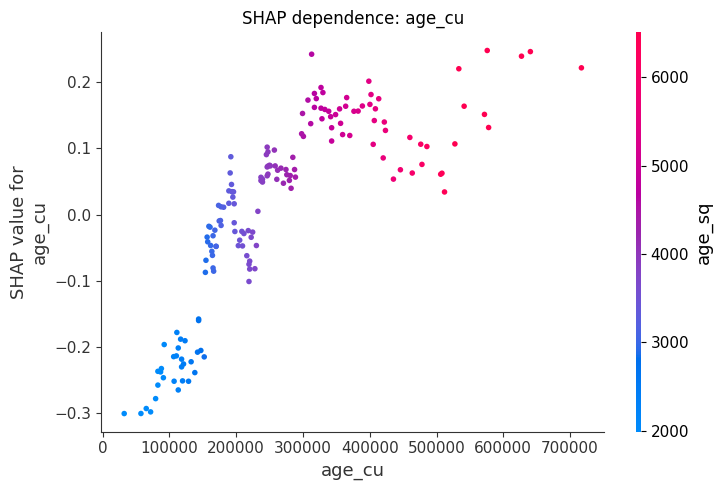

Saved SHAP dependence for age_cu
Saved SHAP objects.
- Model predicts ΔRMST (months). Positive = treated yields MORE RMST (benefit).
- SHAP summary plot saved -> top features driving predicted ΔRMST are: ['age_cu', 'age_sq', 'age', 'primary_site_group_Other_HNC', 'smoking_py_clean', 'smoking_status_clean_Ex-Smoker', 'smoking_py_clean_sq', 'sex_Male', 'ecog_ps', 'ecog_ps_sq']
- For any patient, the SHAP contribution (in months) shows how much that feature shifts the baseline prediction.


In [ ]:
#SHAP- RMST
#random seed
rng_seed = 42

# load ΔRMST and patient table
rmst_path = os.path.join(outdir, "cf_vs_logit_rmst_36m_per_patient_fixed.csv")
if not os.path.exists(rmst_path):
    raise RuntimeError(f"{rmst_path} not found. Run RMST computation first.")

df_rmst = pd.read_csv(rmst_path)

# Load patient-level features
if 'test_patients' not in globals():
    # try load from outputs
    tp_path = os.path.join(outdir, "test_patients_with_period_cates.csv")
    if os.path.exists(tp_path):
        test_patients = pd.read_csv(tp_path)
    else:
        raise RuntimeError("test_patients not found in globals or outputs/; load it into variable test_patients.")
df = test_patients.merge(df_rmst, on='patient_id', how='left')

#drop patients with missing delta_rmst_days
df = df.dropna(subset=['delta_rmst_days']).reset_index(drop=True)
print("N patients with ΔRMST:", df.shape[0])

# Build feature matrix X and target y
baseline_cat = [c for c in ['sex','smoking_status_clean','primary_site_group','pathology_group','hpv_clean'] if c in df.columns]
baseline_num = [c for c in ['age','ecog_ps','BED_eff','EQD2','smoking_py_clean'] if c in df.columns]

# Create dummies for categorical
X_cat = pd.get_dummies(df[baseline_cat].fillna('Missing').astype(str), drop_first=True)
# Numeric: coerce and fill with train medians (or df median)
X_num = df[baseline_num].copy()
for c in X_num.columns:
    X_num[c] = pd.to_numeric(X_num[c], errors='coerce')
num_fill = X_num.median()
X_num = X_num.fillna(num_fill)

# add quadratic terms
for c in ['age','ecog_ps','smoking_py_clean']:
    if c in X_num.columns:
        X_num[f"{c}_sq"] = X_num[c]**2

# spline approximation for age using polynomial basis or sklearn SplineTransformer
#  add cubic term
if 'age' in X_num.columns:
    X_num['age_cu'] = X_num['age']**3

# Combine
X = pd.concat([X_cat.reset_index(drop=True), X_num.reset_index(drop=True)], axis=1).fillna(0)

# Target
y_days = df['delta_rmst_days'].astype(float).values
y_months = y_days / 30.0
y = y_months   # months or

# sample weights
if 'sample_w_36m' in df.columns:
    sample_w = df['sample_w_36m'].fillna(1.0).astype(float).values
elif 'sw_trunc' in df.columns:
    sample_w = df['sw_trunc'].fillna(1.0).astype(float).values
elif 'sw' in df.columns:
    sample_w = df['sw'].fillna(1.0).astype(float).values
else:
    sample_w = np.ones(len(df))

#Train/test split
X_train, X_hold, y_train, y_hold, w_train, w_hold = train_test_split(X, y, sample_w, test_size=0.2, random_state=rng_seed)
print("Train / hold sizes:", X_train.shape, X_hold.shape)

#Fit a tree model-->RandomForest
rf = RandomForestRegressor(n_estimators=1000, max_depth=6, min_samples_leaf=10, random_state=rng_seed, n_jobs=-1)
rf.fit(X_train, y_train, sample_weight=w_train)

# quick CV score (weighted by sample weights)
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
print("CV R^2 (train):", cv_scores.mean(), "std:", cv_scores.std())

# Evaluate holdout
y_pred = rf.predict(X_hold)
rmse = np.sqrt(np.average((y_hold - y_pred)**2, weights=w_hold))
print(f"Holdout RMSE (months, weighted): {rmse:.3f}")

# Save model and columns
joblib.dump(rf, os.path.join(outdir, "rf_delta_rmst_36m.joblib"))
pd.Series(X.columns, name='model_columns').to_csv(os.path.join(outdir, "rf_delta_model_columns.csv"), index=False)
print("Saved RF model and columns.")

# SHAP explanation
# Use TreeExplainer for tree models
explainer = shap.TreeExplainer(rf, feature_perturbation="tree_path_dependent")
# compute shap values on holdout (or on all data)
X_explain = X_hold if X_hold.shape[0] <= 5000 else X_hold.sample(3000, random_state=rng_seed)
shap_values = explainer.shap_values(X_explain)

# summary plot (save)
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, X_explain, show=False)
plt.title("SHAP summary: drivers of predicted ΔRMST (months)")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "shap_summary_delta_rmst_36m.png"), dpi=150)
plt.show()
print("Saved SHAP summary plot.")

# Bar plot of mean(|SHAP|)
importances = np.abs(shap_values).mean(axis=0)
imp_df = pd.DataFrame({'feature': X_explain.columns, 'mean_abs_shap': importances})
imp_df = imp_df.sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.barplot(x='mean_abs_shap', y='feature', data=imp_df.head(25))
plt.xlabel("mean(|SHAP|)")
plt.title("Top features by mean |SHAP|")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "shap_topbar_delta_rmst_36m.png"), dpi=150)
plt.show()
print("Saved SHAP topbar plot.")

# Dependence plot for top feature
top_feat = imp_df.loc[0,'feature']
plt.figure(figsize=(6,4))
shap.dependence_plot(top_feat, shap_values, X_explain, show=False)
plt.title(f"SHAP dependence: {top_feat}")
plt.tight_layout()
plt.savefig(os.path.join(outdir, f"shap_dependence_{top_feat}.png"), dpi=150)
plt.show()
print("Saved SHAP dependence for", top_feat)

# Save shap object + X_explain
joblib.dump({'explainer': explainer, 'shap_values': shap_values, 'X_explain': X_explain}, os.path.join(outdir, "shap_rf_delta_rmst_36m.joblib"))
print("Saved SHAP objects.")

# interpretation
print(f"- Model predicts ΔRMST (months). Positive = treated yields MORE RMST (benefit).")
print(f"- SHAP summary plot saved -> top features driving predicted ΔRMST are: {imp_df.head(10)['feature'].tolist()}")
print("- For any patient, the SHAP contribution (in months) shows how much that feature shifts the baseline prediction.")




# Time-varying effects visualization
period hazards
 HR
cumulative ΔRMST
 smoothed HR)

Running cluster bootstrap to get HR CIs (may take a while)...


bootstrap:   0%|          | 0/300 [00:00<?, ?it/s]

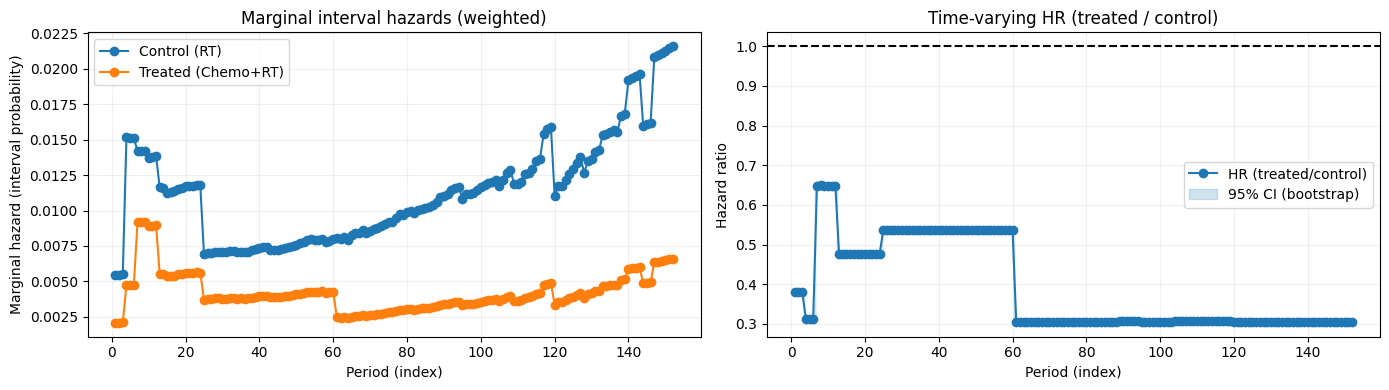

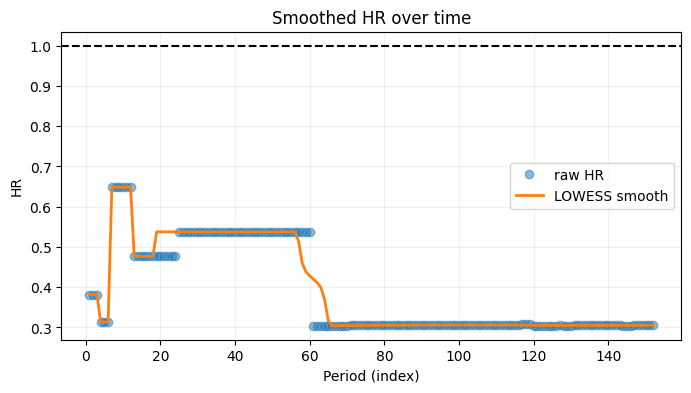

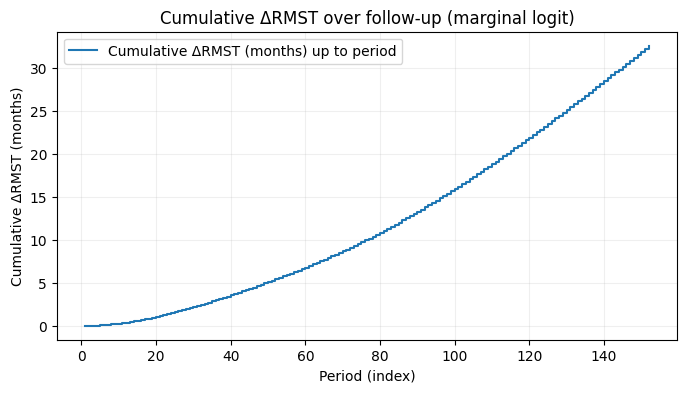

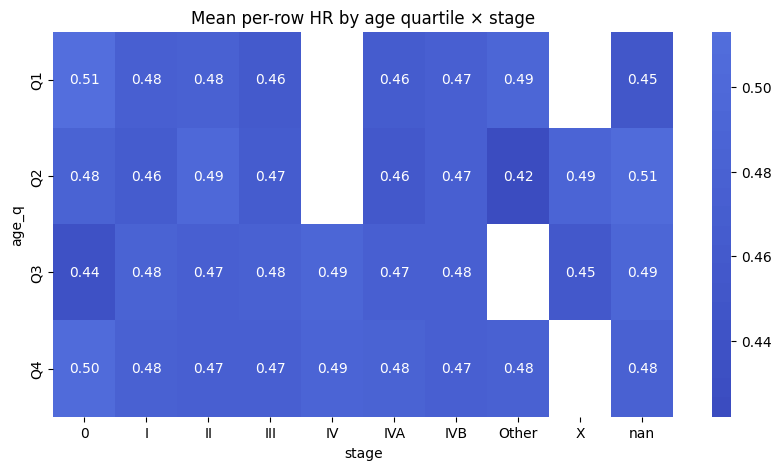

Saved timevarying_summary_by_period.csv and plots to outputs


In [ ]:
# Time-varying effects visualization (period hazards, HR, cumulative ΔRMST, smoothed HR)


# setting variables
INTERVAL_DAYS = globals().get('INTERVAL_DAYS', globals().get('interval_days', 30))
PERIOD_LABELS = globals().get('PERIOD_LABELS', globals().get('period_labels', ['0-3','4-6','7-12','13-24','25-60','60+']))
TAU_MONTHS = globals().get('TAU_MONTHS', globals().get('tau_months', 36))
TAU_DAYS = TAU_MONTHS * INTERVAL_DAYS

# Required objects
if 'pp_test' not in globals():
    raise RuntimeError("pp_test not found in workspace. You need pp_test person-period table.")
if 'logit' not in globals():
    # try to load pooled-logit if saved
    lp = os.path.join(outdir, "pooled_logit_logreg_saga.joblib")
    if os.path.exists(lp):
        logit = joblib.load(lp)
        print("Loaded pooled-logit from", lp)
    else:
        raise RuntimeError("pooled-logit model not found in workspace or outputs/.")

if 'build_X_for_pp' not in globals():
    raise RuntimeError("build_X_for_pp function not found. Define or load it.")

pp = pp_test.copy().reset_index(drop=True)

# Build X for pp_test aligned to pooled-logit and predict hazards under treated/control
X_pp = build_X_for_pp(pp)
# If pooled-logit expects model_columns, reindex X_pp
if 'model_columns' in globals():
    X_pp = X_pp.reindex(columns=model_columns, fill_value=0.0)

# create two counterfactual feature tables
X_t = X_pp.copy(); X_t['treatment'] = 1
X_c = X_pp.copy(); X_c['treatment'] = 0
# recompute interactions for period dummies
period_cols = [c for c in X_pp.columns if str(c).startswith('period_bin')]
for pcol in period_cols:
    X_t[f'treat_x_{pcol}'] = X_t['treatment'] * X_t.get(pcol, 0)
    X_c[f'treat_x_{pcol}'] = X_c['treatment'] * X_c.get(pcol, 0)

# make sure columns align to pooled-logit
if 'model_columns' in globals():
    X_t = X_t.reindex(columns=model_columns, fill_value=0.0)
    X_c = X_c.reindex(columns=model_columns, fill_value=0.0)

pp['p_treated'] = logit.predict_proba(X_t)[:,1]
pp['p_control'] = logit.predict_proba(X_c)[:,1]

# prefer a weight column if present
if 'sw' in pp.columns:
    pp['w_for_agg'] = pp['sw'].fillna(1.0).astype(float)
elif 'sw_trunc' in pp.columns:
    pp['w_for_agg'] = pp['sw_trunc'].fillna(1.0).astype(float)
else:
    pp['w_for_agg'] = 1.0

# Aggregate marginal hazards by period (weighted)
periods = sorted(pp['period'].unique())
haz_treated = []
haz_control = []
period_len = []   # mean length or interval_days
for p in periods:
    g = pp[pp['period'] == p]
    if g.shape[0] == 0:
        haz_treated.append(np.nan); haz_control.append(np.nan); period_len.append(INTERVAL_DAYS); continue
    wt = g['w_for_agg'].values
    haz_treated.append(np.average(g['p_treated'].values, weights=wt))
    haz_control.append(np.average(g['p_control'].values, weights=wt))
    if 'period_length' in g.columns:
        period_len.append(int(g['period_length'].dropna().median()))
    else:
        period_len.append(INTERVAL_DAYS)

haz_treated = np.array(haz_treated)
haz_control = np.array(haz_control)
period_len = np.array(period_len)

# compte period-level HR
with np.errstate(divide='ignore', invalid='ignore'):
    hr_period = np.divide(haz_treated, haz_control)
    hr_period[~np.isfinite(hr_period)] = np.nan

#Bootstrap CI for HR -->cluster botstrap by patient
def bootstrap_hr(pp_df, build_fn, model, model_cols=None, n_boot=200, seed=42):
    rng = np.random.RandomState(seed)
    pids = pp_df['patient_id'].unique()
    n_p = len(pids)
    max_period = int(pp_df['period'].max())
    boot_hrs = []
    for b in tqdm(range(n_boot), desc="bootstrap"):
        sampled = rng.choice(pids, size=n_p, replace=True)
        boot_pp = pd.concat([pp_df[pp_df['patient_id'] == pid] for pid in sampled], ignore_index=True)
        Xb = build_fn(boot_pp)
        if model_cols is not None:
            Xb = Xb.reindex(columns=model_cols, fill_value=0.0)
        Xt = Xb.copy(); Xt['treatment'] = 1
        Xc = Xb.copy(); Xc['treatment'] = 0
        for pcol in [c for c in Xb.columns if c.startswith('period_bin')]:
            Xt[f'treat_x_{pcol}'] = Xt['treatment'] * Xt.get(pcol,0)
            Xc[f'treat_x_{pcol}'] = Xc['treatment'] * Xc.get(pcol,0)
        if model_cols is not None:
            Xt = Xt.reindex(columns=model_cols, fill_value=0.0)
            Xc = Xc.reindex(columns=model_cols, fill_value=0.0)
        pt = model.predict_proba(Xt)[:,1]; pc = model.predict_proba(Xc)[:,1]
        boot_pp['pt'] = pt; boot_pp['pc'] = pc
        # weighted average per period
        weights = boot_pp.get('sw', boot_pp.get('sw_trunc', 1.0))
        pm_t = boot_pp.groupby('period').apply(lambda g: np.average(g['pt'], weights=g.get('sw', g.get('sw_trunc', pd.Series(1.0)).fillna(1.0))))
        pm_c = boot_pp.groupby('period').apply(lambda g: np.average(g['pc'], weights=g.get('sw', g.get('sw_trunc', pd.Series(1.0)).fillna(1.0))))
        ph_t = np.array([pm_t.get(p, 0.0) for p in periods])
        ph_c = np.array([pm_c.get(p, 0.0) for p in periods])
        with np.errstate(divide='ignore', invalid='ignore'):
            hr = ph_t / ph_c
            hr[~np.isfinite(hr)] = np.nan
        boot_hrs.append(hr)
    return np.vstack(boot_hrs)   # shape (n_boot, n_periods)

# toggle boots
RUN_BOOT = True
N_BOOT = 300
hr_lo = hr_up = None
if RUN_BOOT:
    print("Running cluster bootstrap to get HR CIs (may take a while)...")
    boot_hr = bootstrap_hr(pp, build_X_for_pp, logit, model_cols=globals().get('model_columns', None), n_boot=N_BOOT, seed=42)
    hr_lo = np.nanpercentile(boot_hr, 2.5, axis=0)
    hr_up = np.nanpercentile(boot_hr, 97.5, axis=0)
else:
    hr_lo = np.full_like(hr_period, np.nan)
    hr_up = np.full_like(hr_period, np.nan)

# 4) Plot hazard curves and HR with CI
fig, axes = plt.subplots(1,2, figsize=(14,4))
ax = axes[0]
ax.plot(periods, haz_control, marker='o', label='Control (RT)')
ax.plot(periods, haz_treated, marker='o', label='Treated (Chemo+RT)')
ax.set_xlabel('Period (index)')
ax.set_ylabel('Marginal hazard (interval probability)')
ax.set_title('Marginal interval hazards (weighted)')
ax.legend(); ax.grid(alpha=0.2)

ax2 = axes[1]
ax2.plot(periods, hr_period, marker='o', label='HR (treated/control)')
if RUN_BOOT:
    ax2.fill_between(periods, hr_lo, hr_up, color='C0', alpha=0.2, step='mid', label='95% CI (bootstrap)')
ax2.axhline(1.0, color='k', linestyle='--')
ax2.set_xlabel('Period (index)')
ax2.set_ylabel('Hazard ratio')
ax2.set_title('Time-varying HR (treated / control)')
ax2.legend(); ax2.grid(alpha=0.2)
plt.tight_layout()
plt.savefig(os.path.join(outdir, "timevarying_hazards_hr.png"), dpi=150)
plt.show()

# Lowess-smoothed HR (helps identify peaks/troughs)
# remove NaNs for smoothing
valid_idx = ~np.isnan(hr_period)
if valid_idx.sum() > 3:
    lo = lowess(hr_period[valid_idx], np.array(periods)[valid_idx], frac=0.2, return_sorted=False)
    plt.figure(figsize=(8,4))
    plt.plot(periods, hr_period, 'o', alpha=0.5, label='raw HR')
    plt.plot(np.array(periods)[valid_idx], lo, '-', linewidth=2, label='LOWESS smooth')
    plt.axhline(1.0, color='k', linestyle='--')
    plt.xlabel('Period (index)'); plt.ylabel('HR'); plt.title('Smoothed HR over time')
    plt.legend(); plt.grid(alpha=0.2)
    plt.savefig(os.path.join(outdir, "smoothed_hr.png"), dpi=150)
    plt.show()

# Cumulative ΔRMST over time (marginalized)
# For each period j compute mean survival at start and contribution to RMST up to that period
# compute survival curves from marginal hazards: S_j = prod_{i<=j} (1 - h_i)
S_t = np.cumprod(1.0 - haz_treated)
S_c = np.cumprod(1.0 - haz_control)
# RMST incremental per period = S_{j-1} * period_length
S_prev_t = np.concatenate(([1.0], S_t[:-1]))
S_prev_c = np.concatenate(([1.0], S_c[:-1]))
delta_rmst_by_period = (S_prev_t - S_prev_c) * period_len  # days gained in each period
cumul_delta = np.cumsum(delta_rmst_by_period)  # days
plt.figure(figsize=(8,4))
plt.step(periods, cumul_delta/30.0, where='post', label=f'Cumulative ΔRMST (months) up to period')
plt.xlabel('Period (index)'); plt.ylabel('Cumulative ΔRMST (months)')
plt.title('Cumulative ΔRMST over follow-up (marginal logit)')
plt.grid(alpha=0.2); plt.legend()
plt.savefig(os.path.join(outdir,"cumulative_delta_rmst.png"), dpi=150)
plt.show()

#Heatmap ---> HR by age quartile × stage ( 'age' and 'stage' in pp_test/test_patients)
#compute period-bin average HR per subgroup and then show a heatmap for a chosen period-bin
if 'age' in pp.columns and 'stage' in pp.columns:
    pp['age_q'] = pd.qcut(pp['age'].fillna(pp['age'].median()), q=4, labels=['Q1','Q2','Q3','Q4'])
    # compute avg hazard ratio by subgroup across all periods (or choose period)
    # For clarity buildHR per patient aggrfgrated across early periods --->first 12 months -> periods where period_bin in first two bins)
    # we compute average HR per subgroup across all observed periods:
    pp['hr_row'] = pp['p_treated'] / pp['p_control']
    pp.loc[~np.isfinite(pp['hr_row']), 'hr_row'] = np.nan
    heat = pp.groupby(['age_q','stage'])['hr_row'].mean().unstack()
    plt.figure(figsize=(10,5))
    sns.heatmap(heat, annot=True, fmt=".2f", center=1.0, cmap='coolwarm')
    plt.title('Mean per-row HR by age quartile × stage')
    plt.savefig(os.path.join(outdir,"heatmap_hr_age_stage.png"), dpi=150)
    plt.show()
else:
    print("Skipping heatmap: 'age' or 'stage' not present in pp_test.")

# Save numeric summary
summary_df = pd.DataFrame({
    'period': periods,
    'haz_treated': haz_treated,
    'haz_control': haz_control,
    'period_length_days': period_len,
    'hr': hr_period,
    'hr_lo': hr_lo,
    'hr_up': hr_up,
    'S_treated': S_t,
    'S_control': S_c,
    'delta_rmst_period_days': delta_rmst_by_period
})
summary_df.to_csv(os.path.join(outdir, "timevarying_summary_by_period.csv"), index=False)
print("Saved timevarying_summary_by_period.csv and plots to", outdir)



# **Progression free survival**

In [ ]:

# PFS: PERSON-PERIOD + POOLED LOGIT
# PFS-specific columns
id_col_pfs     = 'patient_id'
time_pfs_col   = 'time_pfs_days'
event_pfs_col  = 'event_pfs'
treat_col_pfs  = 'treatment'   # same as OS
interval_days  = 30
min_count_for_keep = 40
period_bins    = [0,3,6,12,24,60,np.inf]
period_labels  = ['0-3','4-6','7-12','13-24','25-60','60+']

# Make a copy (reuse same train_df/test_df)
train_patients_pfs = train_df.copy()
test_patients_pfs  = test_df.copy()

def expand_to_pp_pfs(df_patients, interval_days=30):
    """
    Person-period expansion for PFS, parallel to OS version.
    event_interval_pfs = 1 if PFS event happens in that period.
    """
    records = []
    for _, r in df_patients.iterrows():
        pid = r[id_col_pfs]
        # time in days to PFS event or censoring
        T = int(np.ceil(r[time_pfs_col])) if pd.notna(r[time_pfs_col]) and r[time_pfs_col] > 0 else 0
        n_periods = int(np.ceil(T / interval_days)) if T > 0 else 0

        for p in range(1, n_periods+1):
            # event in last period if event_pfs == 1
            event_interval_pfs = 1 if (r[event_pfs_col] == 1 and p == n_periods) else 0

            rec = {
                id_col_pfs: pid,
                'period': p,
                'event_interval_pfs': event_interval_pfs,
                'treatment': int(r[treat_col_pfs]),
                'time_since_rt_days': p * interval_days
            }
            # static covariates (same as OS)
            for c in ['age','sex','ecog_ps','smoking_status_clean','smoking_py_clean',
                      'primary_site_group','subsite_clean','stage','hpv_clean']:
                if c in r.index:
                    rec[c] = r[c]
            # sample weight (same IPTW column as OS)
            if 'sw_trunc_logit_simple' in r.index:
                rec['sw'] = r['sw_trunc_logit_simple']

            records.append(rec)
    return pd.DataFrame(records)

pp_train_pfs = expand_to_pp_pfs(train_patients_pfs, interval_days=interval_days)
pp_test_pfs  = expand_to_pp_pfs(test_patients_pfs, interval_days=interval_days)
print("PFS PP shapes: train", pp_train_pfs.shape, " test", pp_test_pfs.shape)

# Collapse rare categories --parallel to overall survival)

def collapse_train_map(s_series, min_count=min_count_for_keep, other_label='Other'):
    vc = s_series.fillna('nan').astype(str).value_counts(dropna=False)
    keep = set(vc[vc >= min_count].index.astype(str))
    return lambda s: s.astype(str).where(s.astype(str).isin(keep), other_label)

cat_to_collapse_pfs = [c for c in ['subsite_clean','pathology_group','primary_site_group','stage']
                       if c in pp_train_pfs.columns]
collapse_maps_pfs = {}
for c in cat_to_collapse_pfs:
    mapper = collapse_train_map(pp_train_pfs[c], min_count=min_count_for_keep)
    pp_train_pfs[c] = mapper(pp_train_pfs[c].fillna('nan').astype(str))
    pp_test_pfs[c]  = mapper(pp_test_pfs[c].fillna('nan').astype(str))
    collapse_maps_pfs[c] = list(pp_train_pfs[c].unique())

# Period bins

pp_train_pfs['period_month'] = pp_train_pfs['period'].astype(int)
pp_test_pfs['period_month']  = pp_test_pfs['period'].astype(int)

pp_train_pfs['period_bin'] = pd.cut(pp_train_pfs['period_month'], bins=period_bins,
                                    labels=period_labels, right=True)
pp_test_pfs['period_bin']  = pd.cut(pp_test_pfs['period_month'], bins=period_bins,
                                    labels=period_labels, right=True)

#Feature selection

cat_cols_pfs = [c for c in ['period_bin','sex','smoking_status_clean',
                            'primary_site_group','subsite_clean','stage','hpv_clean']
                if c in pp_train_pfs.columns]
num_cols_pfs = [c for c in ['age','ecog_ps','smoking_py_clean','time_since_rt_days']
                if c in pp_train_pfs.columns]

#Dummies + numeric (train / test)

X_cat_train_pfs = pd.get_dummies(pp_train_pfs[cat_cols_pfs].astype(str), drop_first=True)
X_cat_test_pfs  = pd.get_dummies(pp_test_pfs[cat_cols_pfs].astype(str), drop_first=True)
X_cat_test_pfs  = X_cat_test_pfs.reindex(columns=X_cat_train_pfs.columns, fill_value=0.0)

X_num_train_pfs = pp_train_pfs[num_cols_pfs].copy()
X_num_test_pfs  = pp_test_pfs[num_cols_pfs].copy()

for c in X_num_train_pfs.columns:
    X_num_train_pfs[c] = pd.to_numeric(X_num_train_pfs[c], errors='coerce')
    X_num_test_pfs[c]  = pd.to_numeric(X_num_test_pfs[c], errors='coerce')

train_medians_pp_pfs = X_num_train_pfs.median()
X_num_train_pfs = X_num_train_pfs.fillna(train_medians_pp_pfs)
X_num_test_pfs  = X_num_test_pfs.fillna(train_medians_pp_pfs)

# 5) Scale numeric

scaler_pfs = StandardScaler()
X_num_train_scaled_pfs = pd.DataFrame(
    scaler_pfs.fit_transform(X_num_train_pfs),
    columns=X_num_train_pfs.columns,
    index=X_num_train_pfs.index
)
X_num_test_scaled_pfs = pd.DataFrame(
    scaler_pfs.transform(X_num_test_pfs),
    columns=X_num_test_pfs.columns,
    index=X_num_test_pfs.index
)

# Save scaler & collapse maps & medians for PFS
joblib.dump(scaler_pfs,         "outputs/pp_pfs_scaler.joblib")
joblib.dump(collapse_maps_pfs,  "outputs/pp_pfs_collapse_maps.joblib")
joblib.dump(train_medians_pp_pfs, "outputs/pp_pfs_train_medians.joblib")

# Combine cat + num

X_train_pfs = pd.concat(
    [X_cat_train_pfs.reset_index(drop=True),
     X_num_train_scaled_pfs.reset_index(drop=True)],
    axis=1
)
X_test_pfs  = pd.concat(
    [X_cat_test_pfs.reset_index(drop=True),
     X_num_test_scaled_pfs.reset_index(drop=True)],
    axis=1
)

# Add treatment
X_train_pfs['treatment'] = pd.to_numeric(pp_train_pfs['treatment'], errors='coerce').fillna(0).astype(int)
X_test_pfs['treatment']  = pd.to_numeric(pp_test_pfs['treatment'], errors='coerce').fillna(0).astype(int)

# Treatment × period dummies
period_dummy_cols_pfs = [c for c in X_train_pfs.columns if c.startswith('period_bin')]
for pcol in period_dummy_cols_pfs:
    X_train_pfs[f'treat_x_{pcol}'] = X_train_pfs['treatment'] * X_train_pfs[pcol]
    X_test_pfs[f'treat_x_{pcol}']  = X_test_pfs['treatment'] * X_test_pfs.get(pcol, 0)

# Align test columns exactly
X_test_pfs = X_test_pfs.reindex(columns=X_train_pfs.columns, fill_value=0.0)

# Response & weights for PFS pooled logit

y_train_pfs = pp_train_pfs['event_interval_pfs'].astype(int).values
y_test_pfs  = pp_test_pfs['event_interval_pfs'].astype(int).values

if 'sw' in pp_train_pfs.columns:
    w_train_pfs = pp_train_pfs['sw'].astype(float).values
else:
    w_train_pfs = np.ones(len(y_train_pfs))
w_train_pfs = np.clip(w_train_pfs, 0.001, 10.0)

#Fit regularized PFS logistic

logit_pfs = LogisticRegression(
    penalty='l2',
    C=0.5,
    solver='saga',
    max_iter=5000,
    n_jobs=-1
)
logit_pfs.fit(X_train_pfs, y_train_pfs, sample_weight=w_train_pfs)

# Evaluate PFS model
pred_train_pfs = logit_pfs.predict_proba(X_train_pfs)[:,1]
pred_test_pfs  = logit_pfs.predict_proba(X_test_pfs)[:,1]
auc_train_pfs  = roc_auc_score(y_train_pfs, pred_train_pfs)
auc_test_pfs   = roc_auc_score(y_test_pfs, pred_test_pfs)
brier_pfs      = brier_score_loss(y_test_pfs, pred_test_pfs)

print(f"[PFS] Train AUC: {auc_train_pfs:.3f} | Test AUC: {auc_test_pfs:.3f} | Test Brier: {brier_pfs:.5f}")
print("[PFS] Max |coef|:", np.max(np.abs(logit_pfs.coef_)))

# Save PFS model artifacts
joblib.dump(logit_pfs, "outputs/pooled_logit_pfs_logreg_saga.joblib")
pd.Series(X_train_pfs.columns, name='model_columns').to_csv(
    "outputs/pooled_logit_pfs_model_columns.csv",
    index=False
)
coef_pfs = pd.Series(logit_pfs.coef_[0], index=X_train_pfs.columns)
coef_pfs_df = pd.DataFrame({'term': coef_pfs.index,
                            'coef': coef_pfs.values,
                            'exp_coef': np.exp(coef_pfs.values)})
coef_pfs_df.to_csv("outputs/pooled_logit_pfs_coefficients.csv", index=False)

print("Pooled-logit PFS model trained and saved to outputs/ (pfs artifacts).")


# PFS: build_X_for_pp_pfs & survival prediction


# load PFS artifacts if not in memory
pfs_model_cols_path = "outputs/pooled_logit_pfs_model_columns.csv"
model_columns_pfs = pd.read_csv(pfs_model_cols_path)['model_columns'].tolist() \
    if 'model_columns_pfs' not in globals() else model_columns_pfs

scaler_pfs = joblib.load("outputs/pp_pfs_scaler.joblib")
train_medians_pp_pfs = joblib.load("outputs/pp_pfs_train_medians.joblib")
collapse_maps_pfs = joblib.load("outputs/pp_pfs_collapse_maps.joblib")
logit_pfs = joblib.load("outputs/pooled_logit_pfs_logreg_saga.joblib")

def build_X_for_pp_pfs(df_pp):
    """
    builder for PFS person-period design matrix:
    - uses same cat/num structure as training
    - fills all NaNs
    - aligns to model_columns_pfs
    """
    df = df_pp.copy()

    # Apply collapse maps
    for c, keep in collapse_maps_pfs.items():
        if c in df.columns:
            df[c] = df[c].astype(str).where(df[c].astype(str).isin(keep), 'Other')

    #  Ensure period_month & period_bin
    if 'period_month' not in df.columns:
        df['period_month'] = df['period'].astype(int)

    if 'period_bin' not in df.columns:
        df['period_bin'] = pd.cut(
            df['period_month'],
            bins=period_bins,
            labels=period_labels,
            right=True
        )

    # feature sets as training
    # categorical
    global cat_cols_pfs, num_cols_pfs   # these were defined in training block
    cat_cols_local = [c for c in cat_cols_pfs if c in df.columns]

    if cat_cols_local:
        Xc = pd.get_dummies(df[cat_cols_local].astype(str), drop_first=True)
    else:
        Xc = pd.DataFrame(index=df.index)

    #  Numeric: force same columns as training & fill + scale
    # numeric columns used in training are exactly train_medians_pp_pfs.index
    num_cols_train = list(train_medians_pp_pfs.index)
    Xn = df.reindex(columns=num_cols_train)  # even if some missing from df

    # coerce to numeric
    for c in Xn.columns:
        Xn[c] = pd.to_numeric(Xn[c], errors='coerce')

    # fill NaNs with *training* medians
    Xn = Xn.fillna(train_medians_pp_pfs)

    # scale
    try:
        Xn_scaled = pd.DataFrame(
            scaler_pfs.transform(Xn),
            columns=Xn.columns,
            index=Xn.index
        )
    except Exception as e:
        print("Warning: scaler_pfs.transform failed in build_X_for_pp_pfs:", e)
        Xn_scaled = Xn

    # Combine cat + num
    Xnew = pd.concat(
        [Xc.reset_index(drop=True), Xn_scaled.reset_index(drop=True)],
        axis=1
    )

    # Treatment column
    if 'treatment' in df.columns:
        Xnew['treatment'] = pd.to_numeric(
            df['treatment'],
            errors='coerce'
        ).fillna(0).astype(int)
    else:
        Xnew['treatment'] = 0

    # Treatment × period dummies
    period_dummy_cols_local = [c for c in Xnew.columns if c.startswith('period_bin')]
    for pcol in period_dummy_cols_local:
        Xnew[f'treat_x_{pcol}'] = Xnew['treatment'] * Xnew[pcol]

    # Align to model_columns_pfs (training design matrix)
    Xnew = Xnew.reindex(columns=model_columns_pfs, fill_value=0.0)


    Xnew = Xnew.fillna(0.0)

    return Xnew

def predict_pfs_survival_from_pp(df_pp, patient_ids=None):
    """
    Predict **PFS survival** (no progression or death) using pooled-logit PFS model.
    """
    if patient_ids is None:
        patient_ids = df_pp['patient_id'].unique()
    out_rows = []
    for pid in patient_ids:
        rows = df_pp[df_pp['patient_id'] == pid].sort_values('period')
        if rows.shape[0] == 0:
            continue
        Xrows = build_X_for_pp_pfs(rows)
        probs = logit_pfs.predict_proba(Xrows)[:,1]
        surv = np.cumprod(1 - probs)
        out_rows.append(pd.DataFrame({
            'patient_id': pid,
            'period': rows['period'].values,
            'interval_hazard_pfs': probs,
            'survival_pfs_at_period_end': surv
        }))
    return pd.concat(out_rows, ignore_index=True)

# quick test: first 5 patients
example_pids_pfs = pp_test_pfs['patient_id'].unique()[:5]
surv_examples_pfs = predict_pfs_survival_from_pp(pp_test_pfs, patient_ids=example_pids_pfs)
print(surv_examples_pfs.head(12))


PFS PP shapes: train (112534, 15)  test (35566, 15)
[PFS] Train AUC: 0.747 | Test AUC: 0.752 | Test Brier: 0.00831
[PFS] Max |coef|: 1.3417331350202637
Pooled-logit PFS model trained and saved to outputs/ (pfs artifacts).
      patient_id  period  interval_hazard_pfs  survival_pfs_at_period_end
0   RADCURE-0006       1             0.029740                    0.970260
1   RADCURE-0006       2             0.029884                    0.941265
2   RADCURE-0006       3             0.030028                    0.913001
3   RADCURE-0006       4             0.097801                    0.823708
4   RADCURE-0006       5             0.098241                    0.742787
5   RADCURE-0006       6             0.098682                    0.669487
6   RADCURE-0006       7             0.084931                    0.612627
7   RADCURE-0006       8             0.085318                    0.560359
8   RADCURE-0006       9             0.085706                    0.512333
9   RADCURE-0006      10             0

In [ ]:
# PFS pooled-logit artifacts
TAU_MONTHS =36
TAU_DAYS_PFS = TAU_MONTHS * INTERVAL_DAYS

pfs_model_candidate = [
    "pooled_logit_pfs_logreg_saga"
]

logit_pfs = joblib.load("outputs/pooled_logit_pfs_logreg_saga.joblib")

# model_columns for PFS
pfs_cols_candidates = [
    "pooled_logit_pfs_model_columns.csv",
    "pfs_model_columns.csv"
]

model_columns_pfs = None
for fn in pfs_cols_candidates:
    path = os.path.join(outdir, fn)
    if os.path.exists(path):
        tmp = pd.read_csv(path)
        # handle single-column csv with name
        if tmp.shape[1] == 1:
            model_columns_pfs = tmp.iloc[:, 0].astype(str).tolist()
        else:
            # assume first col has names
            model_columns_pfs = tmp.iloc[:,0].astype(str).tolist()
        print("Loaded PFS model_columns from:", path)
        break

if model_columns_pfs is None:
    raise RuntimeError("No PFS model_columns CSV found in outputs/. Check filenames.")

# PFS scaler & medians for person-period
scaler_pfs_candidates = ["pp_pfs_scaler.joblib"]
pp_train_medians_pfs_candidates = ["pp_pfs_collapse_maps.joblib"]
collapse_maps_pfs_candidates = ["outputs/pp_pfs_train_medians.joblib"]

scaler_pfs = None
for fn in scaler_pfs_candidates:
    path = os.path.join(outdir, fn)
    if os.path.exists(path):
        scaler_pfs = joblib.load(path)
        print("Loaded PFS scaler from:", path)
        break

if scaler_pfs is None:
    print("WARNING: PFS scaler not found; will not scale numeric PFS PP features.")

train_medians_pp_pfs = None
for fn in pp_train_medians_pfs_candidates:
    path = os.path.join(outdir, fn)
    if os.path.exists(path):
        try:
            train_medians_pp_pfs = joblib.load(path)
        except Exception:
            train_medians_pp_pfs = pd.read_csv(path).set_index("feature")["median"]
        print("Loaded PFS pp_train_medians from:", path)
        break

if train_medians_pp_pfs is None:
    print("WARNING: PFS pp_train_medians not found; will use in-sample medians at runtime.")

collapse_maps_pfs = {}
for fn in collapse_maps_pfs_candidates:
    path = os.path.join(outdir, fn)
    if os.path.exists(path):
        try:
            collapse_maps_pfs = joblib.load(path)
            print("Loaded PFS collapse_maps from:", path)
            break
        except Exception as e:
            print("Found collapse map file but failed to load:", path, "error:", e)

# if still empty but pp_train_pfs exists, derive trivial maps
if (not collapse_maps_pfs) and "pp_train_pfs" in globals():
    for c in ['subsite_clean','pathology_group','primary_site_group','stage']:
        if c in pp_train_pfs.columns:
            collapse_maps_pfs[c] = list(pp_train_pfs[c].dropna().astype(str).unique())
    print("Built simple collapse_maps_pfs from pp_train_pfs columns:", list(collapse_maps_pfs.keys()))
period_bins = [0, 3, 6, 12, 24, 60, np.inf]
period_labels = ['0-3','4-6','7-12','13-24','25-60','60+']

def build_X_for_pp_pfs(df_pp):
    """
    Safe feature builder for PFS person-period rows,
    aligned to model_columns_pfs and free of NaNs.
    """
    df = df_pp.copy()

    # --- collapse high-cardinality categories using precomputed maps ---
    for c, keep in (collapse_maps_pfs.items() if collapse_maps_pfs else []):
        if c in df.columns:
            df[c] = df[c].astype(str).where(df[c].astype(str).isin(keep), 'Other')

    # period binning
    if "period_month" not in df.columns:
        if "period" in df.columns:
            df["period_month"] = df["period"].astype(int)
        else:
            df["period_month"] = 1

    if "period_bin" not in df.columns:
        df["period_bin"] = pd.cut(
            df["period_month"],
            bins=period_bins,
            labels=period_labels,
            right=True
        )

    #  categorical dummies
    cat_cols_local = [c for c in [
        "period_bin","sex","smoking_status_clean",
        "primary_site_group","subsite_clean","stage","hpv_clean"
    ] if c in df.columns]

    if cat_cols_local:
        Xc = pd.get_dummies(df[cat_cols_local].astype(str), drop_first=True)
    else:
        Xc = pd.DataFrame(index=df.index)

    #numeric columns
    num_cols_local = [c for c in ["age","ecog_ps","smoking_py_clean","time_since_rt_days"] if c in df.columns]
    if num_cols_local:
        Xn = df[num_cols_local].copy()
        for c in Xn.columns:
            Xn[c] = pd.to_numeric(Xn[c], errors="coerce")
        if train_medians_pp_pfs is not None:
            # train_medians_pp_pfs may be Series or dict
            if isinstance(train_medians_pp_pfs, (pd.Series, dict)):
                fill_vals = dict(train_medians_pp_pfs)
            else:
                fill_vals = {}
            Xn = Xn.fillna(pd.Series(fill_vals))
        else:
            Xn = Xn.fillna(Xn.median())
        # scale
        if scaler_pfs is not None:
            try:
                Xn_scaled = pd.DataFrame(
                    scaler_pfs.transform(Xn),
                    columns=Xn.columns,
                    index=Xn.index
                )
            except Exception as e:
                print("PFS scaler failed, using unscaled numeric:", e)
                Xn_scaled = Xn
        else:
            Xn_scaled = Xn
    else:
        Xn_scaled = pd.DataFrame(index=df.index)

    #combine
    Xnew = pd.concat(
        [Xc.reset_index(drop=True), Xn_scaled.reset_index(drop=True)],
        axis=1
    )

    # treatment indicator
    if "treatment" in df.columns:
        Xnew["treatment"] = pd.to_numeric(df["treatment"], errors="coerce").fillna(0).astype(int).values
    else:
        Xnew["treatment"] = 0

    # treatment × period_bin interactions
    period_dummy_cols_local = [c for c in Xnew.columns if str(c).startswith("period_bin")]
    for pcol in period_dummy_cols_local:
        Xnew[f"treat_x_{pcol}"] = Xnew["treatment"] * Xnew[pcol]

    # align to PFS model columns (no NaNs)
    if model_columns_pfs is not None:
        for c in model_columns_pfs:
            if c not in Xnew.columns:
                Xnew[c] = 0.0
        Xnew = Xnew[model_columns_pfs]

    # fill NaN
    Xnew = Xnew.fillna(0.0)

    return Xnew
def rmst_from_period_hazards(hazards, period_lengths, tau_days):
    """
    Discrete-time RMST from per-period hazards and period lengths.
    hazards: array-like of probabilities of event in interval
    period_lengths: array-like of interval lengths (days)
    """
    surv_prev = 1.0
    rmst = 0.0
    cum_days = 0
    for h, plen in zip(hazards, period_lengths):
        if cum_days >= tau_days:
            break
        use_len = min(plen, tau_days - cum_days)
        rmst += surv_prev * use_len
        surv_prev *= (1.0 - h)
        cum_days += plen
    return float(rmst)


def compute_patient_rmst_from_pp_pfs(pp_df, logit_model, tau_days, interval_days=30):
    """
    Compute per-patient RMST_PFS under:
      - control (treatment=0)
      - treated (treatment=1)

    using the PFS pooled-logit model.
    """
    patient_ids = pp_df[id_col_pfs].unique()
    out = []

    for pid in tqdm(patient_ids, desc="RMST PFS per patient"):
        rows_pp = pp_df[pp_df[id_col_pfs] == pid].sort_values("period")
        if rows_pp.shape[0] == 0:
            continue

        # period lengths
        if "period_length" in rows_pp.columns:
            period_lengths = rows_pp["period_length"].fillna(interval_days).astype(int).tolist()
        elif ("period_start" in rows_pp.columns) and ("period_end" in rows_pp.columns):
            period_lengths = (rows_pp["period_end"] - rows_pp["period_start"]).fillna(interval_days).astype(int).tolist()
        else:
            period_lengths = [interval_days] * rows_pp.shape[0]

        # build X for "observed" rows, then overwrite treatment for counterfactuals
        Xrows = build_X_for_pp_pfs(rows_pp.copy())

        # treated
        X_treated = Xrows.copy()
        X_treated["treatment"] = 1
        for pcol in [c for c in X_treated.columns if str(c).startswith("period_bin")]:
            X_treated[f"treat_x_{pcol}"] = X_treated["treatment"] * X_treated.get(pcol, 0)

        # control
        X_control = Xrows.copy()
        X_control["treatment"] = 0
        for pcol in [c for c in X_control.columns if str(c).startswith("period_bin")]:
            X_control[f"treat_x_{pcol}"] = X_control["treatment"] * X_control.get(pcol, 0)

        # predict hazards
        probs_t = logit_model.predict_proba(X_treated)[:, 1]
        probs_c = logit_model.predict_proba(X_control)[:, 1]

        rmst_t = rmst_from_period_hazards(probs_t, period_lengths, tau_days)
        rmst_c = rmst_from_period_hazards(probs_c, period_lengths, tau_days)
        delta = rmst_t - rmst_c

        # optional: average HR over periods
        with np.errstate(divide="ignore", invalid="ignore"):
            hr_per_period = np.divide(probs_t, probs_c)
            hr_per_period[~np.isfinite(hr_per_period)] = np.nan
        if np.all(np.isnan(hr_per_period)):
            avg_hr = np.nan
        else:
            mask = ~np.isnan(hr_per_period)
            avg_hr = np.average(hr_per_period[mask], weights=np.array(period_lengths)[mask])

        out.append({
            "patient_id": pid,
            "rmst_pfs_treated_days": rmst_t,
            "rmst_pfs_control_days": rmst_c,
            "delta_rmst_pfs_days": delta,
            "avg_hr_pfs_patient": avg_hr,
            "num_periods_pfs": rows_pp.shape[0]
        })

    return pd.DataFrame(out)
if "pp_train_pfs" not in globals() or "pp_test_pfs" not in globals():
    raise RuntimeError("pp_train_pfs / pp_test_pfs must exist (PFS person-period tables).")

df_rmst_pfs_train = compute_patient_rmst_from_pp_pfs(pp_train_pfs, logit_pfs, TAU_DAYS_PFS, interval_days=INTERVAL_DAYS)
df_rmst_pfs_test  = compute_patient_rmst_from_pp_pfs(pp_test_pfs,  logit_pfs, TAU_DAYS_PFS, interval_days=INTERVAL_DAYS)

df_rmst_pfs_all = pd.concat([df_rmst_pfs_train, df_rmst_pfs_test], ignore_index=True)
pfs_rmst_path = os.path.join(outdir, "cf_vs_logit_rmst_pfs_36m_per_patient_fixed_all.csv")
df_rmst_pfs_all.to_csv(pfs_rmst_path, index=False)
print("Saved PFS per-patient RMST to:", pfs_rmst_path)
print("Train PFS RMST rows:", df_rmst_pfs_train.shape[0], "Test PFS RMST rows:", df_rmst_pfs_test.shape[0])



Loaded PFS model_columns from: outputs/pooled_logit_pfs_model_columns.csv
Loaded PFS scaler from: outputs/pp_pfs_scaler.joblib
Loaded PFS pp_train_medians from: outputs/pp_pfs_collapse_maps.joblib
Built simple collapse_maps_pfs from pp_train_pfs columns: ['subsite_clean', 'primary_site_group', 'stage']


RMST PFS per patient:   0%|          | 0/2397 [00:00<?, ?it/s]

RMST PFS per patient:   0%|          | 0/797 [00:00<?, ?it/s]

Saved PFS per-patient RMST to: outputs/cf_vs_logit_rmst_pfs_36m_per_patient_fixed_all.csv
Train PFS RMST rows: 2397 Test PFS RMST rows: 797


In [ ]:
# Merge onto train / test patient tables
if "train_patients" not in globals() or "test_patients" not in globals():
    raise RuntimeError("train_patients / test_patients must exist (patient-level PFS/OS info).")

train_pat_pfs = train_patients.merge(
    df_rmst_pfs_all[["patient_id", "delta_rmst_pfs_days"]],
    on="patient_id", how="left"
).dropna(subset=["delta_rmst_pfs_days"]).reset_index(drop=True)

test_pat_pfs  = test_patients.merge(
    df_rmst_pfs_all[["patient_id", "delta_rmst_pfs_days"]],
    on="patient_id", how="left"
).dropna(subset=["delta_rmst_pfs_days"]).reset_index(drop=True)

print("Train PFS patients with ΔRMST:", train_pat_pfs.shape[0])
print("Test PFS patients with ΔRMST:", test_pat_pfs.shape[0])

# Baseline covariates for CF (same structure as OS)
baseline_cat_pfs = [c for c in ['sex','smoking_status_clean','primary_site_group',
                                'pathology_group','hpv_clean'] if c in train_pat_pfs.columns]
baseline_num_pfs = [c for c in ['age','ecog_ps','BED_eff','EQD2','smoking_py_clean']
                    if c in train_pat_pfs.columns]

Xtr_cat_pfs = pd.get_dummies(train_pat_pfs[baseline_cat_pfs].fillna("Missing").astype(str), drop_first=True)
Xte_cat_pfs = pd.get_dummies(test_pat_pfs[baseline_cat_pfs].fillna("Missing").astype(str), drop_first=True)
Xte_cat_pfs = Xte_cat_pfs.reindex(columns=Xtr_cat_pfs.columns, fill_value=0)

Xtr_num_pfs = train_pat_pfs[baseline_num_pfs].fillna(train_pat_pfs[baseline_num_pfs].median()) if baseline_num_pfs else pd.DataFrame(index=train_pat_pfs.index)
Xte_num_pfs = test_pat_pfs[baseline_num_pfs].fillna(train_pat_pfs[baseline_num_pfs].median()) if baseline_num_pfs else pd.DataFrame(index=test_pat_pfs.index)

Xtr_pfs = pd.concat([Xtr_cat_pfs.reset_index(drop=True), Xtr_num_pfs.reset_index(drop=True)], axis=1).fillna(0)
Xte_pfs = pd.concat([Xte_cat_pfs.reset_index(drop=True), Xte_num_pfs.reset_index(drop=True)], axis=1).fillna(0)

Ytr_pfs = train_pat_pfs["delta_rmst_pfs_days"].astype(float).values
Wtr_pfs = train_pat_pfs[treat_col].astype(int).values

# sample weights: re-use OS IPTW / censoring weights
sw_pfs_col_candidates = ["sw_trunc_logit_simple"]
sw_pfs = None
for c in sw_pfs_col_candidates:
    if c in train_pat_pfs.columns:
        sw_pfs = train_pat_pfs[c].fillna(1.0).values
        print("Using PFS sample weight column:", c)
        break
if sw_pfs is None:
    sw_pfs = np.ones(len(Ytr_pfs))
sw_pfs = np.clip(sw_pfs, 1e-3, 10.0)
cf_pfs = CausalForestDML(
    model_y = RandomForestRegressor(n_estimators=200, min_samples_leaf=10, random_state=42),
    model_t = RandomForestRegressor(n_estimators=200, min_samples_leaf=10, random_state=42),
    discrete_treatment=True,
    n_estimators=800,
    min_samples_leaf=5,
    random_state=42,
    verbose=0
)

print("Fitting CausalForest on ΔRMST-PFS (36m) pseudo-outcomes...")
cf_pfs.fit(Ytr_pfs, Wtr_pfs, X=Xtr_pfs.values, sample_weight=sw_pfs)

# predictions
cate_tr_pfs = np.asarray(cf_pfs.effect(Xtr_pfs.values)).flatten()
cate_te_pfs = np.asarray(cf_pfs.effect(Xte_pfs.values)).flatten()

train_pat_pfs["CATE_rmst_pfs_36m_days"]   = cate_tr_pfs
train_pat_pfs["CATE_rmst_pfs_36m_months"] = cate_tr_pfs / 30.0
test_pat_pfs["CATE_rmst_pfs_36m_days"]    = cate_te_pfs
test_pat_pfs["CATE_rmst_pfs_36m_months"]  = cate_te_pfs / 30.0

# save
joblib.dump(cf_pfs, os.path.join(outdir, "cf_rmst_pfs_36m_patient_level.joblib"))
train_pat_pfs.to_csv(os.path.join(outdir, "train_patients_with_rmst_pfs_cates.csv"), index=False)
test_pat_pfs.to_csv(os.path.join(outdir, "test_patients_with_rmst_pfs_cates.csv"), index=False)

print("Saved PFS CF model and updated train/test patient files.")
print("Mean CATE PFS (months):", np.mean(train_pat_pfs["CATE_rmst_pfs_36m_months"]))
def subgroup_cate_summary(
    df_pat,
    cate_col_name,
    feature_cols,
    sample_weight_col=None,
    min_group_size=20
):
    """
    Compute subgroup-level average CATEs for categorical clinical features.

    df_pat            = patient-level dataframe
    cate_col_name     = column name of CATE or ΔRMST (in days)
    feature_cols      = list of subgroup variables (e.g. ['stage','hpv_clean'])
    sample_weight_col = optional weight column
    """

    df = df_pat.copy()

    if cate_col_name not in df.columns:
        raise KeyError(f"{cate_col_name} not in df_pat.columns")

    # weights
    if sample_weight_col and sample_weight_col in df.columns:
        w_global = df[sample_weight_col].fillna(1.0).values
    else:
        w_global = np.ones(len(df))

    rows = []

    for col in feature_cols:
        if col not in df.columns:
            print(f"Column '{col}' missing — skipping.")
            continue

        for level, g in df.groupby(col):
            if len(g) < min_group_size:
                continue

            vals = g[cate_col_name].astype(float).values
            if sample_weight_col and (sample_weight_col in g.columns):
                w = g[sample_weight_col].fillna(1.0).values
            else:
                w = np.ones(len(g))

            # some groups may still have NaNs in CATE
            mask = ~np.isnan(vals)
            if mask.sum() == 0:
                continue

            vals = vals[mask]
            w = w[mask]

            mean_cate = np.average(vals, weights=w)
            var_cate  = np.average((vals - mean_cate)**2, weights=w)
            sd_cate   = np.sqrt(var_cate)

            rows.append({
                "feature": col,
                "group": level,
                "n": int(mask.sum()),
                "mean_CATE_days": mean_cate,
                "mean_CATE_months": mean_cate / 30.0,
                "std_CATE": sd_cate
            })

    return pd.DataFrame(rows).sort_values(["feature","mean_CATE_days"], ascending=[True, False])
subgroup_features_pfs = [
    "stage",
    "hpv_clean",
    "smoking_status_clean",
    "primary_site_group",
    "sex",
    "ecog_ps"
]

subgroup_df_pfs = subgroup_cate_summary(
    df_pat=train_pat_pfs,
    cate_col_name="CATE_rmst_pfs_36m_days",
    feature_cols=subgroup_features_pfs,
    sample_weight_col='sw_trunc_logit_simple' in train_pat_pfs.columns else None,
    min_group_size=20
)

display(subgroup_df_pfs)

plt.figure(figsize=(10,6))
sns.barplot(
    data=subgroup_df_pfs,
    x="mean_CATE_days",
    y="group",
    hue="feature",
    dodge=False
)
plt.axvline(0, color='k', linestyle='--')
plt.title("Subgroup mean CATE (ΔRMST-PFS days)")
plt.tight_layout()
plt.show()


In [ ]:
subgroup_features_pfs = [
    "stage",
    "hpv_clean",
    "smoking_status_clean",
    "primary_site_group",
    "sex",
    "ecog_ps"
]

subgroup_df_pfs_logit = subgroup_cate_summary(
    df_pat=train_pat_pfs,
    cate_col_name="delta_rmst_pfs_days",
    feature_cols=subgroup_features_pfs,
    sample_weight_col=None,
    min_group_size=20
)

display(subgroup_df_pfs)

plt.figure(figsize=(10,6))
sns.barplot(
    data=subgroup_df_pfs,
    x="mean_CATE_days",
    y="group",
    hue="feature",
    dodge=False
)
plt.axvline(0, color='k', linestyle='--')
plt.title("Subgroup mean CATE (ΔRMST-PFS days)")
plt.tight_layout()
plt.show()


**Infer new patient**

In [ ]:

# model artifacts
OUTDIR = globals().get("OUTDIR", "outputs")
interval_days = globals().get("interval_days", 30)
period_labels = globals().get("period_labels", ['0-3','4-6','7-12','13-24','25-60','60+'])
horizon_map = globals().get("horizon_map", None)

def infer_new_patient_fixed(patient_data, return_raw=False):
    """
    Robust inference for a single new patient.
    - patient_data: dict or 1-row DataFrame with baseline covariates (age, sex,...). Include 'treatment' if known.
    - Loads artifacts from OUTDIR if they are not in globals().
    - Returns dict: {'survival_curve': pd.DataFrame, 'CATEs': {months: {'CATE': val, 'error': msg}}}
    """
    # prepare input df
    if isinstance(patient_data, dict):
        df = pd.DataFrame([patient_data])
    else:
        df = patient_data.copy().reset_index(drop=True)
    #patient_id and treatment
    if 'patient_id' not in df.columns:
        df['patient_id'] = 'new'
    if 'treatment' not in df.columns:
        df['treatment'] = int(df.get('treatment', 0))
    #load required artifacts
    # helper loader that takes th globals() then it will return OUTDIR file
    def _load_art(name, filenames):
        # try globals first
        if name in globals() and globals()[name] is not None:
            return globals()[name], f"from globals('{name}')"
        # try candidate paths in OUTDIR
        for fn in filenames:
            p = os.path.join(OUTDIR, fn)
            if os.path.exists(p):
                try:
                    val = joblib.load(p)
                    return val, f"from {p}"
                except Exception:
                    try:
                        # maybe csv
                        val = pd.read_csv(p)
                        return val, f"from {p}"
                    except Exception:
                        pass
        return None, None

    # patient_columns (canonical one-hot + numeric column list)
    patient_columns, pc_src = _load_art('patient_columns', ['causal_patient_columns.joblib', 'causal_patient_columns.pkl', 'causal_patient_columns.npy', 'causal_patient_columns.csv'])
    # patient scaler (for numeric scaling)
    patient_scaler, sc_src = _load_art('patient_scaler', ['causal_patient_scaler.joblib', 'causal_patient_scaler.pkl', 'causal_patient_scaler.npy'])
    # pp_train_medians (train medians for person-period numeric)
    pp_train_medians, pm_src = _load_art('pp_train_medians', ['pp_train_medians.joblib','pp_train_medians.pkl','pp_train_medians.csv'])
    # pooled-logit model + model_columns
    pooled_logit, lp_src = _load_art('logit', ['pooled_logit_logreg_saga.joblib','pooled_logit.joblib','pooled_logit_logreg_saga.pkl'])
    model_columns, mc_src = _load_art('model_columns', ['pooled_logit_model_columns.csv','pooled_logit_model_columns.joblib','pooled_logit_model_columns.pkl'])
    # forests bundle
    forests_bundle, fb_src = _load_art('FORESTS_BUNDLE', ['causal_forests_period_horizons_patient_level.joblib','forests_bundle.joblib','causal_forests_period_horizons.joblib'])

    if forests_bundle is None:
        for candidate in ['forests','forests_bundle','FORESTS_BUNDLE','causal_forests']:
            if candidate in globals():
                forests_bundle = globals()[candidate]
                fb_src = f"from globals('{candidate}')"
                break

    # Prepare outputs
    cate_results = {}
    survival_df = None
    errors = {}

    #build patient-level person-period rows to feed pooled-logit
    # Use static covariates repeated across periods for survival prediction.
    # Determine max_period from pp_test
    max_period = None
    if 'pp_test' in globals():
        try:
            max_period = int(globals()['pp_test']['period'].max())
        except Exception:
            max_period = None
    if max_period is None:
        max_period = 12  # conservative fallback

    # create pp rows
    rows = []
    for p in range(1, max_period+1):
        row = df.iloc[0].to_dict()
        row['period'] = p
        row['patient_id'] = df.iloc[0].get('patient_id', 'new')
        row['treatment'] = int(row.get('treatment', 0))
        rows.append(row)
    df_pp_new = pd.DataFrame(rows)

    # predict hazards & survival using pooled-logit if available ----
    if pooled_logit is None or model_columns is None:
        errors['pooled_logit'] = "pooled-logit model or model_columns missing; cannot compute survival."
    else:
        try:
            #  use build_X_for_pp  to create X for person-period; else manual minimal mapping
            if 'build_X_for_pp' in globals():
                X_pp = build_X_for_pp(df_pp_new.copy())
            else:
                #select numeric columns from pp_train_medians and any cat dummies from patient_columns
                X_pp = pd.DataFrame(index=df_pp_new.index)
                # numeric fill from pp_train_medians
                if pp_train_medians is not None:
                    for c in pp_train_medians.keys():
                        if c in df_pp_new.columns:
                            X_pp[c] = pd.to_numeric(df_pp_new[c], errors='coerce').fillna(pp_train_medians[c])
                        else:
                            X_pp[c] = pp_train_medians[c]
                # add categorical dummies if patient_columns list exists
                if patient_columns is not None:
                    # it's a list of column names expected by pooled-logit
                    for c in patient_columns:
                        if c not in X_pp.columns:
                            X_pp[c] = 0.0
                #  treatment
                X_pp['treatment'] = pd.to_numeric(df_pp_new['treatment'], errors='coerce').fillna(0).astype(int).values
            # align to pooled-logit model_columns (if model_columns is pandas Series or list)
            if isinstance(model_columns, (pd.Series, np.ndarray, list)):
                cols_req = list(model_columns)
                # to extract column name
                if isinstance(model_columns, pd.DataFrame):
                    cols_req = model_columns.iloc[:,0].astype(str).tolist()
                X_pp = X_pp.reindex(columns=cols_req, fill_value=0.0)
            # create counterfactuals
            X_t = X_pp.copy(); X_t['treatment'] = 1
            X_c = X_pp.copy(); X_c['treatment'] = 0
            # recompute treat × period interactions if any period_bin columns exist
            for pcol in [c for c in X_t.columns if str(c).startswith('period_bin')]:
                X_t[f'treat_x_{pcol}'] = X_t['treatment'] * X_t.get(pcol, 0)
                X_c[f'treat_x_{pcol}'] = X_c['treatment'] * X_c.get(pcol, 0)
            probs_t = pooled_logit.predict_proba(X_t)[:,1]
            probs_c = pooled_logit.predict_proba(X_c)[:,1]
            S_t = np.cumprod(1 - probs_t)
            S_c = np.cumprod(1 - probs_c)
            survival_df = pd.DataFrame({
                'period': np.arange(1, len(S_t)+1),
                'S_control': S_c,
                'S_treat': S_t
            })
            survival_df['days'] = survival_df['period'] * interval_days
        except Exception as e:
            errors['pooled_logit'] = f"pipelined survival predict failed: {e}"

    # build patient-level X for CF prediction (patient_columns canonical) ----
    Xpatient = None
    if patient_columns is None:
        errors['patient_columns'] = "patient_columns artifact missing. CF prediction will be impossible without canonical patient feature names."
    else:
        try:
            # create DataFrame with one row using patient_columns
            # p ensure list of strings
            if isinstance(patient_columns, (pd.Series, np.ndarray)):
                pcols = list(patient_columns)
            elif isinstance(patient_columns, dict):

                if 'columns' in patient_columns:
                    pcols = list(patient_columns['columns'])
                else:
                    pcols = list(patient_columns.keys())
            else:
                pcols = list(patient_columns)
            # Start from zero DataFrame with those columns
            Xpatient = pd.DataFrame(np.zeros((1, len(pcols))), columns=pcols)
            # Fill numeric columns from df or pp_train_medians if available
            for c in pcols:
                # try exact name match: if c is a numeric base name present in df -> copy
                if c in df.columns:
                    Xpatient.at[0, c] = df.at[0, c]
                else:
                    # handle boolean or dummy names: if c matches pattern col_value and df has col with that value, set 1
                    if '_' in c:
                        root, tail = c.split('_', 1)
                        if root in df.columns and str(df.at[0, root]) == tail:
                            Xpatient.at[0, c] = 1.0
            # numeric scaling if scaler
            if patient_scaler is not None:
                try:
                    #  numeric cols
                    num_idx = [i for i, col in enumerate(Xpatient.columns) if col in getattr(patient_scaler, 'feature_names_in_', Xpatient.columns)]
                    # simpler: try scaler.transform on all columns, fallback to no transform if mismatch
                    Xnum = Xpatient.select_dtypes(include=[np.number])
                    if Xnum.shape[1] > 0:
                        Xnum_scaled = pd.DataFrame(patient_scaler.transform(Xnum), columns=Xnum.columns, index=Xpatient.index)
                        Xpatient[Xnum.columns] = Xnum_scaled
                except Exception:
                    # scaler mismatch - ignore scaling but warn
                    errors['scaler'] = "scaler exists but failed to transform Xpatient; proceeding without scaling"
            # final alignment: ensure columns appear in same order as pcols
            Xpatient = Xpatient.reindex(columns=pcols, fill_value=0.0)
        except Exception as e:
            errors['Xpatient'] = f"Failed to construct Xpatient: {e}"
            Xpatient = None

    # Predict CATEs using forests in bundle
    if forests_bundle is None:
        errors['forests_bundle'] = "forests bundle not found in outputs or globals."
        # create empty results for expected horizons
        for lab in period_labels:
            # convert label to months
            months = None
            if horizon_map and lab in horizon_map:
                months = horizon_map[lab]
            else:
                # simple parse for first numeric in label
                try:
                    months = int(lab.split('-')[-1])
                except Exception:
                    months = lab
            cate_results[months] = {'CATE': np.nan, 'error': errors['forests_bundle']}
    else:
        #
        for lab, est in forests_bundle.items():
            # resolve months int for the label
            if horizon_map and lab in horizon_map:
                months = horizon_map[lab]
            else:
                #  parse digits from label ( '0-3' -> 3; '60+' -> 60)
                try:
                    if '+' in lab:
                        months = int(lab.replace('+','').split('-')[-1])
                    else:
                        months = int(lab.split('-')[-1])
                except Exception:
                    months = lab

            if Xpatient is None:
                cate_results[months] = {'CATE': np.nan, 'error': 'Xpatient not built'}
                continue

            try:
                # if est is dict wrapper, try to extract estimator
                candidate_est = est
                if isinstance(est, dict):
                    # find first value that is estimator-like
                    for v in est.values():
                        if hasattr(v, 'effect'):
                            candidate_est = v
                            break

                # align Xpatient to estimator.feature_names_in_ if present
                if hasattr(candidate_est, "feature_names_in_"):
                    req = list(candidate_est.feature_names_in_)
                    Xfor = Xpatient.reindex(columns=req, fill_value=0.0)
                    # convert to numpy if estimator expects numpy
                    Xfor_in = Xfor.values
                else:
                    # try to align by columns in Xpatient (many econml forests accept numpy)
                    Xfor_in = Xpatient.values

                # get effect
                eff = np.asarray(candidate_est.effect(Xfor_in)).flatten()
                val = float(eff[0]) if eff.size>0 else np.nan
                cate_results[months] = {'CATE': val, 'error': None}
            except Exception as e:
                cate_results[months] = {'CATE': np.nan, 'error': str(e)}

    #  order cate_results by months -->if keys numeric)
    try:
        cate_results = dict(sorted(cate_results.items(), key=lambda kv: (float(kv[0]) if isinstance(kv[0], (int,float,str)) and str(kv[0]).replace('.','',1).isdigit() else 1e9)))
    except Exception:
        pass

    out = {'survival_curve': survival_df, 'CATEs': cate_results, 'errors': errors}
    if return_raw:
        out['artifacts_sources'] = dict(patient_columns=pc_src, patient_scaler=sc_src, pp_train_medians=pm_src, pooled_logit=lp_src, model_columns=mc_src, forests_bundle=fb_src)
    return out

# new patient test:
new_patient = {'age':62, 'sex':'F', 'primary_site_group':'Oropharynx', 'pathology_group':'Squamous', 'hpv_clean':'HPV_Positive', 'treatment':0}
out = infer_new_patient_fixed(new_patient, return_raw=True)
print(out['survival_curve'].head())
print(out['CATEs'])


In [ ]:
#Dummy patients

sample_data = [
    ["P001",55,"M",1,0,"Nonsmoker",2,0,"Oropharynx","Tonsil","T2","N1","M0","III",0,0,0,0,"Positive",0,0,"SCC",0,0,70,68,70,1,820,1],
    ["P002",61,"F",0,0,"Former",15,0,"Larynx","Glottic","T3","N0","M0","III",0,0,0,0,"Negative",0,0,"SCC",0,0,66,64,66,0,620,0],
    ["P003",48,"M",1,0,"Current",32,0,"Oropharynx","BaseTongue","T2","N2","M0","IVA",0,0,0,0,"Positive",0,1,"SCC",0,0,74,72,74,1,900,1],
    ["P004",70,"M",2,0,"Nonsmoker",0,0,"OralCavity","Tongue","T4","N1","M0","IVB",0,0,0,0,"Negative",0,0,"SCC",1,0,60,58,60,0,400,1],
    ["P005",58,"F",1,0,"Former",20,0,"Hypopharynx","Pyriform","T3","N2","M0","IVA",0,0,0,0,"Positive",0,0,"SCC",0,1,68,66,68,1,670,0],
    ["P006",65,"M",0,0,"Current",45,0,"Oropharynx","SoftPalate","T1","N1","M0","II",0,0,0,0,"Positive",0,0,"SCC",0,0,70,68,70,0,760,0],
    ["P007",72,"F",2,0,"Nonsmoker",0,0,"Larynx","Supraglottic","T3","N2","M0","IVA",0,0,0,0,"Negative",0,0,"SCC",0,1,66,64,66,1,480,1],
    ["P008",52,"M",1,0,"Former",10,0,"Oropharynx","Tonsil","T1","N1","M0","II",0,0,0,0,"Positive",0,0,"SCC",0,0,70,68,70,0,900,0],
    ["P009",60,"M",0,0,"Nonsmoker",0,0,"OralCavity","FloorMouth","T2","N0","M0","III",0,0,0,0,"Negative",0,0,"SCC",1,0,60,58,60,1,550,1],
    ["P010",45,"F",1,0,"Current",25,0,"Oropharynx","BaseTongue","T2","N1","M0","III",0,0,0,0,"Positive",0,0,"SCC",0,0,72,70,72,1,880,0],
]

columns = [
    "patient_id","age","sex","ecog_ps","ecog_ps_missing",
    "smoking_status_clean","smoking_py_clean","smoking_py_missing",
    "primary_site_group","subsite_clean",
    "t","n","m","stage",
    "t_missing","n_missing","m_missing","stage_missing",
    "hpv_clean","hpv_missing","hpv_specific_tumors",
    "pathology_group","is_non_tnm","tnm_structural_missing",
    "BED_eff","EQD2","BED",
    "treatment","time_os_days","event_os"
]

df = pd.DataFrame(sample_data, columns=columns)
df.to_csv("sample_patient_data.csv", index=False)

df.head(2)
